# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.6 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=1981

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping


def map_variables_same_timeline(vars_list, time_identifiers_lst):
  """
  Creates a dictionary that maps each variable to its timeline.
  It will be useful for the feature drop on the testing set due to missing values.

  Args:
      vars_list: list of variable names to be analysed.
      time_identifiers_lst: list of timeline identifiers.

  Returns:
      A dictionary with feature names as keys and their timeline as values.
  """
  # dictionary to store the mapping
  temporal_mapping = {}

  # Assign each chronological variable to its timeline
  for time_id in time_identifiers_lst:
    temporal_cols = [col for col in vars_list if time_id in col]
    for col in temporal_cols:
      temporal_mapping[col] = time_id

  return temporal_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")

**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage. The implementation used for MissForest uses ExtraTrees instead of Random Forests in accordance with the suggestion from Scikit Learn as present in: https://scikit-learn.org/0.21/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed


def measure_temporal_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, temporal_vars_family,
  imputation_dict=None, num_feat=25, method='simple', encoded_vars_family=None,
  categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """
  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  # X_train will be only used in MissForest
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    print('original removed: ', original_removed)
    print('length original removed: ', len(original_removed))
    print('num feat: ', num_feat)
    print('i: ', i)
    print('length features importance list: ', len(features_importance_list))
    print('length removed: ', len(removed))
    print('')

    if features_importance_list[i] in removed:
      print('Feature already removed: ', features_importance_list[i])
      i = i+1
      continue
    focus_feature = features_importance_list[i]
    print("Removing feature: ", focus_feature)

    if focus_feature in temporal_vars_family.keys():
      timeline = temporal_vars_family[focus_feature]
      related_temporal_features = [k for k,v in temporal_vars_family.items() if v == timeline and k in X_test.columns]
      related_temporal_features = [feat for feat in related_temporal_features if feat not in removed]
    else:
      related_temporal_features = [focus_feature]

    for current_feature in related_temporal_features:
      print('Removing related temporal feature: ', current_feature)
      if encoded_vars_family is not None:
        # all the ohe variables derived from the original category should be set to missing
        if current_feature in encoded_vars_family.keys():
          original_feature = encoded_vars_family[current_feature]
          related_features = [k for k,v in encoded_vars_family.items() if v == original_feature and k in X_test.columns]
          # related features that are still in the model (e.g. logistic regression does not have all feat)
          related_features = [feat for feat in related_features if feat not in removed]
          print("Removing related features: ", related_features)
          removed.extend(related_features)
          original_removed.extend([original_feature])
          for feature in related_features:
            if method == 'simple':
              X_test_new[feature] = imputation_dict[feature]
        else:
          removed.extend([current_feature])
          original_removed.extend([current_feature])
          if method == 'simple':
            X_test_new[current_feature] = imputation_dict[current_feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Columns with zero variance, i.e. imputed:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    original_removed = list(set(original_removed))
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
variable_rename = {
    'ID': 'ID',
    'X1': 'LIMIT_BAL',
    'X2': 'SEX',
    'X3': 'EDUCATION',
    'X4': 'MARRIAGE',
    'X5': 'AGE',
    'X6': 'PAY_STATUS_1M_AGO',
    'X7': 'PAY_STATUS_2M_AGO',
    'X8': 'PAY_STATUS_3M_AGO',
    'X9': 'PAY_STATUS_4M_AGO',
    'X10': 'PAY_STATUS_5M_AGO',
    'X11': 'PAY_STATUS_6M_AGO',
    'X12': 'BILL_AMT_1M_AGO',
    'X13': 'BILL_AMT_2M_AGO',
    'X14': 'BILL_AMT_3M_AGO',
    'X15': 'BILL_AMT_4M_AGO',
    'X16': 'BILL_AMT_5M_AGO',
    'X17': 'BILL_AMT_6M_AGO',
    'X18': 'PAY_AMT_1M_AGO',
    'X19': 'PAY_AMT_2M_AGO',
    'X20': 'PAY_AMT_3M_AGO',
    'X21': 'PAY_AMT_4M_AGO',
    'X22': 'PAY_AMT_5M_AGO',
    'X23': 'PAY_AMT_6M_AGO',
    'Y': 'Target'
}

default_cc, default_cc_variables = load_data_from_ucimlrepo(350, variable_rename_dict=variable_rename)

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

In [ ]:
default_cc.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_STATUS_1M_AGO  \
0      20000    2          2         1   24                  2   
1     120000    2          2         2   26                 -1   
2      90000    2          2         2   34                  0   
3      50000    2          2         1   37                  0   
4      50000    1          2         1   57                 -1   

   PAY_STATUS_2M_AGO  PAY_STATUS_3M_AGO  PAY_STATUS_4M_AGO  PAY_STATUS_5M_AGO  \
0                  2                 -1                 -1                 -2   
1                  2                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                 -1                  0                  0   

   ...  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
0  ...                0                0                0               0   
1  ...             3272             3455             3261               0   
2  ...            14331            14948            15549            1518   
3  ...            28314            28959            29547            2000   
4  ...            20940            19146            19131            2000   

   PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             689               0               0               0   
1            1000            1000            1000               0   
2            1500            1000            1000            1000   
3            2019            1200            1100            1069   
4           36681           10000            9000             689   

   PAY_AMT_6M_AGO  Target  
0               0       1  
1            2000       1  
2            5000       0  
3            1000       0  
4             679       0  

[5 rows x 24 columns]

In [ ]:
default_cc_variables

name     role     type      demographic  \
0                  ID       ID  Integer             None   
1           LIMIT_BAL  Feature  Integer             None   
2                 SEX  Feature  Integer              Sex   
3           EDUCATION  Feature  Integer  Education Level   
4            MARRIAGE  Feature  Integer   Marital Status   
5                 AGE  Feature  Integer              Age   
6   PAY_STATUS_1M_AGO  Feature  Integer             None   
7   PAY_STATUS_2M_AGO  Feature  Integer             None   
8   PAY_STATUS_3M_AGO  Feature  Integer             None   
9   PAY_STATUS_4M_AGO  Feature  Integer             None   
10  PAY_STATUS_5M_AGO  Feature  Integer             None   
11  PAY_STATUS_6M_AGO  Feature  Integer             None   
12    BILL_AMT_1M_AGO  Feature  Integer             None   
13    BILL_AMT_2M_AGO  Feature  Integer             None   
14    BILL_AMT_3M_AGO  Feature  Integer             None   
15    BILL_AMT_4M_AGO  Feature  Integer             None   
16    BILL_AMT_5M_AGO  Feature  Integer             None   
17    BILL_AMT_6M_AGO  Feature  Integer             None   
18     PAY_AMT_1M_AGO  Feature  Integer             None   
19     PAY_AMT_2M_AGO  Feature  Integer             None   
20     PAY_AMT_3M_AGO  Feature  Integer             None   
21     PAY_AMT_4M_AGO  Feature  Integer             None   
22     PAY_AMT_5M_AGO  Feature  Integer             None   
23     PAY_AMT_6M_AGO  Feature  Integer             None   
24             Target   Target   Binary             None   

                   description units missing_values  
0                         None  None             no  
1                    LIMIT_BAL  None             no  
2                          SEX  None             no  
3                    EDUCATION  None             no  
4                     MARRIAGE  None             no  
5                          AGE  None             no  
6                        PAY_0  None             no  
7                        PAY_2  None             no  
8                        PAY_3  None             no  
9                        PAY_4  None             no  
10                       PAY_5  None             no  
11                       PAY_6  None             no  
12                   BILL_AMT1  None             no  
13                   BILL_AMT2  None             no  
14                   BILL_AMT3  None             no  
15                   BILL_AMT4  None             no  
16                   BILL_AMT5  None             no  
17                   BILL_AMT6  None             no  
18                    PAY_AMT1  None             no  
19                    PAY_AMT2  None             no  
20                    PAY_AMT3  None             no  
21                    PAY_AMT4  None             no  
22                    PAY_AMT5  None             no  
23                    PAY_AMT6  None             no  
24  default payment next month  None             no

In [ ]:
default_cc.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_STATUS_1M_AGO',
       'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO',
       'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_1M_AGO',
       'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO',
       'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO',
       'PAY_AMT_6M_AGO', 'Target'],
      dtype='object')

## Make feature names and feature values more human-interpretable

The dataset present categories that have no explanation in the original presentation of the dataset. After some research, it was possible to find additional explanation from the authors for these categories, which will be adopted.

- Original definition of the data: https://www.semanticscholar.org/paper/The-comparisons-of-data-mining-techniques-for-the-Yeh-Lien/1cacac4f0ea9fdff3cd88c151c94115a9fddcf33
- Additional explanation of the categories: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

In [ ]:
# Dictionaries for each categorical attribute
SEX = {
    1: 'male',
    2: 'female',
}

EDUCATION = {
    0: 'others',
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: 'others',
    6: 'others'
}

MARRIAGE = {
    0: 'others',
    1: 'married',
    2: 'single',
    3: 'divorced'
}

PAY_STATUS = {
    -2: 'no consumption',
    -1: 'paid fully',
    0: 'revolving credit used'
}

# Dictionary mapping attributes to their respective mapping dictionaries
attribute_mappings = {
    'SEX': SEX,
    'EDUCATION': EDUCATION,
    'MARRIAGE': MARRIAGE,
    'PAY_STATUS_1M_AGO': PAY_STATUS,
    'PAY_STATUS_2M_AGO': PAY_STATUS,
    'PAY_STATUS_3M_AGO': PAY_STATUS,
    'PAY_STATUS_4M_AGO': PAY_STATUS,
    'PAY_STATUS_5M_AGO': PAY_STATUS,
    'PAY_STATUS_6M_AGO': PAY_STATUS
}

# Apply the mappings to the DataFrame:
for column, mapping in attribute_mappings.items():
    default_cc[column] = default_cc[column].map(lambda x: mapping.get(x, x))

default_cc.head()

LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0      20000  female  university  married   24                      2   
1     120000  female  university   single   26             paid fully   
2      90000  female  university   single   34  revolving credit used   
3      50000  female  university  married   37  revolving credit used   
4      50000    male  university  married   57             paid fully   

       PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0                      2             paid fully             paid fully   
1                      2  revolving credit used  revolving credit used   
2  revolving credit used  revolving credit used  revolving credit used   
3  revolving credit used  revolving credit used  revolving credit used   
4  revolving credit used             paid fully  revolving credit used   

       PAY_STATUS_5M_AGO  ... BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  \
0         no consumption  ...               0                0   
1  revolving credit used  ...            3272             3455   
2  revolving credit used  ...           14331            14948   
3  revolving credit used  ...           28314            28959   
4  revolving credit used  ...           20940            19146   

   BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  PAY_AMT_2M_AGO  PAY_AMT_3M_AGO  \
0                0               0             689               0   
1             3261               0            1000            1000   
2            15549            1518            1500            1000   
3            29547            2000            2019            1200   
4            19131            2000           36681           10000   

   PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  PAY_AMT_6M_AGO  Target  
0               0               0               0       1  
1            1000               0            2000       1  
2            1000            1000            5000       0  
3            1100            1069            1000       0  
4            9000             689             679       0  

[5 rows x 24 columns]

## Feature engineering

The features PAY_STATUS_xM_AGO have a different meaning if their value is a number (i.e. nr of months of delay in the payment) or if the value is a text (no delay in the payment).

So each PAY_STATUS_xM_AGO will result in two features:
- PAY_STATUS_xM_AGO: 'no consumption', 'paid fully', 'revolving credit used', 'payment overdue'
- PAY_DELAY_xM_AGO: 0, 1, 2, ..., 9

In [ ]:
for col in default_cc.columns:
  if col.startswith('PAY_STATUS'):
    new_colname = col.replace('STATUS', 'DELAY')
    default_cc[new_colname] = default_cc[col].apply(lambda x: x if isinstance(x, (int, float)) else 0)
    default_cc[col] = default_cc[col].apply(lambda x: 'payment overdue' if isinstance(x, (int, float)) else x)

default_cc

LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE      PAY_STATUS_1M_AGO  \
0          20000  female   university  married   24        payment overdue   
1         120000  female   university   single   26             paid fully   
2          90000  female   university   single   34  revolving credit used   
3          50000  female   university  married   37  revolving credit used   
4          50000    male   university  married   57             paid fully   
...          ...     ...          ...      ...  ...                    ...   
29995     220000    male  high school  married   39  revolving credit used   
29996     150000    male  high school   single   43             paid fully   
29997      30000    male   university   single   37        payment overdue   
29998      80000    male  high school  married   41        payment overdue   
29999      50000    male   university  married   46  revolving credit used   

           PAY_STATUS_2M_AGO      PAY_STATUS_3M_AGO      PAY_STATUS_4M_AGO  \
0            payment overdue             paid fully             paid fully   
1            payment overdue  revolving credit used  revolving credit used   
2      revolving credit used  revolving credit used  revolving credit used   
3      revolving credit used  revolving credit used  revolving credit used   
4      revolving credit used             paid fully  revolving credit used   
...                      ...                    ...                    ...   
29995  revolving credit used  revolving credit used  revolving credit used   
29996             paid fully             paid fully             paid fully   
29997        payment overdue        payment overdue             paid fully   
29998             paid fully  revolving credit used  revolving credit used   
29999  revolving credit used  revolving credit used  revolving credit used   

           PAY_STATUS_5M_AGO  ... PAY_AMT_4M_AGO  PAY_AMT_5M_AGO  \
0             no consumption  ...              0               0   
1      revolving credit used  ...           1000               0   
2      revolving credit used  ...           1000            1000   
3      revolving credit used  ...           1100            1069   
4      revolving credit used  ...           9000             689   
...                      ...  ...            ...             ...   
29995  revolving credit used  ...           3047            5000   
29996  revolving credit used  ...            129               0   
29997  revolving credit used  ...           4200            2000   
29998  revolving credit used  ...           1926           52964   
29999  revolving credit used  ...           1000            1000   

       PAY_AMT_6M_AGO  Target  PAY_DELAY_1M_AGO  PAY_DELAY_2M_AGO  \
0                   0       1                 2                 2   
1                2000       1                 0                 2   
2                5000       0                 0                 0   
3                1000       0                 0                 0   
4                 679       0                 0                 0   
...               ...     ...               ...               ...   
29995            1000       0                 0                 0   
29996               0       0                 0                 0   
29997            3100       1                 4                 3   
29998            1804       1                 1                 0   
29999            1000       1                 0                 0   

       PAY_DELAY_3M_AGO  PAY_DELAY_4M_AGO  PAY_DELAY_5M_AGO  PAY_DELAY_6M_AGO  
0                     0                 0                 0                 0  
1                     0                 0                 0                 2  
2                     0                 0                 0                 0  
3                     0                 0                 0                 0  
4                     0                 0                 0                 0  
...    

# **Split data in train and test set**

In [ ]:
default_cc_train, default_cc_test = train_test_split(
    default_cc, test_size=0.2, random_state=RANDOM_STATE, stratify=default_cc['Target']
)
default_cc_train['Target'].value_counts()

Target
0    18691
1     5309
Name: count, dtype: int64

## Variable encoding

In [ ]:
cat_variables = ['SEX', 'EDUCATION', 'MARRIAGE'] + [col for col in default_cc_train.columns if col.startswith('PAY_STATUS')]

if 'Target' in cat_variables:
  cat_variables.remove('Target')

print('Categorical variables: ', cat_variables)

# Apply the encoding function
default_cc_train_encoded, default_cc_ohe = one_hot_encoding(default_cc_train, cat_variables, encoder=None)
default_cc_test_encoded, _ = one_hot_encoding(default_cc_test, cat_variables, encoder=default_cc_ohe)

# move target variable to the end of the dataframe
X_vars = [col for col in default_cc_train_encoded.columns if col != 'Target']
default_cc_train_encoded = default_cc_train_encoded[X_vars + ['Target']]
default_cc_test_encoded = default_cc_test_encoded[X_vars + ['Target']]

default_cc_encoded_vars_family = map_encoded_variables_to_original(default_cc_train_encoded.columns, cat_variables)

Categorical variables:  ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_4M_AGO', 'PAY_STATUS_5M_AGO', 'PAY_STATUS_6M_AGO']


In [ ]:
default_cc_train_encoded.head()

LIMIT_BAL  AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
12094      50000   43            10898             8754                0   
21968     120000   28             1613              136                0   
20687     180000   28           175154           175790           153515   
25155      30000   24            29654            28570            31085   
15205     160000   29             6252             5073             6854   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
12094            16475            16821            17220            1000   
21968                0                0                0             136   
20687           130864           131569           128983            5100   
25155            29945            30373            29476               0   
15205             3759             3164             3000            4000   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
12094               0  ...                           1.0   
21968               0  ...                           0.0   
20687              50  ...                           0.0   
25155            3300  ...                           0.0   
15205            2230  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
12094                                      0.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
12094                                      1.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
12094                                      1.0       0  
21968                                      0.0       0  
20687                                      0.0       0  
25155                                      0.0       0  
15205                                      1.0       0  

[5 rows x 46 columns]

In [ ]:
default_cc_train_encoded.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4M_AGO_payment

In [ ]:
default_cc_encoded_vars_family

{'SEX_male': 'SEX',
 'EDUCATION_high school': 'EDUCATION',
 'EDUCATION_others': 'EDUCATION',
 'EDUCATION_university': 'EDUCATION',
 'MARRIAGE_married': 'MARRIAGE',
 'MARRIAGE_others': 'MARRIAGE',
 'MARRIAGE_single': 'MARRIAGE',
 'PAY_STATUS_1M_AGO_paid fully': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': 'PAY_STATUS_1M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': 'PAY_STATUS_2M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': 'PAY_STATUS_3M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': 'PAY_STATUS_4M_AGO',
 'PAY_STATUS_5M_AGO_paid fully': 'PAY_STATUS_5M_AGO',
 'PAY_

Because this dataset has a chronologica factor, it will be interesting to measure the performance decay in terms of timeline feature disruption, i.e. what if the model in production does not have access to the most recent data (i.e. last month, last 2 months, ...)

In [ ]:
temporal_ids = [str(i+1)+'M_AGO' for i in range(6)]
default_cc_timeline_vars_family = map_variables_same_timeline(
    default_cc_train_encoded.columns, temporal_ids
)
default_cc_timeline_vars_family

{'BILL_AMT_1M_AGO': '1M_AGO',
 'PAY_AMT_1M_AGO': '1M_AGO',
 'PAY_DELAY_1M_AGO': '1M_AGO',
 'PAY_STATUS_1M_AGO_paid fully': '1M_AGO',
 'PAY_STATUS_1M_AGO_payment overdue': '1M_AGO',
 'PAY_STATUS_1M_AGO_revolving credit used': '1M_AGO',
 'BILL_AMT_2M_AGO': '2M_AGO',
 'PAY_AMT_2M_AGO': '2M_AGO',
 'PAY_DELAY_2M_AGO': '2M_AGO',
 'PAY_STATUS_2M_AGO_paid fully': '2M_AGO',
 'PAY_STATUS_2M_AGO_payment overdue': '2M_AGO',
 'PAY_STATUS_2M_AGO_revolving credit used': '2M_AGO',
 'BILL_AMT_3M_AGO': '3M_AGO',
 'PAY_AMT_3M_AGO': '3M_AGO',
 'PAY_DELAY_3M_AGO': '3M_AGO',
 'PAY_STATUS_3M_AGO_paid fully': '3M_AGO',
 'PAY_STATUS_3M_AGO_payment overdue': '3M_AGO',
 'PAY_STATUS_3M_AGO_revolving credit used': '3M_AGO',
 'BILL_AMT_4M_AGO': '4M_AGO',
 'PAY_AMT_4M_AGO': '4M_AGO',
 'PAY_DELAY_4M_AGO': '4M_AGO',
 'PAY_STATUS_4M_AGO_paid fully': '4M_AGO',
 'PAY_STATUS_4M_AGO_payment overdue': '4M_AGO',
 'PAY_STATUS_4M_AGO_revolving credit used': '4M_AGO',
 'BILL_AMT_5M_AGO': '5M_AGO',
 'PAY_AMT_5M_AGO': '5M_AGO',
 

# **Data summary and quality**

In [ ]:
describe_data(default_cc_train_encoded)


Data dimension :
Number of Records :  24000 
Number of Features :  46

Datatype of Features :
float64    25
int64      21
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Number of duplicated records : 26

Data summary :
            LIMIT_BAL           AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  \
count    24000.000000  24000.000000     24000.000000     24000.000000   
mean    167362.653333     35.474042     51282.816875     49231.001458   
std     129908.320367      9.184035     73770.715678     71250.058391   
min      10000.000000     21.000000   -165580.000000    -69777.000000   
25%      50000.000000     28.000000      3485.500000      2927.750000   
50%     140000.000000     34.000000     22420.500000     21190.500000   
75%     240000.000000     41.000000     67100.500000     64129.750000   
max    1000000.000000     79.000000    964511.000000    983931.000000   

       BILL_AMT_3M_AGO  BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO

# **Correlation**

In [ ]:
default_cc_train_encoded.dtypes

LIMIT_BAL                                    int64
AGE                                          int64
BILL_AMT_1M_AGO                              int64
BILL_AMT_2M_AGO                              int64
BILL_AMT_3M_AGO                              int64
BILL_AMT_4M_AGO                              int64
BILL_AMT_5M_AGO                              int64
BILL_AMT_6M_AGO                              int64
PAY_AMT_1M_AGO                               int64
PAY_AMT_2M_AGO                               int64
PAY_AMT_3M_AGO                               int64
PAY_AMT_4M_AGO                               int64
PAY_AMT_5M_AGO                               int64
PAY_AMT_6M_AGO                               int64
PAY_DELAY_1M_AGO                             int64
PAY_DELAY_2M_AGO                             int64
PAY_DELAY_3M_AGO                             int64
PAY_DELAY_4M_AGO                             int64
PAY_DELAY_5M_AGO                             int64
PAY_DELAY_6M_AGO                             int64
SEX_male                                   float64
EDUCATION_high school                      float64
EDUCATION_others                           float64
EDUCATION_university                       float64
MARRIAGE_married                           float64
MARRIAGE_others                            float64
MARRIAGE_single                            float64
PAY_STATUS_1M_AGO_paid fully               float64
PAY_STATUS_1M_AGO_payment overdue          float64
PAY_STATUS_1M_AGO_revolving credit used    float64
PAY_STATUS_2M_AGO_paid fully               float64
PAY_STATUS_2M_AGO_payment overdue          float64
PAY_STATUS_2M_AGO_revolving credit used    float64
PAY_STATUS_3M_AGO_paid fully               float64
PAY_STATUS_3M_AGO_payment overdue          float64
PAY_STATUS_3M_AGO_revolving credit used    float64
PAY_STATUS_4M_AGO_paid fully               float64
PAY_STATUS_4M_AGO_payment overdue          float64
PAY_STATUS_4M_AGO_revolving credit used    float64
PAY_STATUS_5M_AGO_paid fully               float64
PAY_STATUS_5M_AGO_payment overdue          float64
PAY_STATUS_5M_AGO_revolving credit used    float64
PAY_STATUS_6M_AGO_paid fully               float64
PAY_STATUS_6M_AGO_payment overdue          float64
PAY_STATUS_6M_AGO_revolving credit used    float64
Target                                       int64
dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

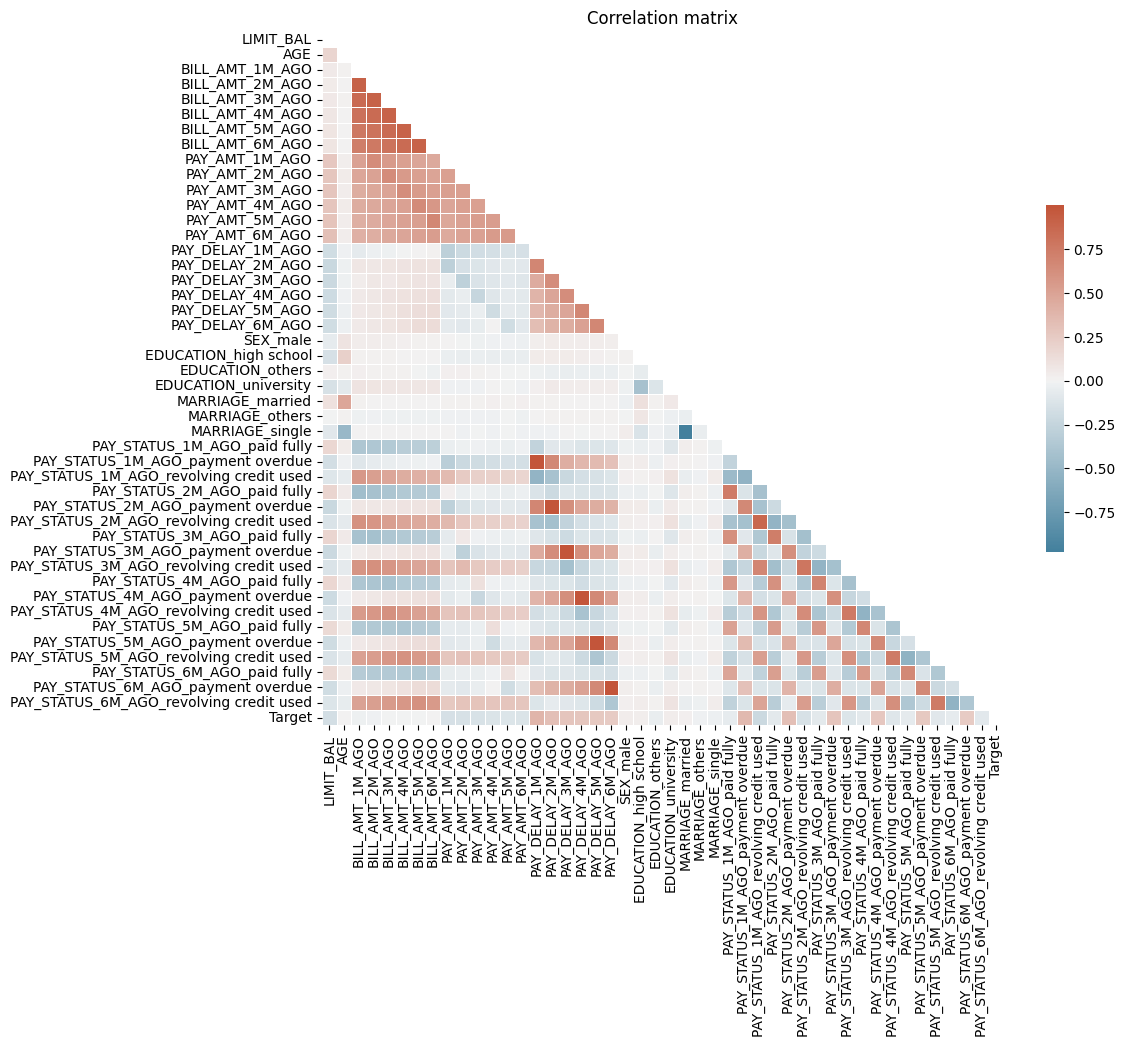

In [ ]:
default_cc_corr = calculate_correlation(default_cc_train_encoded, 'spearman') #, variables_for_correlation)

In [ ]:
abs(default_cc_corr['Target']).sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.384900
PAY_STATUS_1M_AGO_payment overdue          0.361325
PAY_DELAY_2M_AGO                           0.326266
PAY_STATUS_2M_AGO_payment overdue          0.325452
PAY_DELAY_3M_AGO                           0.287098
PAY_STATUS_3M_AGO_payment overdue          0.286152
PAY_DELAY_4M_AGO                           0.274226
PAY_STATUS_4M_AGO_payment overdue          0.273232
PAY_DELAY_5M_AGO                           0.261017
PAY_STATUS_5M_AGO_payment overdue          0.260116
PAY_DELAY_6M_AGO                           0.244671
PAY_STATUS_6M_AGO_payment overdue          0.243548
PAY_STATUS_1M_AGO_revolving credit used    0.213499
LIMIT_BAL                                  0.166275
PAY_AMT_1M_AGO                             0.154697
PAY_STATUS_2M_AGO_revolving credit used    0.148554
PAY_AMT_2M_AGO                             0.146715
PAY_AMT_3M_AGO                             0.139978
PAY_AMT_4M_AGO                             0.126635
PAY_AMT_6M_AGO                             0.121124
PAY_AMT_5M_AGO                             0.117971
PAY_STATUS_3M_AGO_revolving credit used    0.114844
PAY_STATUS_4M_AGO_revolving credit used    0.099740
PAY_STATUS_5M_AGO_revolving credit used    0.089809
PAY_STATUS_6M_AGO_revolving credit used    0.086837
PAY_STATUS_3M_AGO_paid fully               0.077363
PAY_STATUS_2M_AGO_paid fully               0.075766
PAY_STATUS_4M_AGO_paid fully               0.073429
PAY_STATUS_5M_AGO_paid fully               0.069133
PAY_STATUS_1M_AGO_paid fully               0.064411
PAY_STATUS_6M_AGO_paid fully               0.061600
EDUCATION_others                           0.048298
EDUCATION_university                       0.037097
SEX_male                                   0.036982
EDUCATION_high school                      0.032305
MARRIAGE_single                            0.027821
MARRIAGE_married                           0.026244
BILL_AMT_1M_AGO                            0.025308
BILL_AMT_2M_AGO                            0.014326
MARRIAGE_others                            0.013454
BILL_AMT_3M_AGO                            0.011414
BILL_AMT_4M_AGO                            0.010129
BILL_AMT_5M_AGO                            0.008913
AGE                                        0.001993
BILL_AMT_6M_AGO                            0.001531
Name: Target, dtype: float64

df columns:  Index(['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO',
       'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO',
       'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO',
       'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'SEX_male',
       'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue',
       'PAY_STATUS_1M_AGO_revolving credit used',
       'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue',
       'PAY_STATUS_2M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue',
       'PAY_STATUS_3M_AGO_revolving credit used',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_4

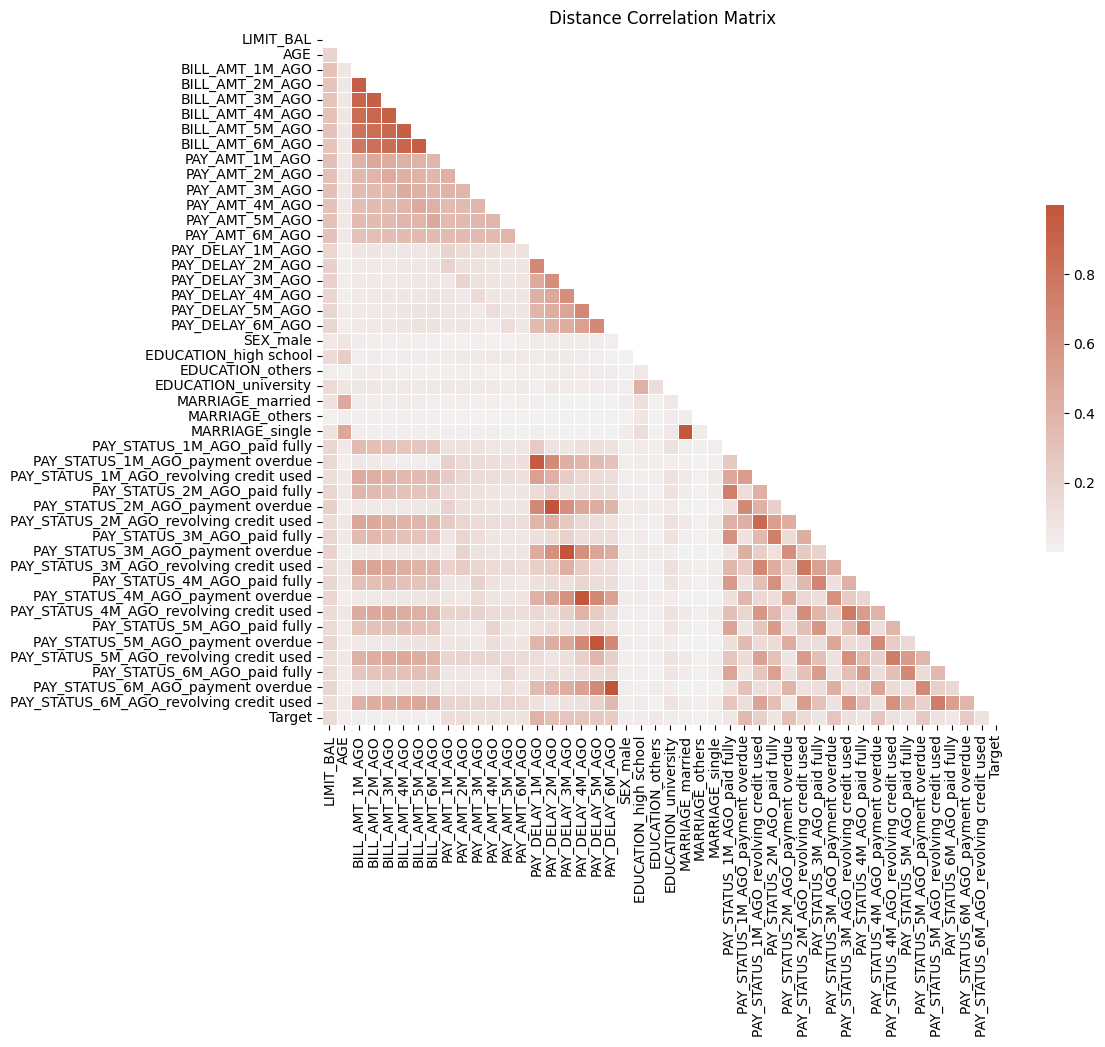

In [ ]:
default_cc_dist_corr = calculate_distance_correlation_matrix(default_cc_train_encoded)

In [ ]:
default_cc_dist_corr['Target'].sort_values(ascending=False)

Target                                     1.000000
PAY_DELAY_1M_AGO                           0.401849
PAY_STATUS_1M_AGO_payment overdue          0.361325
PAY_DELAY_2M_AGO                           0.326197
PAY_STATUS_2M_AGO_payment overdue          0.325452
PAY_DELAY_3M_AGO                           0.286395
PAY_STATUS_3M_AGO_payment overdue          0.286152
PAY_DELAY_4M_AGO                           0.273534
PAY_STATUS_4M_AGO_payment overdue          0.273232
PAY_DELAY_5M_AGO                           0.260580
PAY_STATUS_5M_AGO_payment overdue          0.260116
PAY_DELAY_6M_AGO                           0.244184
PAY_STATUS_6M_AGO_payment overdue          0.243548
PAY_STATUS_1M_AGO_revolving credit used    0.213499
LIMIT_BAL                                  0.153732
PAY_STATUS_2M_AGO_revolving credit used    0.148554
PAY_AMT_2M_AGO                             0.118876
PAY_AMT_1M_AGO                             0.118822
PAY_STATUS_3M_AGO_revolving credit used    0.114844
PAY_AMT_3M_AGO                             0.107607
PAY_STATUS_4M_AGO_revolving credit used    0.099740
PAY_AMT_4M_AGO                             0.095606
PAY_AMT_5M_AGO                             0.094957
PAY_AMT_6M_AGO                             0.092370
PAY_STATUS_5M_AGO_revolving credit used    0.089809
PAY_STATUS_6M_AGO_revolving credit used    0.086837
PAY_STATUS_3M_AGO_paid fully               0.077363
PAY_STATUS_2M_AGO_paid fully               0.075766
PAY_STATUS_4M_AGO_paid fully               0.073429
PAY_STATUS_5M_AGO_paid fully               0.069133
PAY_STATUS_1M_AGO_paid fully               0.064411
PAY_STATUS_6M_AGO_paid fully               0.061600
EDUCATION_others                           0.048298
EDUCATION_university                       0.037097
SEX_male                                   0.036982
EDUCATION_high school                      0.032305
BILL_AMT_1M_AGO                            0.028081
MARRIAGE_single                            0.027821
AGE                                        0.026424
MARRIAGE_married                           0.026244
BILL_AMT_2M_AGO                            0.021954
BILL_AMT_3M_AGO                            0.019245
BILL_AMT_4M_AGO                            0.017028
BILL_AMT_5M_AGO                            0.016919
BILL_AMT_6M_AGO                            0.015628
MARRIAGE_others                            0.013454
Name: Target, dtype: float64

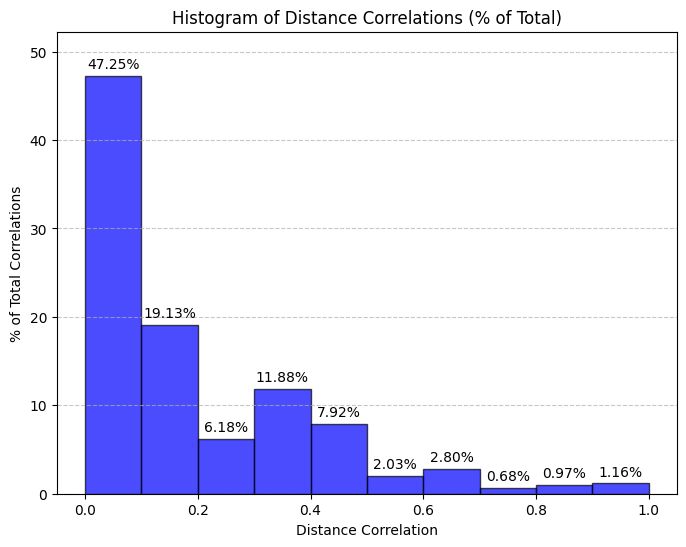

Percentage of correlations below 0.1: 47.25%
Percentage of correlations below 0.2: 66.38%
Percentage of correlations below 0.3: 72.56%
Percentage of correlations below 0.4: 84.44%
Percentage of correlations below 0.5: 92.37%
Percentage of correlations below 0.6: 94.40%
Percentage of correlations below 0.7: 97.20%
Percentage of correlations below 0.8: 97.87%
Percentage of correlations below 0.9: 98.84%
Percentage of correlations below 1.0: 100.00%


In [ ]:
plot_dcor_histogram(default_cc_dist_corr)

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

default_cc_zero_variance_columns = identify_zero_variance_columns(default_cc_train_encoded)

if DROP_WEAK_FEATURES:
  default_cc_weak_features = identify_weak_associated_features(
      default_cc_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  default_cc_weak_features = []

remove_columns = set(default_cc_zero_variance_columns + default_cc_weak_features)
print(remove_columns)

default_cc_train = default_cc_train_encoded.drop(columns=remove_columns)
default_cc_test = default_cc_test_encoded.drop(columns=remove_columns)

Variance of each column:
LIMIT_BAL                                  1.687617e+10
AGE                                        8.434651e+01
BILL_AMT_1M_AGO                            5.442118e+09
BILL_AMT_2M_AGO                            5.076571e+09
BILL_AMT_3M_AGO                            4.689320e+09
BILL_AMT_4M_AGO                            4.141768e+09
BILL_AMT_5M_AGO                            3.715101e+09
BILL_AMT_6M_AGO                            3.564932e+09
PAY_AMT_1M_AGO                             2.831953e+08
PAY_AMT_2M_AGO                             4.266821e+08
PAY_AMT_3M_AGO                             3.296769e+08
PAY_AMT_4M_AGO                             2.650750e+08
PAY_AMT_5M_AGO                             2.339204e+08
PAY_AMT_6M_AGO                             3.157077e+08
PAY_DELAY_1M_AGO                           5.763706e-01
PAY_DELAY_2M_AGO                           6.400466e-01
PAY_DELAY_3M_AGO                           6.234998e-01
PAY_DELAY_4M_AGO       

In [ ]:
default_cc_train.head()

LIMIT_BAL   AGE  BILL_AMT_1M_AGO  BILL_AMT_2M_AGO  BILL_AMT_3M_AGO  \
12094    50000.0  43.0          10898.0           8754.0              0.0   
21968   120000.0  28.0           1613.0            136.0              0.0   
20687   180000.0  28.0         175154.0         175790.0         153515.0   
25155    30000.0  24.0          29654.0          28570.0          31085.0   
15205   160000.0  29.0           6252.0           5073.0           6854.0   

       BILL_AMT_4M_AGO  BILL_AMT_5M_AGO  BILL_AMT_6M_AGO  PAY_AMT_1M_AGO  \
12094          16475.0          16821.0          17220.0          1000.0   
21968              0.0              0.0              0.0           136.0   
20687         130864.0         131569.0         128983.0          5100.0   
25155          29945.0          30373.0          29476.0             0.0   
15205           3759.0           3164.0           3000.0          4000.0   

       PAY_AMT_2M_AGO  ...  PAY_STATUS_4M_AGO_paid fully  \
12094             0.0  ...                           1.0   
21968             0.0  ...                           0.0   
20687            50.0  ...                           0.0   
25155          3300.0  ...                           0.0   
15205          2230.0  ...                           0.0   

       PAY_STATUS_4M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                1.0   

       PAY_STATUS_4M_AGO_revolving credit used  PAY_STATUS_5M_AGO_paid fully  \
12094                                      0.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      0.0                           0.0   

       PAY_STATUS_5M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_5M_AGO_revolving credit used  PAY_STATUS_6M_AGO_paid fully  \
12094                                      1.0                           0.0   
21968                                      0.0                           0.0   
20687                                      0.0                           0.0   
25155                                      0.0                           0.0   
15205                                      1.0                           0.0   

       PAY_STATUS_6M_AGO_payment overdue  \
12094                                0.0   
21968                                0.0   
20687                                1.0   
25155                                1.0   
15205                                0.0   

       PAY_STATUS_6M_AGO_revolving credit used  Target  
12094                                      1.0     0.0  
21968                                      0.0     0.0  
20687                                      0.0     0.0  
25155                                      0.0     0.0  
15205                                      1.0     0.0  

[5 rows x 46 columns]

In [ ]:
print('Original number of features: ', len(default_cc.columns))
print('Number of features after pre-feature selection: ', len(default_cc_train.columns))

Original number of features:  30
Number of features after pre-feature selection:  46


# **Imbalanced dataset**

In [ ]:
X_train = default_cc_train.drop('Target', axis=1)
y_train = default_cc_train['Target']

X_test = default_cc_test.drop('Target', axis=1)
y_test = default_cc_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0     18691    0.778792
1.0      5309    0.221208

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
default_cc_imputation_values_dict = calculate_imputation_values_for_missing(
    default_cc_train
)
default_cc_imputation_values_dict

{'LIMIT_BAL': 140000.0,
 'AGE': 34.0,
 'BILL_AMT_1M_AGO': 22420.5,
 'BILL_AMT_2M_AGO': 21190.5,
 'BILL_AMT_3M_AGO': 20085.5,
 'BILL_AMT_4M_AGO': 19052.0,
 'BILL_AMT_5M_AGO': 18089.0,
 'BILL_AMT_6M_AGO': 16946.0,
 'PAY_AMT_1M_AGO': 2100.0,
 'PAY_AMT_2M_AGO': 2003.0,
 'PAY_AMT_3M_AGO': 1800.0,
 'PAY_AMT_4M_AGO': 1500.0,
 'PAY_AMT_5M_AGO': 1500.0,
 'PAY_AMT_6M_AGO': 1500.0,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_revolving credit used': 0.0,
 'PAY_STATUS_2M_AGO_paid fully': 0.0,
 'PAY_STATUS_2M_AGO_payment overdue': 0.0,
 'PAY_STATUS_2M_AGO_revolving credit used': 1.0,
 'PAY_STATUS_3M_AGO_paid full

In [ ]:
default_cc_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
default_cc_cat_vars

['SEX_male',
 'EDUCATION_high school',
 'EDUCATION_others',
 'EDUCATION_university',
 'MARRIAGE_married',
 'MARRIAGE_others',
 'MARRIAGE_single',
 'PAY_STATUS_1M_AGO_paid fully',
 'PAY_STATUS_1M_AGO_payment overdue',
 'PAY_STATUS_1M_AGO_revolving credit used',
 'PAY_STATUS_2M_AGO_paid fully',
 'PAY_STATUS_2M_AGO_payment overdue',
 'PAY_STATUS_2M_AGO_revolving credit used',
 'PAY_STATUS_3M_AGO_paid fully',
 'PAY_STATUS_3M_AGO_payment overdue',
 'PAY_STATUS_3M_AGO_revolving credit used',
 'PAY_STATUS_4M_AGO_paid fully',
 'PAY_STATUS_4M_AGO_payment overdue',
 'PAY_STATUS_4M_AGO_revolving credit used',
 'PAY_STATUS_5M_AGO_paid fully',
 'PAY_STATUS_5M_AGO_payment overdue',
 'PAY_STATUS_5M_AGO_revolving credit used',
 'PAY_STATUS_6M_AGO_paid fully',
 'PAY_STATUS_6M_AGO_payment overdue',
 'PAY_STATUS_6M_AGO_revolving credit used']

In [ ]:
# Maximum number of original features (after feature engineering) to be imputed
NUM_FEAT = 20

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [None],
    'min_samples_split': [0.05],
    'min_samples_leaf': [1]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 12:26:09.271026

Nested Cross-validation Results:
Individual scores: [0.52989    0.51555341 0.51358763]
Average nested CV score: 0.520 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.520
2025-01-18 12:26:13.373415

Execution time: 0.07 minutes




```
Starting hyperparameter tuning at: 2025-01-16 20:26:51.540094

Nested Cross-validation Results:
Individual scores: [0.52046784 0.50743846 0.50658404]
Average nested CV score: 0.511 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.520
2025-01-16 20:27:33.483503

Execution time: 0.70 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28  PAY_STATUS_1M_AGO_payment overdue    0.070854  0.002003
17                   PAY_DELAY_4M_AGO    0.028638  0.000773
14                   PAY_DELAY_1M_AGO    0.015311  0.000895
0                           LIMIT_BAL    0.014980  0.000716
16                   PAY_DELAY_3M_AGO    0.012544  0.001171
8                      PAY_AMT_1M_AGO    0.012288  0.002687
12                     PAY_AMT_5M_AGO    0.012163  0.000865
36       PAY_STATUS_4M_AGO_paid fully    0.010811  0.001625
3                     BILL_AMT_2M_AGO    0.009217  0.000248
5                     BILL_AMT_4M_AGO    0.006379  0.000161
22                   EDUCATION_others    0.003668  0.000780
10                     PAY_AMT_3M_AGO    0.003476  0.000647
13                     PAY_AMT_6M_AGO    0.002543  0.000635
15                   PAY_DELAY_2M_AGO    0.002503  0.000490
37  PAY_STATUS_4M_AGO_payment overdue    0.001598  0.000212
11                     PAY_AMT_4M_AGO    0.000865  0.001206
7                     BILL_AMT_6M_AGO    0.000750  0.000373
1                                 AGE    0.000236  0.000062
25                    MARRIAGE_others    0.000157  0.000170
4                     BILL_AMT_3M_AGO    0.000122  0.000086
9                      PAY_AMT_2M_AGO    0.000045  0.001134
2                     BILL_AMT_1M_AGO    0.000045  0.000015
43  PAY_STATUS_6M_AGO_payment overdue    0.000004  0.000052

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

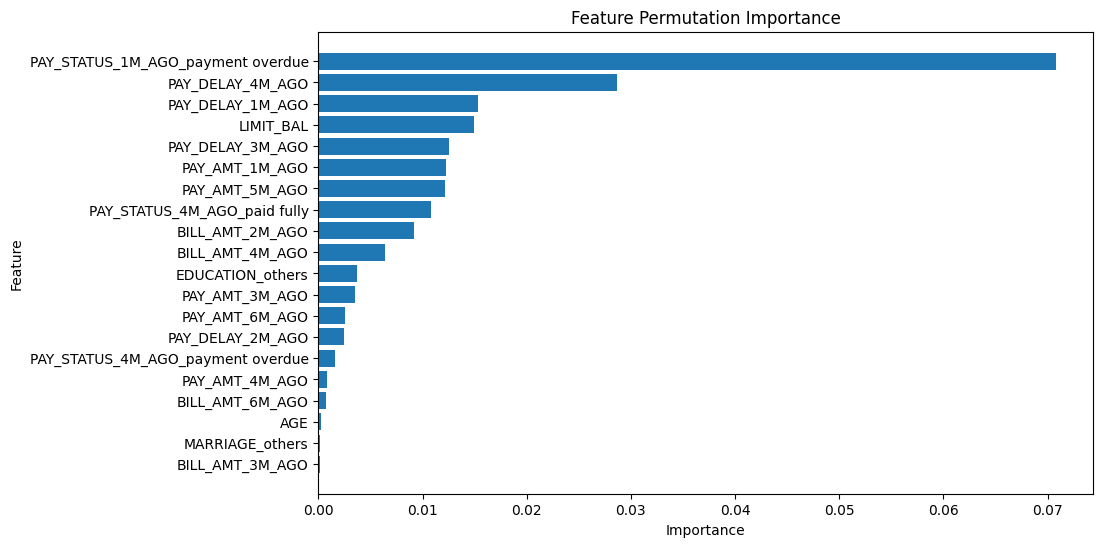

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M

In [ ]:
dt_orig_missing

['PAY_STATUS_1M_AGO',
 'PAY_DELAY_4M_AGO',
 'PAY_DELAY_1M_AGO',
 'LIMIT_BAL',
 'PAY_DELAY_3M_AGO',
 'PAY_AMT_1M_AGO',
 'PAY_AMT_5M_AGO',
 'PAY_STATUS_4M_AGO',
 'BILL_AMT_2M_AGO',
 'BILL_AMT_4M_AGO',
 'EDUCATION',
 'PAY_AMT_3M_AGO',
 'PAY_AMT_6M_AGO',
 'PAY_DELAY_2M_AGO',
 'PAY_AMT_4M_AGO',
 'BILL_AMT_6M_AGO',
 'AGE',
 'MARRIAGE',
 'BILL_AMT_3M_AGO',
 'PAY_AMT_2M_AGO']

In [ ]:
len(dt_missing)

28

In [ ]:
dt_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1   744  3545  1128   583      39.74   56.07        75.86     71.48     46.51   
2   532  3742   931   795      36.36   40.09        80.08     71.23     38.14   
3   532  3742   931   795      36.36   40.09        80.08     71.23     38.14   
4   481  3938   735   846      39.56   36.25        84.27     73.65     37.83   
5   260  4151   522  1067      33.25   19.59        88.83     73.52     24.66   
6    25  4607    66  1302      27.47    1.88        98.59     77.20      3.53   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.54                 0   
1               65.96                 1   
2               60.08                 2   
3               60.08                 3   
4               60.26                 4   
5               54.21                 5   
6               50.24                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:27:12.984657

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
dt_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1   750  3530  1143   577      39.62   56.52        75.54     71.33     46.58   
2   721  3595  1078   606      40.08   54.33        76.93     71.93     46.13   
3   721  3600  1073   606      40.19   54.33        77.04     72.02     46.20   
4   688  3694   979   639      41.27   51.85        79.05     73.03     45.96   
5   444  3901   772   883      36.51   33.46        83.48     72.42     34.92   
6   463  4016   657   864      41.34   34.89        85.94     74.65     37.84   
7   445  4055   618   882      41.86   33.53        86.78     75.00     37.24   
8   458  3952   721   869      38.85   34.51        84.57     73.50     36.55   
9   383  4186   487   944      44.02   28.86        89.58     76.15     34.87   
10  385  4202   471   942      44.98   29.01        89.92     76.45     35.27   
11  354  4342   331   973      51.68   26.68        92.92     78.27     35.19   
12  327  4381   292  1000      52.83   24.64        93.75     78.47     33.61   
13  324  4379   294  1003      52.43   24.42        93.71     78.38     33.32   
14  107  4517   156  1220      40.68    8.06        96.66     77.07     13.46   
15  100  4529   144  1227      40.98    7.54        96.92     77.15     12.73   
16  104  4521   152  1223      40.62    7.84        96.75     77.08     13.14   
17   97  4524   149  1230      39.43    7.31        96.81     77.02     12.33   
18  108  4527   146  1219      42.52    8.14        96.88     77.25     13.66   
19   90  4582    91  1237      49.72    6.78        98.05     77.87     11.94   
20   98  4588    85  1229      53.55    7.39        98.18     78.10     12.98   

    balanced_accuracy  num_feat_missing  \
0               70.54                 0   
1               66.03                 1   
2               65.63                 2   
3               65.69                 3   
4               65.45                 4   
5               58.47                 5   
6               60.42                 6   
7               60.15                 7   
8               59.54                 8   
9               59.22                 9   
10              59.47                10   
11              59.80                11   
12              59.20                12   
13              59.06                13   
14              52.36                14   
15              52.23                15   
16              52.29                16   
17              52.06                17   
18              52.51                18   
19              52.42                19   
20              52.78                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
dt_perf_temp, dt_orig_missing_temp, dt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
dt_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1  550  4101   572   777      49.02   41.45        87.76     77.52     44.92   
2  337  4303   370   990      47.67   25.40        92.08     77.33     33.14   
3  332  4328   345   995      49.04   25.02        92.62     77.67     33.13   
4   25  4601    72  1302      25.77    1.88        98.46     77.10      3.51   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.54                 0   
1              64.60                 4   
2              58.74                 8   
3              58.82                 9   
4              50.17                13   
5              50.00                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_temp_mf, dt_orig_missing_temp_mf, dt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:34:12.596814

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
dt_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1  728  3650  1023   599      41.58   54.86        78.11     72.97     47.30   
2  707  3633  1040   620      40.47   53.28        77.74     72.33     46.00   
3  678  3708   965   649      41.27   51.09        79.35     73.10     45.66   
4  334  4369   304   993      52.35   25.17        93.49     78.38     33.99   
5  293  4399   274  1034      51.68   22.08        94.14     78.20     30.94   
6   14  4665     8  1313      63.64    1.06        99.83     77.98      2.08   

   balanced_accuracy  num_feat_missing  \
0              70.54                 0   
1              66.48                 4   
2              65.51                 8   
3              65.22                 9   
4              59.33                13   
5              58.11                17   
6              50.44                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [200],
      'max_features': ['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:18:01.057869

Nested Cross-validation Results:
Individual scores: [0.55361859 0.53386454 0.53691983]
Average nested CV score: 0.541 (+/- 0.017)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.541
2025-01-18 10:18:28.726481

Execution time: 0.46 minutes



```
Starting hyperparameter tuning at: 2025-01-17 02:10:59.499933

Nested Cross-validation Results:
Individual scores: [0.55344918 0.53248475 0.53614776]
Average nested CV score: 0.541 (+/- 0.018)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.541
2025-01-17 03:57:15.491482

Execution time: 106.27 minutes
```

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.052718  0.002208
2                           BILL_AMT_1M_AGO    0.022423  0.000610
11                           PAY_AMT_4M_AGO    0.021993  0.000687
10                           PAY_AMT_3M_AGO    0.019430  0.000927
0                                 LIMIT_BAL    0.019278  0.001880
6                           BILL_AMT_5M_AGO    0.016126  0.001062
9                            PAY_AMT_2M_AGO    0.015330  0.001305
8                            PAY_AMT_1M_AGO    0.015262  0.002371
5                           BILL_AMT_4M_AGO    0.014052  0.000730
7                           BILL_AMT_6M_AGO    0.013422  0.001092
12                           PAY_AMT_5M_AGO    0.013227  0.000713
13                           PAY_AMT_6M_AGO    0.011938  0.001265
3                           BILL_AMT_2M_AGO    0.010652  0.000398
4                           BILL_AMT_3M_AGO    0.009959  0.001456
1                                       AGE    0.008092  0.000726
16                         PAY_DELAY_3M_AGO    0.003615  0.000626
29  PAY_STATUS_1M_AGO_revolving credit used    0.003515  0.000706
27             PAY_STATUS_1M_AGO_paid fully    0.003497  0.000425
23                     EDUCATION_university    0.002996  0.000156
34        PAY_STATUS_3M_AGO_payment overdue    0.002783  0.000689
42             PAY_STATUS_6M_AGO_paid fully    0.002572  0.000300
44  PAY_STATUS_6M_AGO_revolving credit used    0.002553  0.000611
33             PAY_STATUS_3M_AGO_paid fully    0.002347  0.000207
36             PAY_STATUS_4M_AGO_paid fully    0.002057  0.000324
28        PAY_STATUS_1M_AGO_payment overdue    0.002054  0.000413
20                                 SEX_male    0.001925  0.000706
24                         MARRIAGE_married    0.001878  0.000672
32  PAY_STATUS_2M_AGO_revolving credit used    0.001795  0.000211
39             PAY_STATUS_5M_AGO_paid fully    0.001744  0.000349
26                          MARRIAGE_single    0.001735  0.000242
35  PAY_STATUS_3M_AGO_revolving credit used    0.001662  0.000374
30             PAY_STATUS_2M_AGO_paid fully    0.001604  0.000293
22                         EDUCATION_others    0.001514  0.000397
41  PAY_STATUS_5M_AGO_revolving credit used    0.001403  0.000317
43        PAY_STATUS_6M_AGO_payment overdue    0.001181  0.000538
19                         PAY_DELAY_6M_AGO    0.000956  0.000452
21                    EDUCATION_high school    0.000801  0.000268
37        PAY_STATUS_4M_AGO_payment overdue    0.000796  0.000592
18                         PAY_DELAY_5M_AGO    0.000093  0.000580
38  PAY_STATUS_4M_AGO_revolving credit used    0.000089  0.000585
40        PAY_STATUS_5M_AGO_payment overdue    0.000025  0.000591
17                         PAY_DELAY_4M_AGO   -0.000224  0.000901
31        PAY_STATUS_2M_AGO_payment overdue   -0.001620  0.001343
15                         PAY_DELAY_2M_AGO   -0.002252  0.001594

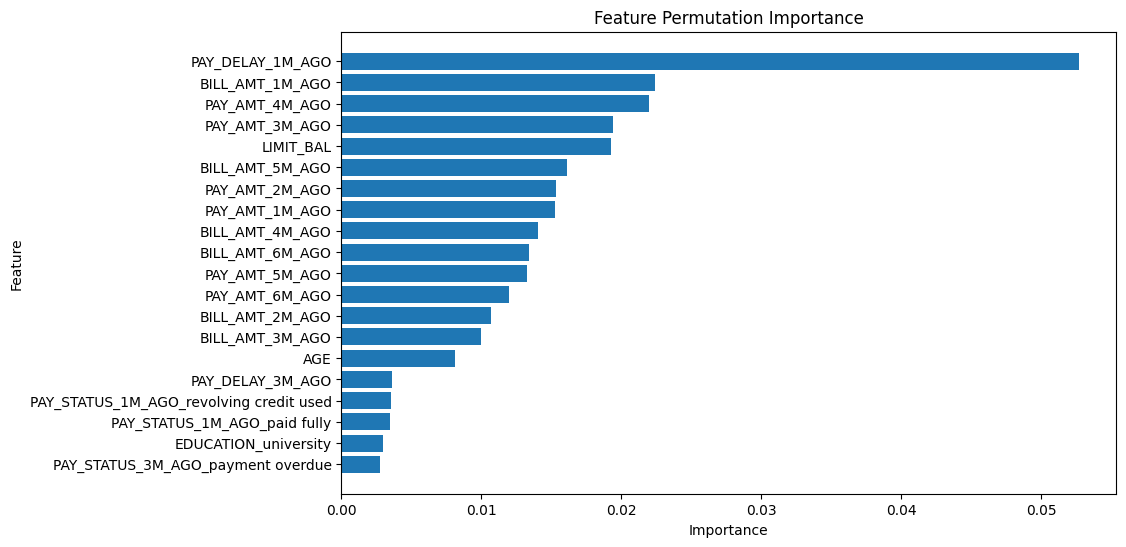

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_3M_AGO', 'LIMIT_BAL', 'BILL_AMT_5M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so

In [ ]:
rf_perf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3949  724  518      52.77   60.96        84.51     79.30     56.57   
1   714  4024  649  613      52.38   53.81        86.11     78.97     53.09   
2   643  4170  503  684      56.11   48.46        89.24     80.22     52.00   
3   623  4202  471  704      56.95   46.95        89.92     80.42     51.47   
4   618  4229  444  709      58.19   46.57        90.50     80.78     51.74   
5   599  4254  419  728      58.84   45.14        91.03     80.88     51.09   
6   597  4255  418  730      58.82   44.99        91.05     80.87     50.98   
7   593  4250  423  734      58.37   44.69        90.95     80.72     50.62   
8   569  4285  388  758      59.46   42.88        91.70     80.90     49.82   
9   550  4313  360  777      60.44   41.45        92.30     81.05     49.17   
10  541  4320  353  786      60.51   40.77        92.45     81.02     48.72   
11  542  4316  357  785      60.29   40.84        92.36     80.97     48.70   
12  534  4321  352  793      60.27   40.24        92.47     80.92     48.26   
13  530  4328  345  797      60.57   39.94        92.62     80.97     48.14   
14  531  4330  343  796      60.76   40.02        92.66     81.02     48.25   
15  528  4327  346  799      60.41   39.79        92.60     80.92     47.98   
16  510  4365  308  817      62.35   38.43        93.41     81.25     47.55   
17  402  4429  244  925      62.23   30.29        94.78     80.52     40.75   
18  402  4429  244  925      62.23   30.29        94.78     80.52     40.75   
19  402  4426  247  925      61.94   30.29        94.71     80.47     40.69   
20  371  4453  220  956      62.77   27.96        95.29     80.40     38.69   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               69.96                 1   
2               68.85                 2   
3               68.43                 3   
4               68.53                 4   
5               68.09                 5   
6               68.02                 6   
7               67.82                 7   
8               67.29                 8   
9               66.87                 9   
10              66.61                10   
11              66.60                11   
12              66.35                12   
13              66.28                13   
14              66.34                14   
15              66.19                15   
16              65.92                16   
17              62.54                17   
18              62.54                18   
19              62.50                19   
20              61.62                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:36:18.275002

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
rf_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   809  3949  724  518      52.77   60.96        84.51     79.30     56.57   
1   729  3982  691  598      51.34   54.94        85.21     78.52     53.08   
2   703  4048  625  624      52.94   52.98        86.63     79.18     52.96   
3   680  4106  567  647      54.53   51.24        87.87     79.77     52.84   
4   657  4145  528  670      55.44   49.51        88.70     80.03     52.31   
5   636  4165  508  691      55.59   47.93        89.13     80.02     51.48   
6   624  4168  505  703      55.27   47.02        89.19     79.87     50.81   
7   622  4180  493  705      55.78   46.87        89.45     80.03     50.94   
8   618  4188  485  709      56.03   46.57        89.62     80.10     50.86   
9   620  4196  477  707      56.52   46.72        89.79     80.27     51.16   
10  620  4203  470  707      56.88   46.72        89.94     80.38     51.30   
11  622  4216  457  705      57.65   46.87        90.22     80.63     51.70   
12  611  4223  450  716      57.59   46.04        90.37     80.57     51.17   
13  605  4225  448  722      57.45   45.59        90.41     80.50     50.84   
14  631  4165  508  696      55.40   47.55        89.13     79.93     51.18   
15  626  4199  474  701      56.91   47.17        89.86     80.42     51.59   
16  615  4220  453  712      57.58   46.35        90.31     80.58     51.36   
17  528  4304  369  799      58.86   39.79        92.10     80.53     47.48   
18  539  4289  384  788      58.40   40.62        91.78     80.47     47.91   
19  479  4346  327  848      59.43   36.10        93.00     80.42     44.91   
20  479  4350  323  848      59.73   36.10        93.09     80.48     45.00   

    balanced_accuracy  num_feat_missing  \
0               72.74                 0   
1               70.07                 1   
2               69.80                 2   
3               69.55                 3   
4               69.11                 4   
5               68.53                 5   
6               68.11                 6   
7               68.16                 7   
8               68.10                 8   
9               68.26                 9   
10              68.33                10   
11              68.55                11   
12              68.21                12   
13              68.00                13   
14              68.34                14   
15              68.52                15   
16              68.33                16   
17              65.95                17   
18              66.20                18   
19              64.55                19   
20              64.59                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
rf_perf_temp, rf_orig_missing_temp, rf_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
rf_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3949  724   518      52.77   60.96        84.51     79.30     56.57   
1  556  4240  433   771      56.22   41.90        90.73     79.93     48.01   
2  518  4329  344   809      60.09   39.04        92.64     80.78     47.33   
3  385  4451  222   942      63.43   29.01        95.25     80.60     39.81   
4  288  4523  150  1039      65.75   21.70        96.79     80.18     32.63   
5  257  4559  114  1070      69.27   19.37        97.56     80.27     30.27   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.74                 0   
1              66.32                 4   
2              65.84                 8   
3              62.13                12   
4              59.25                13   
5              58.46                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_temp_mf, rf_orig_missing_temp_mf, rf_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:42:55.121058

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
rf_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  809  3949  724   518      52.77   60.96        84.51     79.30     56.57   
1  645  4121  552   682      53.88   48.61        88.19     79.43     51.11   
2  606  4216  457   721      57.01   45.67        90.22     80.37     50.71   
3  532  4315  358   795      59.78   40.09        92.34     80.78     47.99   
4  526  4313  360   801      59.37   39.64        92.30     80.65     47.54   
5  480  4365  308   847      60.91   36.17        93.41     80.75     45.39   
6   21  4664    9  1306      70.00    1.58        99.81     78.08      3.10   

   balanced_accuracy  num_feat_missing  \
0              72.74                 0   
1              68.40                 4   
2              67.94                 8   
3              66.21                12   
4              65.97                13   
5              64.79                17   
6              50.69                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

3.520625353173856

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [5.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:25:30.412378

Nested Cross-validation Results:
Individual scores: [0.55146003 0.52880212 0.5312351 ]
Average nested CV score: 0.537 (+/- 0.020)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.537
2025-01-18 10:25:34.645255

Execution time: 0.07 minutes


```
Starting hyperparameter tuning at: 2025-01-16 20:27:36.715056

Nested Cross-validation Results:
Individual scores: [0.54979503 0.53066152 0.52374101]
Average nested CV score: 0.535 (+/- 0.022)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.537
2025-01-16 20:37:57.212885

Execution time: 10.34 minutes
```

In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.090921  0.002793
0                                 LIMIT_BAL    0.009223  0.001283
4                           BILL_AMT_3M_AGO    0.008330  0.001126
16                         PAY_DELAY_3M_AGO    0.005661  0.000273
15                         PAY_DELAY_2M_AGO    0.004027  0.000269
17                         PAY_DELAY_4M_AGO    0.003792  0.000906
10                           PAY_AMT_3M_AGO    0.003223  0.001194
22                         EDUCATION_others    0.002532  0.000517
2                           BILL_AMT_1M_AGO    0.002527  0.000984
3                           BILL_AMT_2M_AGO    0.001768  0.000824
27             PAY_STATUS_1M_AGO_paid fully    0.001730  0.000370
5                           BILL_AMT_4M_AGO    0.001668  0.000388
1                                       AGE    0.001659  0.000094
36             PAY_STATUS_4M_AGO_paid fully    0.001307  0.000357
19                         PAY_DELAY_6M_AGO    0.001249  0.000762
8                            PAY_AMT_1M_AGO    0.001126  0.001030
20                                 SEX_male    0.000996  0.000357
26                          MARRIAGE_single    0.000806  0.000649
18                         PAY_DELAY_5M_AGO    0.000599  0.000495
9                            PAY_AMT_2M_AGO    0.000104  0.001719
25                          MARRIAGE_others    0.000098  0.000038
24                         MARRIAGE_married    0.000017  0.000021
21                    EDUCATION_high school   -0.000009  0.000017
32  PAY_STATUS_2M_AGO_revolving credit used   -0.000098  0.000059
39             PAY_STATUS_5M_AGO_paid fully   -0.000196  0.000181
33             PAY_STATUS_3M_AGO_paid fully   -0.000314  0.000274
23                     EDUCATION_university   -0.000338  0.000273
12                           PAY_AMT_5M_AGO   -0.000361  0.000377
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000898  0.000348
11                           PAY_AMT_4M_AGO   -0.001118  0.001869
7                           BILL_AMT_6M_AGO   -0.001132  0.000343
13                           PAY_AMT_6M_AGO   -0.001419  0.000548
6                           BILL_AMT_5M_AGO   -0.001614  0.000910

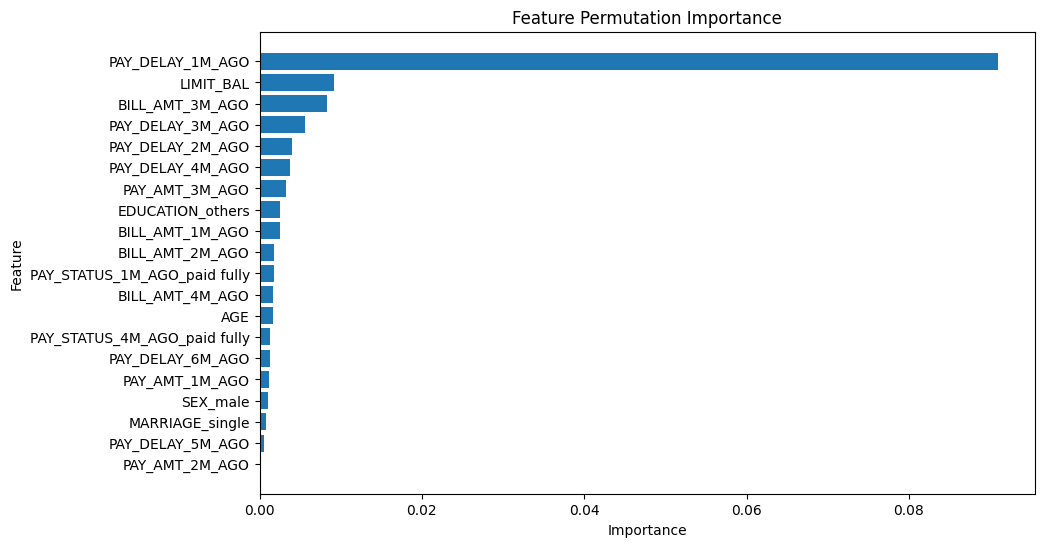

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so

In [ ]:
gbt_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   865  3740  933   462      48.11   65.18        80.03     76.75     55.36   
1   665  3947  726   662      47.81   50.11        84.46     76.87     48.93   
2   613  4035  638   714      49.00   46.19        86.35     77.47     47.56   
3   609  4030  643   718      48.64   45.89        86.24     77.32     47.23   
4   498  4123  550   829      47.52   37.53        88.23     77.02     41.94   
5   399  4182  491   928      44.83   30.07        89.49     76.35     35.99   
6   246  4294  379  1081      39.36   18.54        91.89     75.67     25.20   
7   102  4586   87  1225      53.97    7.69        98.14     78.13     13.46   
8    98  4588   85  1229      53.55    7.39        98.18     78.10     12.98   
9    36  4659   14  1291      72.00    2.71        99.70     78.25      5.23   
10   34  4662   11  1293      75.56    2.56        99.76     78.27      4.96   
11   30  4661   12  1297      71.43    2.26        99.74     78.18      4.38   
12   31  4661   12  1296      72.09    2.34        99.74     78.20      4.53   
13   35  4658   15  1292      70.00    2.64        99.68     78.22      5.08   
14   35  4658   15  1292      70.00    2.64        99.68     78.22      5.08   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.61                 0   
1               67.29                 1   
2               66.27                 2   
3               66.07                 3   
4               62.88                 4   
5               59.78                 5   
6               55.21                 6   
7               52.91                 7   
8               52.78                 8   
9               51.21                 9   
10              51.16                10   
11              51.00                11   
12              51.04                12   
13              51.16                13   
14              51.16                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:44:55.396197

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    865  3740   933  462      48.11   65.18        80.03     76.75     55.36   
1   1089  2276  2397  238      31.24   82.06        48.71     56.08     45.25   
2   1046  2451  2222  281      32.01   78.82        52.45     58.28     45.53   
3   1051  2434  2239  276      31.95   79.20        52.09     58.08     45.53   
4   1161  1710  2963  166      28.15   87.49        36.59     47.85     42.60   
5   1168  1498  3175  159      26.89   88.02        32.06     44.43     41.20   
6   1246   887  3786   81      24.76   93.90        18.98     35.55     39.19   
7   1247   892  3781   80      24.80   93.97        19.09     35.65     39.24   
8   1252   836  3837   75      24.60   94.35        17.89     34.80     39.03   
9   1211  1066  3607  116      25.13   91.26        22.81     37.95     39.41   
10  1195  1146  3527  132      25.31   90.05        24.52     39.02     39.51   
11  1227   977  3696  100      24.92   92.46        20.91     36.73     39.26   
12  1228  1007  3666   99      25.09   92.54        21.55     37.25     39.48   
13  1216  1114  3559  111      25.47   91.64        23.84     38.83     39.86   
14  1221  1009  3664  106      24.99   92.01        21.59     37.17     39.31   
15  1275   637  4036   52      24.01   96.08        13.63     31.87     38.42   
16  1257   688  3985   70      23.98   94.72        14.72     32.42     38.27   
17  1262   671  4002   65      23.97   95.10        14.36     32.22     38.29   
18  1250   742  3931   77      24.13   94.20        15.88     33.20     38.41   
19  1274   490  4183   53      23.35   96.01        10.49     29.40     37.56   
20  1253   511  4162   74      23.14   94.42        10.94     29.40     37.17   

    balanced_accuracy  num_feat_missing  \
0               72.61                 0   
1               65.39                 1   
2               65.64                 2   
3               65.64                 3   
4               62.04                 4   
5               60.04                 5   
6               56.44                 6   
7               56.53                 7   
8               56.12                 8   
9               57.04                 9   
10              57.29                10   
11              56.69                11   
12              57.04                12   
13              57.74                13   
14              56.80                14   
15              54.86                15   
16              54.72                16   
17              54.73                17   
18              55.04                18   
19              53.25                19   
20              52.68                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_3M...

In [ ]:
gbt_perf_temp, gbt_orig_missing_temp, gbt_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  865  3740  933   462      48.11   65.18        80.03     76.75     55.36   
1  496  4312  361   831      57.88   37.38        92.27     80.13     45.42   
2  443  4390  283   884      61.02   33.38        93.94     80.55     43.16   
3  253  4545  128  1074      66.40   19.07        97.26     79.97     29.63   
4  236  4544  129  1091      64.66   17.78        97.24     79.67     27.90   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.61                 0   
1              64.83                 4   
2              63.66                 5   
3              58.16                 9   
4              57.51                13   
5              50.00                17   
6              50.00                18   
7              50.00                19   
8              50.00                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_temp_mf, gbt_orig_missing_temp_mf, gbt_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:51:32.759903

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   865  3740   933  462      48.11   65.18        80.03     76.75     55.36   
1  1111  2080  2593  216      29.99   83.72        44.51     53.18     44.17   
2  1078  2152  2521  249      29.95   81.24        46.05     53.83     43.77   
3  1165  1538  3135  162      27.09   87.79        32.91     45.05     41.41   
4  1011  2089  2584  316      28.12   76.19        44.70     51.67     41.08   
5  1186   958  3715  141      24.20   89.37        20.50     35.73     38.09   
6  1191   895  3778  136      23.97   89.75        19.15     34.77     37.83   
7  1181   943  3730  146      24.05   89.00        20.18     35.40     37.86   
8  1246   429  4244   81      22.70   93.90         9.18     27.92     36.56   

   balanced_accuracy  num_feat_missing  \
0              72.61                 0   
1              64.12                 4   
2              63.64                 5   
3              60.35                 9   
4              60.45                13   
5              54.94                17   
6              54.45                18   
7              54.59                19   
8              51.54                23   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'reg_lambda':[5.0],
      'gamma': [1.0],
      'colsample_bytree':[0.5]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:32:22.697696

Nested Cross-validation Results:
Individual scores: [0.55226057 0.53346172 0.52674502]
Average nested CV score: 0.537 (+/- 0.022)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.537
2025-01-18 10:32:25.805435

Execution time: 0.05 minutes


```
Starting hyperparameter tuning at: 2025-01-16 20:37:57.224891

Nested Cross-validation Results:
Individual scores: [0.54815525 0.5265666  0.52403617]
Average nested CV score: 0.533 (+/- 0.022)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.537
2025-01-16 20:57:52.647606

Execution time: 19.92 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.036450  0.001616
28        PAY_STATUS_1M_AGO_payment overdue    0.032464  0.001353
0                                 LIMIT_BAL    0.016811  0.002618
2                           BILL_AMT_1M_AGO    0.015650  0.001731
4                           BILL_AMT_3M_AGO    0.014840  0.001366
10                           PAY_AMT_3M_AGO    0.008400  0.001256
17                         PAY_DELAY_4M_AGO    0.005242  0.001081
3                           BILL_AMT_2M_AGO    0.004016  0.001397
5                           BILL_AMT_4M_AGO    0.003566  0.001017
16                         PAY_DELAY_3M_AGO    0.003523  0.000577
9                            PAY_AMT_2M_AGO    0.003420  0.001300
22                         EDUCATION_others    0.002737  0.000831
19                         PAY_DELAY_6M_AGO    0.002282  0.001097
8                            PAY_AMT_1M_AGO    0.002278  0.000588
15                         PAY_DELAY_2M_AGO    0.002103  0.000937
18                         PAY_DELAY_5M_AGO    0.001639  0.000723
1                                       AGE    0.001591  0.000601
33             PAY_STATUS_3M_AGO_paid fully    0.001226  0.000540
7                           BILL_AMT_6M_AGO    0.001101  0.000241
26                          MARRIAGE_single    0.001055  0.000300
23                     EDUCATION_university    0.000844  0.000210
6                           BILL_AMT_5M_AGO    0.000741  0.000799
11                           PAY_AMT_4M_AGO    0.000679  0.001442
20                                 SEX_male    0.000666  0.000755
42             PAY_STATUS_6M_AGO_paid fully    0.000442  0.000557
32  PAY_STATUS_2M_AGO_revolving credit used    0.000397  0.000533
25                          MARRIAGE_others    0.000397  0.000158
27             PAY_STATUS_1M_AGO_paid fully    0.000392  0.001022
34        PAY_STATUS_3M_AGO_payment overdue    0.000198  0.000483
24                         MARRIAGE_married    0.000155  0.000581
31        PAY_STATUS_2M_AGO_payment overdue    0.000136  0.000064
35  PAY_STATUS_3M_AGO_revolving credit used    0.000116  0.000152
36             PAY_STATUS_4M_AGO_paid fully    0.000012  0.000357
12                           PAY_AMT_5M_AGO   -0.000011  0.001149
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000752  0.000847
13                           PAY_AMT_6M_AGO   -0.001851  0.000812

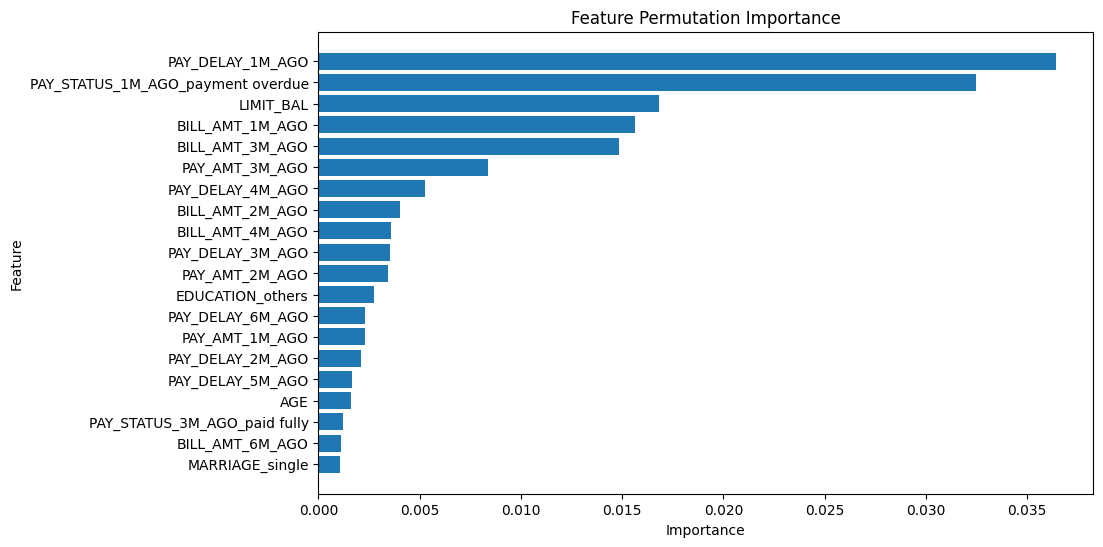

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'BILL_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_ST

In [ ]:
xgb_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   856  3742  931   471      47.90   64.51        80.08     76.63     54.98   
1   834  3752  921   493      47.52   62.85        80.29     76.43     54.12   
2   614  4015  658   713      48.27   46.27        85.92     77.15     47.25   
3   541  4159  514   786      51.28   40.77        89.00     78.33     45.42   
4   431  4398  275   896      61.05   32.48        94.12     80.48     42.40   
5   414  4409  264   913      61.06   31.20        94.35     80.38     41.30   
6   391  4443  230   936      62.96   29.46        95.08     80.57     40.14   
7   301  4518  155  1026      66.01   22.68        96.68     80.32     33.76   
8   296  4518  155  1031      65.63   22.31        96.68     80.23     33.30   
9   291  4520  153  1036      65.54   21.93        96.73     80.18     32.86   
10  181  4600   73  1146      71.26   13.64        98.44     79.68     22.90   
11  156  4616   57  1171      73.24   11.76        98.78     79.53     20.26   
12  149  4621   52  1178      74.13   11.23        98.89     79.50     19.50   
13    3  4673    0  1324     100.00    0.23       100.00     77.93      0.45   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.29                 0   
1               71.57                 1   
2               66.09                 2   
3               64.88                 3   
4               63.30                 4   
5               62.77                 5   
6               62.27                 6   
7               59.68                 7   
8               59.49                 8   
9               59.33                 9   
10              56.04                10   
11              55.27                11   
12              55.06                12   
13              50.11                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 12:54:10.809399

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   856  3742  931   471      47.90   64.51        80.08     76.63     54.98   
1   832  3753  920   495      47.49   62.70        80.31     76.42     54.04   
2   735  3746  927   592      44.22   55.39        80.16     74.68     49.18   
3   694  3868  805   633      46.30   52.30        82.77     76.03     49.12   
4   658  3995  678   669      49.25   49.59        85.49     77.55     49.42   
5   608  4071  602   719      50.25   45.82        87.12     77.98     47.93   
6   555  4181  492   772      53.01   41.82        89.47     78.93     46.76   
7   529  4245  428   798      55.28   39.86        90.84     79.57     46.32   
8   513  4261  412   814      55.46   38.66        91.18     79.57     45.56   
9   503  4271  402   824      55.58   37.91        91.40     79.57     45.07   
10  382  4363  310   945      55.20   28.79        93.37     79.08     37.84   
11  294  4459  214  1033      57.87   22.16        95.42     79.22     32.04   
12  295  4459  214  1032      57.96   22.23        95.42     79.23     32.14   
13  152  4535  138  1175      52.41   11.45        97.05     78.12     18.80   
14  162  4527  146  1165      52.60   12.21        96.88     78.15     19.82   
15  117  4553  120  1210      49.37    8.82        97.43     77.83     14.96   
16   38  4598   75  1289      33.63    2.86        98.40     77.27      5.28   
17   34  4605   68  1293      33.33    2.56        98.54     77.32      4.76   
18   47  4567  106  1280      30.72    3.54        97.73     76.90      6.35   
19   47  4567  106  1280      30.72    3.54        97.73     76.90      6.35   
20   85  4515  158  1242      34.98    6.41        96.62     76.67     10.83   

    balanced_accuracy  num_feat_missing  \
0               72.29                 0   
1               71.51                 1   
2               67.78                 2   
3               67.54                 3   
4               67.54                 4   
5               66.47                 5   
6               65.65                 6   
7               65.35                 7   
8               64.92                 8   
9               64.65                 9   
10              61.08                10   
11              58.79                11   
12              58.83                12   
13              54.25                13   
14              54.54                14   
15              53.12                15   
16              50.63                16   
17              50.55                17   
18              50.64                18   
19              50.64                19   
20              51.51                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
xgb_perf_temp, xgb_orig_missing_temp, xgb_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  856  3742  931   471      47.90   64.51        80.08     76.63     54.98   
1  476  4307  366   851      56.53   35.87        92.17     79.72     43.89   
2  427  4381  292   900      59.39   32.18        93.75     80.13     41.74   
3  282  4520  153  1045      64.83   21.25        96.73     80.03     32.01   
4  230  4580   93  1097      71.21   17.33        98.01     80.17     27.88   
5   22  4665    8  1305      73.33    1.66        99.83     78.12      3.24   
6   19  4666    7  1308      73.08    1.43        99.85     78.08      2.81   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.29                 0   
1              64.02                 4   
2              62.96                 5   
3              58.99                 9   
4              57.67                13   
5              50.74                17   
6              50.64                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_temp_mf, xgb_orig_missing_temp_mf, xgb_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:00:45.044261

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  856  3742  931   471      47.90   64.51        80.08     76.63     54.98   
1  676  3908  765   651      46.91   50.94        83.63     76.40     48.84   
2  626  4064  609   701      50.69   47.17        86.97     78.17     48.87   
3  543  4172  501   784      52.01   40.92        89.28     78.58     45.80   
4  409  4382  291   918      58.43   30.82        93.77     79.85     40.36   
5  200  4555  118  1127      62.89   15.07        97.47     79.25     24.32   
6  202  4558  115  1125      63.72   15.22        97.54     79.33     24.57   
7   55  4647   26  1272      67.90    4.14        99.44     78.37      7.81   

   balanced_accuracy  num_feat_missing  \
0              72.29                 0   
1              67.29                 4   
2              67.07                 5   
3              65.10                 9   
4              62.30                13   
5              56.27                17   
6              56.38                18   
7              51.79                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:39:08.436545

Nested Cross-validation Results:
Individual scores: [0.54468509 0.52781306 0.52914344]
Average nested CV score: 0.534 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.534
2025-01-18 10:39:17.457664

Execution time: 0.15 minutes


```
Starting hyperparameter tuning at: 2025-01-17 01:15:56.682828

Nested Cross-validation Results:
Individual scores: [0.5355983  0.52890026 0.5300228 ]
Average nested CV score: 0.532 (+/- 0.006)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.534
2025-01-17 02:10:58.279956

Execution time: 55.03 minutes
```

In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.026053  0.000945
28        PAY_STATUS_1M_AGO_payment overdue    0.021253  0.000710
32  PAY_STATUS_2M_AGO_revolving credit used    0.018454  0.001471
44  PAY_STATUS_6M_AGO_revolving credit used    0.017336  0.000887
0                                 LIMIT_BAL    0.016121  0.000466
3                           BILL_AMT_2M_AGO    0.015170  0.000900
29  PAY_STATUS_1M_AGO_revolving credit used    0.015007  0.000796
5                           BILL_AMT_4M_AGO    0.014922  0.000931
35  PAY_STATUS_3M_AGO_revolving credit used    0.014785  0.001131
2                           BILL_AMT_1M_AGO    0.013923  0.000882
6                           BILL_AMT_5M_AGO    0.013796  0.001563
4                           BILL_AMT_3M_AGO    0.013290  0.000640
7                           BILL_AMT_6M_AGO    0.012202  0.001180
33             PAY_STATUS_3M_AGO_paid fully    0.010313  0.000656
30             PAY_STATUS_2M_AGO_paid fully    0.010004  0.000934
41  PAY_STATUS_5M_AGO_revolving credit used    0.009927  0.001220
23                     EDUCATION_university    0.009507  0.000448
27             PAY_STATUS_1M_AGO_paid fully    0.009133  0.001168
20                                 SEX_male    0.008952  0.000681
36             PAY_STATUS_4M_AGO_paid fully    0.008738  0.000750
1                                       AGE    0.008665  0.000748
10                           PAY_AMT_3M_AGO    0.008607  0.001419
24                         MARRIAGE_married    0.008512  0.000229
38  PAY_STATUS_4M_AGO_revolving credit used    0.008227  0.000646
11                           PAY_AMT_4M_AGO    0.007979  0.001321
8                            PAY_AMT_1M_AGO    0.007778  0.002084
9                            PAY_AMT_2M_AGO    0.007188  0.001207
42             PAY_STATUS_6M_AGO_paid fully    0.006492  0.000602
26                          MARRIAGE_single    0.006133  0.000480
39             PAY_STATUS_5M_AGO_paid fully    0.006073  0.000329
12                           PAY_AMT_5M_AGO    0.005442  0.001213
13                           PAY_AMT_6M_AGO    0.004701  0.000646
37        PAY_STATUS_4M_AGO_payment overdue    0.004312  0.001201
22                         EDUCATION_others    0.004156  0.000698
31        PAY_STATUS_2M_AGO_payment overdue    0.004151  0.002089
21                    EDUCATION_high school    0.003965  0.000638
34        PAY_STATUS_3M_AGO_payment overdue    0.003651  0.000552
43        PAY_STATUS_6M_AGO_payment overdue    0.002625  0.000528
40        PAY_STATUS_5M_AGO_payment overdue    0.002470  0.000828
16                         PAY_DELAY_3M_AGO    0.002360  0.000472
18                         PAY_DELAY_5M_AGO    0.001464  0.000713
19                         PAY_DELAY_6M_AGO    0.001371  0.000323
25                          MARRIAGE_others    0.000313  0.000124
17                         PAY_DELAY_4M_AGO    0.000265  0.000993
15                         PAY_DELAY_2M_AGO   -0.004297  0.001226

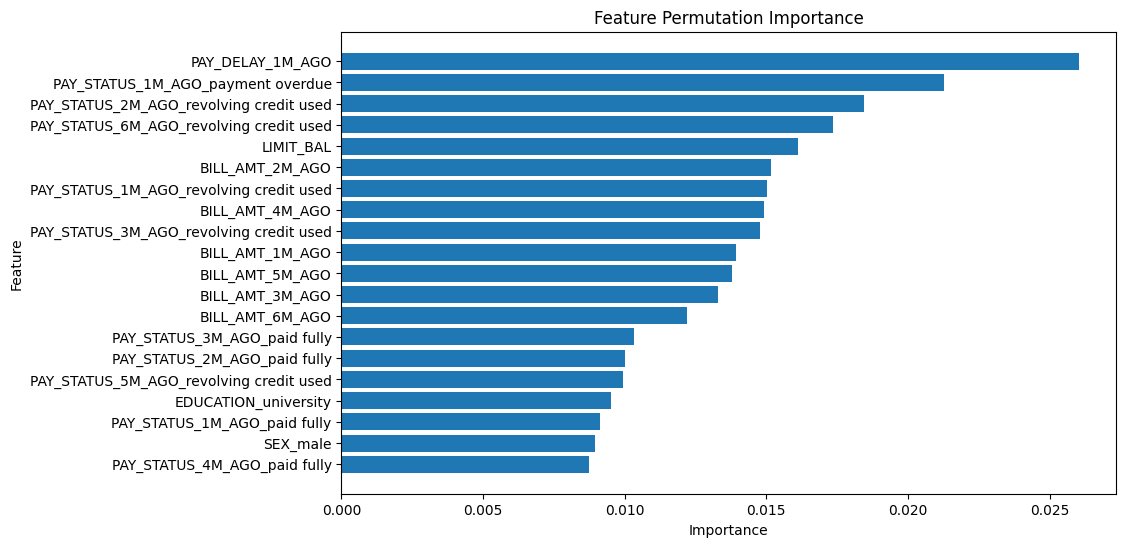

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_ST

In [ ]:
et_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   826  3851  822   501      50.12   62.25        82.41     77.95     55.53   
1   742  3909  764   585      49.27   55.92        83.65     77.52     52.38   
2   700  3991  682   627      50.65   52.75        85.41     78.18     51.68   
3   551  4171  502   776      52.33   41.52        89.26     78.70     46.30   
4   523  4232  441   804      54.25   39.41        90.56     79.25     45.66   
5   494  4256  417   833      54.23   37.23        91.08     79.17     44.15   
6   496  4250  423   831      53.97   37.38        90.95     79.10     44.17   
7   501  4247  426   826      54.05   37.75        90.88     79.13     44.45   
8   428  4315  358   899      54.45   32.25        92.34     79.05     40.51   
9   430  4316  357   897      54.64   32.40        92.36     79.10     40.68   
10  423  4318  355   904      54.37   31.88        92.40     79.02     40.19   
11  427  4318  355   900      54.60   32.18        92.40     79.08     40.49   
12  428  4316  357   899      54.52   32.25        92.36     79.07     40.53   
13  394  4338  335   933      54.05   29.69        92.83     78.87     38.33   
14  394  4341  332   933      54.27   29.69        92.90     78.92     38.38   
15  393  4341  332   934      54.21   29.62        92.90     78.90     38.30   
16  240  4572  101  1087      70.38   18.09        97.84     80.20     28.78   
17  225  4576   97  1102      69.88   16.96        97.92     80.02     27.29   
18  231  4568  105  1096      68.75   17.41        97.75     79.98     27.78   
19  222  4572  101  1105      68.73   16.73        97.84     79.90     26.91   
20  223  4574   99  1104      69.25   16.80        97.88     79.95     27.05   

    balanced_accuracy  num_feat_missing  \
0               72.33                 0   
1               69.78                 1   
2               69.08                 2   
3               65.39                 3   
4               64.99                 4   
5               64.15                 5   
6               64.16                 6   
7               64.32                 7   
8               62.30                 8   
9               62.38                 9   
10              62.14                10   
11              62.29                11   
12              62.31                12   
13              61.26                13   
14              61.29                14   
15              61.26                15   
16              57.96                16   
17              57.44                17   
18              57.58                18   
19              57.28                19   
20              57.34                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:03:05.993351

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
et_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   826  3851  822  501      50.12   62.25        82.41     77.95     55.53   
1   749  3874  799  578      48.39   56.44        82.90     77.05     52.10   
2   731  3905  768  596      48.77   55.09        83.57     77.27     51.73   
3   632  4034  639  695      49.72   47.63        86.33     77.77     48.65   
4   600  4135  538  727      52.72   45.21        88.49     78.92     48.68   
5   590  4139  534  737      52.49   44.46        88.57     78.82     48.14   
6   593  4140  533  734      52.66   44.69        88.59     78.88     48.35   
7   591  4137  536  736      52.44   44.54        88.53     78.80     48.17   
8   567  4216  457  760      55.37   42.73        90.22     79.72     48.23   
9   570  4220  453  757      55.72   42.95        90.31     79.83     48.51   
10  574  4219  454  753      55.84   43.26        90.28     79.88     48.75   
11  573  4213  460  754      55.47   43.18        90.16     79.77     48.56   
12  575  4215  458  752      55.66   43.33        90.20     79.83     48.73   
13  541  4242  431  786      55.66   40.77        90.78     79.72     47.06   
14  542  4235  438  785      55.31   40.84        90.63     79.62     46.99   
15  553  4221  452  774      55.02   41.67        90.33     79.57     47.43   
16  489  4364  309  838      61.28   36.85        93.39     80.88     46.02   
17  484  4368  305  843      61.34   36.47        93.47     80.87     45.75   
18  483  4363  310  844      60.91   36.40        93.37     80.77     45.57   
19  397  4478  195  930      67.06   29.92        95.83     81.25     41.38   
20  399  4475  198  928      66.83   30.07        95.76     81.23     41.48   

    balanced_accuracy  num_feat_missing  \
0               72.33                 0   
1               69.67                 1   
2               69.33                 2   
3               66.98                 3   
4               66.85                 4   
5               66.52                 5   
6               66.64                 6   
7               66.53                 7   
8               66.47                 8   
9               66.63                 9   
10              66.77                10   
11              66.67                11   
12              66.76                12   
13              65.77                13   
14              65.74                14   
15              66.00                15   
16              65.12                16   
17              64.97                17   
18              64.88                18   
19              62.87                19   
20              62.92                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
et_perf_temp, et_orig_missing_temp, et_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
et_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  826  3851  822   501      50.12   62.25        82.41     77.95     55.53   
1  673  4034  639   654      51.30   50.72        86.33     78.45     51.00   
2  503  4200  473   824      51.54   37.91        89.88     78.38     43.68   
3  453  4280  393   874      53.55   34.14        91.59     78.88     41.69   
4  423  4294  379   904      52.74   31.88        91.89     78.62     39.74   
5  317  4470  203  1010      60.96   23.89        95.66     79.78     34.33   
6   56  4638   35  1271      61.54    4.22        99.25     78.23      7.90   

   balanced_accuracy  num_feat_missing  \
0              72.33                 0   
1              68.52                 4   
2              63.89                 8   
3              62.86                12   
4              61.88                13   
5              59.77                17   
6              51.74                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_temp_mf, et_orig_missing_temp_mf, et_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:09:54.022927

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
et_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  826  3851  822   501      50.12   62.25        82.41     77.95     55.53   
1  707  3954  719   620      49.58   53.28        84.61     77.68     51.36   
2  563  4125  548   764      50.68   42.43        88.27     78.13     46.19   
3  520  4203  470   807      52.53   39.19        89.94     78.72     44.89   
4  514  4200  473   813      52.08   38.73        89.88     78.57     44.43   
5  468  4300  373   859      55.65   35.27        92.02     79.47     43.17   
6   78  4632   41  1249      65.55    5.88        99.12     78.50     10.79   

   balanced_accuracy  num_feat_missing  \
0              72.33                 0   
1              68.95                 4   
2              65.35                 8   
3              64.56                12   
4              64.31                13   
5              63.64                17   
6              52.50                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, default_cc_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = default_cc_scaler)

In [ ]:
default_cc_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
default_cc_imputation_scaled_values_dict

{'LIMIT_BAL': 0.1313131313131313,
 'AGE': 0.2241379310344827,
 'BILL_AMT_1M_AGO': 0.16635872686358888,
 'BILL_AMT_2M_AGO': 0.08633084307986652,
 'BILL_AMT_3M_AGO': 0.22469070891480478,
 'BILL_AMT_4M_AGO': 0.17808448868014462,
 'BILL_AMT_5M_AGO': 0.09858453850005702,
 'BILL_AMT_6M_AGO': 0.27400141554346646,
 'PAY_AMT_1M_AGO': 0.0024039782405626685,
 'PAY_AMT_2M_AGO': 0.001632327749897725,
 'PAY_AMT_3M_AGO': 0.002008838891120932,
 'PAY_AMT_4M_AGO': 0.0024154589371980675,
 'PAY_AMT_5M_AGO': 0.0035167597044984044,
 'PAY_AMT_6M_AGO': 0.0028373301857883807,
 'PAY_DELAY_1M_AGO': 0.0,
 'PAY_DELAY_2M_AGO': 0.0,
 'PAY_DELAY_3M_AGO': 0.0,
 'PAY_DELAY_4M_AGO': 0.0,
 'PAY_DELAY_5M_AGO': 0.0,
 'PAY_DELAY_6M_AGO': 0.0,
 'SEX_male': 0.0,
 'EDUCATION_high school': 0.0,
 'EDUCATION_others': 0.0,
 'EDUCATION_university': 0.0,
 'MARRIAGE_married': 0.0,
 'MARRIAGE_others': 0.0,
 'MARRIAGE_single': 1.0,
 'PAY_STATUS_1M_AGO_paid fully': 0.0,
 'PAY_STATUS_1M_AGO_payment overdue': 0.0,
 'PAY_STATUS_1M_AGO_revo

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1]
  }
else:
  # best model
  svm_param_grid = {
      'C': [1.0],
      'kernel': ['rbf'],
      'gamma': ['scale']
}

svm_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 10:46:11.616368

Nested Cross-validation Results:
Individual scores: [0.52985449 0.51385651 0.52694301]
Average nested CV score: 0.524 (+/- 0.014)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.524
2025-01-18 10:47:41.428544

Execution time: 1.50 minutes


```
Starting hyperparameter tuning at: 2025-01-17 10:43:44.135616

Nested Cross-validation Results:
Individual scores: [0.52892972 0.51752306 0.52390962]
Average nested CV score: 0.523 (+/- 0.009)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.524
2025-01-17 11:06:56.860720

Execution time: 23.21 minutes
```




In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1", n_repeats=3)
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.099945  0.001667
34        PAY_STATUS_3M_AGO_payment overdue    0.037377  0.002388
31        PAY_STATUS_2M_AGO_payment overdue    0.021944  0.001422
32  PAY_STATUS_2M_AGO_revolving credit used    0.008019  0.000406
37        PAY_STATUS_4M_AGO_payment overdue    0.007796  0.001003
42             PAY_STATUS_6M_AGO_paid fully    0.002950  0.000399
39             PAY_STATUS_5M_AGO_paid fully    0.002653  0.000132
22                         EDUCATION_others    0.002614  0.000371
26                          MARRIAGE_single    0.002491  0.000297
24                         MARRIAGE_married    0.002247  0.000482
38  PAY_STATUS_4M_AGO_revolving credit used    0.002137  0.000419
36             PAY_STATUS_4M_AGO_paid fully    0.002054  0.000153
20                                 SEX_male    0.001981  0.000068
33             PAY_STATUS_3M_AGO_paid fully    0.001650  0.000698
44  PAY_STATUS_6M_AGO_revolving credit used    0.001459  0.000390
35  PAY_STATUS_3M_AGO_revolving credit used    0.001335  0.000066
29  PAY_STATUS_1M_AGO_revolving credit used    0.001210  0.000590
30             PAY_STATUS_2M_AGO_paid fully    0.000975  0.000169
1                                       AGE    0.000914  0.000248
21                    EDUCATION_high school    0.000803  0.000710
40        PAY_STATUS_5M_AGO_payment overdue    0.000763  0.000399
23                     EDUCATION_university    0.000504  0.000141
0                                 LIMIT_BAL    0.000424  0.000119
18                         PAY_DELAY_5M_AGO    0.000197  0.000057
17                         PAY_DELAY_4M_AGO    0.000135  0.000077
27             PAY_STATUS_1M_AGO_paid fully    0.000100  0.000399
25                          MARRIAGE_others    0.000092  0.000000
43        PAY_STATUS_6M_AGO_payment overdue    0.000057  0.000308
6                           BILL_AMT_5M_AGO    0.000042  0.000032
14                         PAY_DELAY_1M_AGO    0.000019  0.000196
8                            PAY_AMT_1M_AGO    0.000015  0.000043
19                         PAY_DELAY_6M_AGO   -0.000003  0.000080
9                            PAY_AMT_2M_AGO   -0.000015  0.000022
11                           PAY_AMT_4M_AGO   -0.000015  0.000022
16                         PAY_DELAY_3M_AGO   -0.000043  0.000026
3                           BILL_AMT_2M_AGO   -0.000046  0.000038
12                           PAY_AMT_5M_AGO   -0.000046  0.000065
5                           BILL_AMT_4M_AGO   -0.000051  0.000095
2                           BILL_AMT_1M_AGO   -0.000057  0.000051
13                           PAY_AMT_6M_AGO   -0.000061  0.000022
7                           BILL_AMT_6M_AGO   -0.000061  0.000022
41  PAY_STATUS_5M_AGO_revolving credit used   -0.000142  0.000340
4                           BILL_AMT_3M_AGO   -0.000169  0.000167
15                         PAY_DELAY_2M_AGO   -0.000243  0.000039

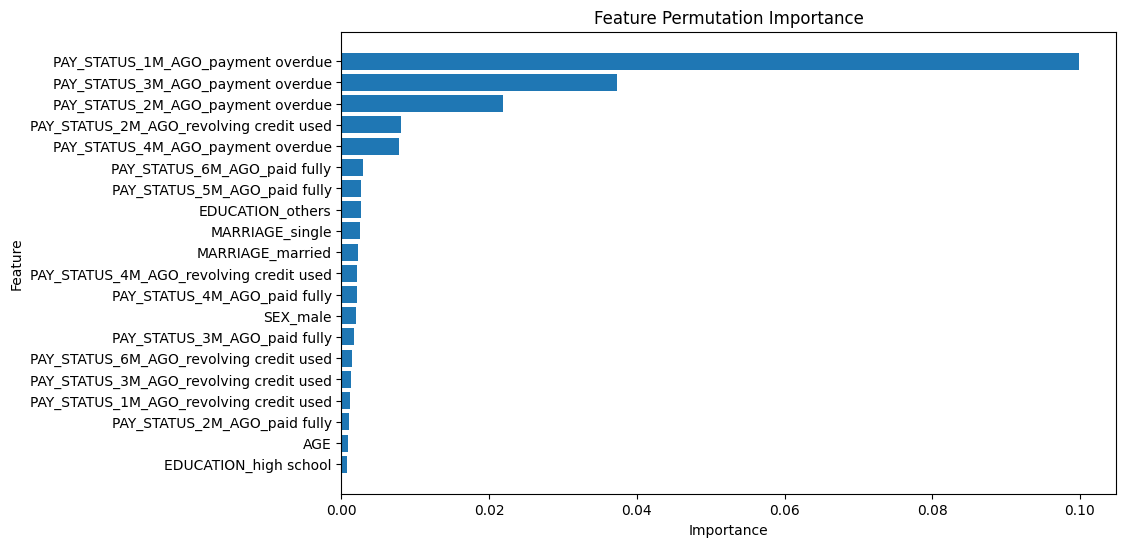

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  

In [ ]:
svm_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   805  3869  804   522      50.03   60.66        82.79     77.90     54.84   
1   662  4035  638   665      50.92   49.89        86.35     78.28     50.40   
2   633  4137  536   694      54.15   47.70        88.53     79.50     50.72   
3   414  4343  330   913      55.65   31.20        92.94     79.28     39.98   
4   274  4514  159  1053      63.28   20.65        96.60     79.80     31.14   
5   120  4624   49  1207      71.01    9.04        98.95     79.07     16.04   
6    38  4651   22  1289      63.33    2.86        99.53     78.15      5.48   
7    39  4650   23  1288      62.90    2.94        99.51     78.15      5.62   
8    24  4657   16  1303      60.00    1.81        99.66     78.02      3.51   
9    23  4657   16  1304      58.97    1.73        99.66     78.00      3.37   
10   26  4656   17  1301      60.47    1.96        99.64     78.03      3.80   
11   25  4657   16  1302      60.98    1.88        99.66     78.03      3.65   
12   23  4661   12  1304      65.71    1.73        99.74     78.07      3.38   
13   12  4664    9  1315      57.14    0.90        99.81     77.93      1.78   
14   12  4664    9  1315      57.14    0.90        99.81     77.93      1.78   
15    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
16    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
17    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.73                 0   
1               68.12                 1   
2               68.12                 2   
3               62.07                 3   
4               58.62                 4   
5               54.00                 5   
6               51.20                 6   
7               51.22                 7   
8               50.73                 8   
9               50.70                 9   
10              50.80                10   
11              50.77                11   
12              50.74                12   
13              50.36                13   
14              50.36                14   
15              50.04                15   
16              50.04                16   
17              50.04                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:13:41.657502

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   805  3869  804   522      50.03   60.66        82.79     77.90     54.84   
1   684  3971  702   643      49.35   51.54        84.98     77.58     50.42   
2   689  3896  777   638      47.00   51.92        83.37     76.42     49.34   
3   425  4322  351   902      54.77   32.03        92.49     79.12     40.42   
4   242  4529  144  1085      62.69   18.24        96.92     79.52     28.25   
5    17  4666    7  1310      70.83    1.28        99.85     78.05      2.52   
6    14  4669    4  1313      77.78    1.06        99.91     78.05      2.08   
7    14  4669    4  1313      77.78    1.06        99.91     78.05      2.08   
8     5  4669    4  1322      55.56    0.38        99.91     77.90      0.75   
9     5  4669    4  1322      55.56    0.38        99.91     77.90      0.75   
10    5  4669    4  1322      55.56    0.38        99.91     77.90      0.75   
11    6  4669    4  1321      60.00    0.45        99.91     77.92      0.90   
12    5  4669    4  1322      55.56    0.38        99.91     77.90      0.75   
13    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
14    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
15    2  4672    1  1325      66.67    0.15        99.98     77.90      0.30   
16    1  4672    1  1326      50.00    0.08        99.98     77.88      0.15   
17    1  4672    1  1326      50.00    0.08        99.98     77.88      0.15   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.73                 0   
1               68.26                 1   
2               67.65                 2   
3               62.26                 3   
4               57.58                 4   
5               50.57                 5   
6               50.48                 6   
7               50.48                 7   
8               50.15                 8   
9               50.15                 9   
10              50.15                10   
11              50.18                11   
12              50.15                12   
13              50.03                13   
14              50.03                14   
15              50.06                15   
16              50.03                16   
17              50.03                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm_perf_temp, svm_orig_missing_temp, svm_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   805  3869   804  522      50.03   60.66        82.79     77.90     54.84   
1  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
2  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
3  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
4  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   
5  1327     0  4673    0      22.12  100.00         0.00     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              71.73                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_temp_mf, svm_orig_missing_temp_mf, svm_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:22:53.605426

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  805  3869  804   522      50.03   60.66        82.79     77.90     54.84   
1  680  3972  701   647      49.24   51.24        85.00     77.53     50.22   
2  686  3898  775   641      46.95   51.70        83.42     76.40     49.21   
3  403  4328  345   924      53.88   30.37        92.62     78.85     38.84   
4  211  4544  129  1116      62.06   15.90        97.24     79.25     25.31   
5    2  4673    0  1325     100.00    0.15       100.00     77.92      0.30   

   balanced_accuracy  num_feat_missing  \
0              71.73                 0   
1              68.12                 4   
2              67.56                 8   
3              61.49                12   
4              56.57                16   
5              50.08                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**##

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicollinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_default_cc_dist_corr = default_cc_dist_corr[present_features]
filtered_default_cc_dist_corr = filtered_default_cc_dist_corr[filtered_default_cc_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_default_cc_dist_corr, 'Target', 0.8)

appended feature:  PAY_DELAY_1M_AGO
eliminated feature:  PAY_STATUS_1M_AGO_payment overdue 0.9601537558986976
appended feature:  PAY_DELAY_2M_AGO
eliminated feature:  PAY_STATUS_2M_AGO_payment overdue 0.9976632389218033
appended feature:  PAY_DELAY_3M_AGO
eliminated feature:  PAY_STATUS_3M_AGO_payment overdue 0.9986562162604087
appended feature:  PAY_DELAY_4M_AGO
eliminated feature:  PAY_STATUS_4M_AGO_payment overdue 0.9980311533270702
appended feature:  PAY_DELAY_5M_AGO
eliminated feature:  PAY_STATUS_5M_AGO_payment overdue 0.997705460763519
appended feature:  PAY_DELAY_6M_AGO
eliminated feature:  PAY_STATUS_6M_AGO_payment overdue 0.9981924439263611
appended feature:  PAY_STATUS_1M_AGO_revolving credit used
eliminated feature:  PAY_STATUS_2M_AGO_revolving credit used 0.8708329853634604
appended feature:  LIMIT_BAL
appended feature:  PAY_AMT_2M_AGO
appended feature:  PAY_AMT_1M_AGO
appended feature:  PAY_STATUS_3M_AGO_revolving credit used
appended feature:  PAY_AMT_3M_AGO
appended fea

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]
print('Nr features for LR: ', len(lr_X_train.columns))

Nr features for LR:  33


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:08:35.851783

Nested Cross-validation Results:
Individual scores: [0.53968254 0.52200772 0.52363636]
Average nested CV score: 0.528 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.528
2025-01-18 11:08:39.188037

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 03:57:15.783187

Nested Cross-validation Results:
Individual scores: [0.53885481 0.52117769 0.52338877]
Average nested CV score: 0.528 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.528
2025-01-17 03:57:38.908350

Execution time: 0.39 minutes
```

In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.126976  0.004011
7                                 LIMIT_BAL    0.018956  0.000841
2                          PAY_DELAY_3M_AGO    0.011977  0.001153
28                          BILL_AMT_1M_AGO    0.008765  0.002077
22             PAY_STATUS_1M_AGO_paid fully    0.007695  0.000689
3                          PAY_DELAY_4M_AGO    0.005599  0.000979
19             PAY_STATUS_2M_AGO_paid fully    0.004909  0.000529
21             PAY_STATUS_5M_AGO_paid fully    0.002543  0.000214
10  PAY_STATUS_3M_AGO_revolving credit used    0.002407  0.000231
26                                 SEX_male    0.001984  0.001375
23             PAY_STATUS_6M_AGO_paid fully    0.001586  0.000407
24                         EDUCATION_others    0.001539  0.000960
29                          MARRIAGE_single    0.001474  0.001047
31                          BILL_AMT_6M_AGO    0.001165  0.000381
20             PAY_STATUS_4M_AGO_paid fully    0.001157  0.000669
5                          PAY_DELAY_6M_AGO    0.001127  0.000321
6   PAY_STATUS_1M_AGO_revolving credit used    0.001116  0.001567
14                           PAY_AMT_5M_AGO    0.001025  0.000422
27                    EDUCATION_high school    0.001002  0.000138
18             PAY_STATUS_3M_AGO_paid fully    0.000576  0.000188
11                           PAY_AMT_3M_AGO    0.000505  0.000359
4                          PAY_DELAY_5M_AGO    0.000437  0.000211
9                            PAY_AMT_1M_AGO    0.000432  0.000888
32                          MARRIAGE_others    0.000413  0.000285
15                           PAY_AMT_6M_AGO    0.000336  0.000852
17  PAY_STATUS_6M_AGO_revolving credit used    0.000273  0.001472
30                                      AGE    0.000252  0.000376
8                            PAY_AMT_2M_AGO    0.000090  0.000661
25                     EDUCATION_university    0.000080  0.000256
13                           PAY_AMT_4M_AGO   -0.000114  0.000267
1                          PAY_DELAY_2M_AGO   -0.000356  0.000317
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000936  0.000603
16  PAY_STATUS_5M_AGO_revolving credit used   -0.001562  0.000896

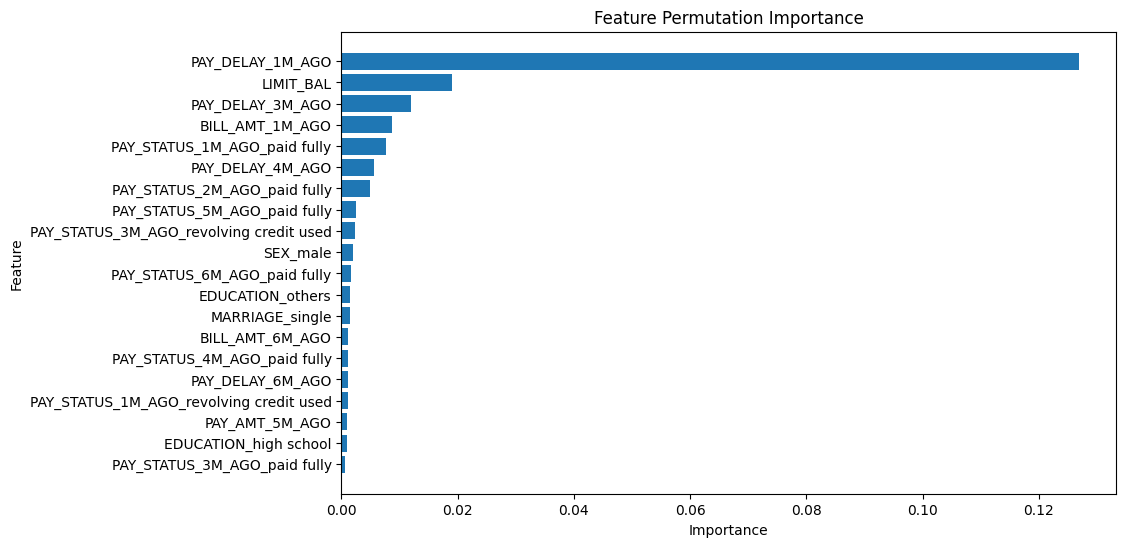

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'BILL_AMT_1M_AGO', 'PA

In [ ]:
lr_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1   482  4257  416   845      53.67   36.32        91.10     78.98     43.33   
2   444  4288  385   883      53.56   33.46        91.76     78.87     41.19   
3   332  4383  290   995      53.38   25.02        93.79     78.58     34.07   
4   306  4388  285  1021      51.78   23.06        93.90     78.23     31.91   
5   283  4450  223  1044      55.93   21.33        95.23     78.88     30.88   
6   176  4515  158  1151      52.69   13.26        96.62     78.18     21.19   
7   179  4503  170  1148      51.29   13.49        96.36     78.03     21.36   
8    82  4619   54  1245      60.29    6.18        98.84     78.35     11.21   
9   101  4597   76  1226      57.06    7.61        98.37     78.30     13.43   
10   45  4645   28  1282      61.64    3.39        99.40     78.17      6.43   
11   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
12   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
13   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
14   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
15    4  4673    0  1323     100.00    0.30       100.00     77.95      0.60   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               63.71                 1   
2               62.61                 2   
3               59.41                 3   
4               58.48                 4   
5               58.28                 5   
6               54.94                 6   
7               54.93                 7   
8               52.51                 8   
9               52.99                 9   
10              51.40                10   
11              50.45                11   
12              50.45                12   
13              50.45                13   
14              50.45                14   
15              50.15                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_X_train.columns

Index(['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO',
       'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO',
       'PAY_STATUS_1M_AGO_revolving credit used', 'LIMIT_BAL',
       'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO',
       'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_AMT_3M_AGO',
       'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_AMT_4M_AGO',
       'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO',
       'PAY_STATUS_5M_AGO_revolving credit used',
       'PAY_STATUS_6M_AGO_revolving credit used',
       'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully',
       'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully',
       'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully',
       'EDUCATION_others', 'EDUCATION_university', 'SEX_male',
       'EDUCATION_high school', 'BILL_AMT_1M_AGO', 'MARRIAGE_single', 'AGE',
       'BILL_AMT_6M_AGO', 'MARRIAGE_others'],
      dtype='object')

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_default_cc_cat_vars = [col for col in lr_X_train.columns if col in default_cc_cat_vars]

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:25:03.208751

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1   758  3811  862  569      46.79   57.12        81.55     76.15     51.44   
2   748  3862  811  579      47.98   56.37        82.64     76.83     51.84   
3   742  3846  827  585      47.29   55.92        82.30     76.47     51.24   
4   710  3949  724  617      49.51   53.50        84.51     77.65     51.43   
5   681  4001  672  646      50.33   51.32        85.62     78.03     50.82   
6   667  4045  628  660      51.51   50.26        86.56     78.53     50.88   
7   645  4093  580  682      52.65   48.61        87.59     78.97     50.55   
8   639  4107  566  688      53.03   48.15        87.89     79.10     50.47   
9   604  4220  453  723      57.14   45.52        90.31     80.40     50.67   
10  585  4244  429  742      57.69   44.08        90.82     80.48     49.98   
11  558  4307  366  769      60.39   42.05        92.17     81.08     49.58   
12  565  4298  375  762      60.11   42.58        91.98     81.05     49.85   
13  570  4291  382  757      59.87   42.95        91.83     81.02     50.02   
14  564  4295  378  763      59.87   42.50        91.91     80.98     49.71   
15  568  4294  379  759      59.98   42.80        91.89     81.03     49.96   
16  539  4341  332  788      61.88   40.62        92.90     81.33     49.04   
17  535  4340  333  792      61.64   40.32        92.87     81.25     48.75   
18  541  4331  342  786      61.27   40.77        92.68     81.20     48.96   
19  530  4339  334  797      61.34   39.94        92.85     81.15     48.38   
20  548  4313  360  779      60.35   41.30        92.30     81.02     49.04   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               69.34                 1   
2               69.51                 2   
3               69.11                 3   
4               69.01                 4   
5               68.47                 5   
6               68.41                 6   
7               68.10                 7   
8               68.02                 8   
9               67.91                 9   
10              67.45                10   
11              67.11                11   
12              67.28                12   
13              67.39                13   
14              67.21                14   
15              67.35                15   
16              66.76                16   
17              66.60                17   
18              66.73                18   
19              66.40                19   
20              66.80                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr_perf_temp, lr_orig_missing_temp, lr_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879   794   520      50.41   60.81        83.01     78.10     55.12   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                17   
7              50.00                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_temp_mf, lr_orig_missing_temp_mf, lr_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:29:35.350572

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1  692  3928  745   635      48.16   52.15        84.06     77.00     50.07   
2  706  3906  767   621      47.93   53.20        83.59     76.87     50.43   
3  642  4119  554   685      53.68   48.38        88.14     79.35     50.89   
4  643  4109  564   684      53.27   48.46        87.93     79.20     50.75   
5  345  4393  280   982      55.20   26.00        94.01     78.97     35.35   
6  148  4574   99  1179      59.92   11.15        97.88     78.70     18.81   
7  121  4600   73  1206      62.37    9.12        98.44     78.68     15.91   
8    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              68.10                 4   
2              68.39                 5   
3              68.26                 8   
4              68.19                11   
5              60.00                14   
6              54.52                17   
7              53.78                18   
8              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Models optimized for Balanced Accuracy**

## **Decision Tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [None],
      'min_samples_split': [0.05],
      'min_samples_leaf': [1]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:12:33.481676

Nested Cross-validation Results:
Individual scores: [0.70845294 0.69700148 0.69376944]
Average nested CV score: 0.700 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.700
2025-01-18 11:12:34.779751

Execution time: 0.02 minutes


```
Starting hyperparameter tuning at: 2025-01-17 04:39:35.031342

Nested Cross-validation Results:
Individual scores: [0.70843611 0.69159434 0.69507305]
Average nested CV score: 0.698 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.05}

Best Model Performance:
Best CV score: 0.700
2025-01-17 04:40:21.342977

Execution time: 0.77 minutes
```

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28  PAY_STATUS_1M_AGO_payment overdue    0.059695  0.001770
17                   PAY_DELAY_4M_AGO    0.022094  0.000634
8                      PAY_AMT_1M_AGO    0.015162  0.002178
14                   PAY_DELAY_1M_AGO    0.013783  0.000727
0                           LIMIT_BAL    0.012118  0.000640
16                   PAY_DELAY_3M_AGO    0.011258  0.000927
36       PAY_STATUS_4M_AGO_paid fully    0.009214  0.001374
12                     PAY_AMT_5M_AGO    0.008385  0.000748
9                      PAY_AMT_2M_AGO    0.008158  0.000761
3                     BILL_AMT_2M_AGO    0.006492  0.000223
10                     PAY_AMT_3M_AGO    0.005011  0.000551
5                     BILL_AMT_4M_AGO    0.004097  0.000091
11                     PAY_AMT_4M_AGO    0.003581  0.000980
22                   EDUCATION_others    0.003247  0.000677
13                     PAY_AMT_6M_AGO    0.002003  0.000495
15                   PAY_DELAY_2M_AGO    0.001715  0.000400
37  PAY_STATUS_4M_AGO_payment overdue    0.001550  0.000165
7                     BILL_AMT_6M_AGO    0.000659  0.000315
1                                 AGE    0.000199  0.000053
25                    MARRIAGE_others    0.000134  0.000149
4                     BILL_AMT_3M_AGO    0.000102  0.000073
2                     BILL_AMT_1M_AGO    0.000032  0.000011
43  PAY_STATUS_6M_AGO_payment overdue    0.000014  0.000046

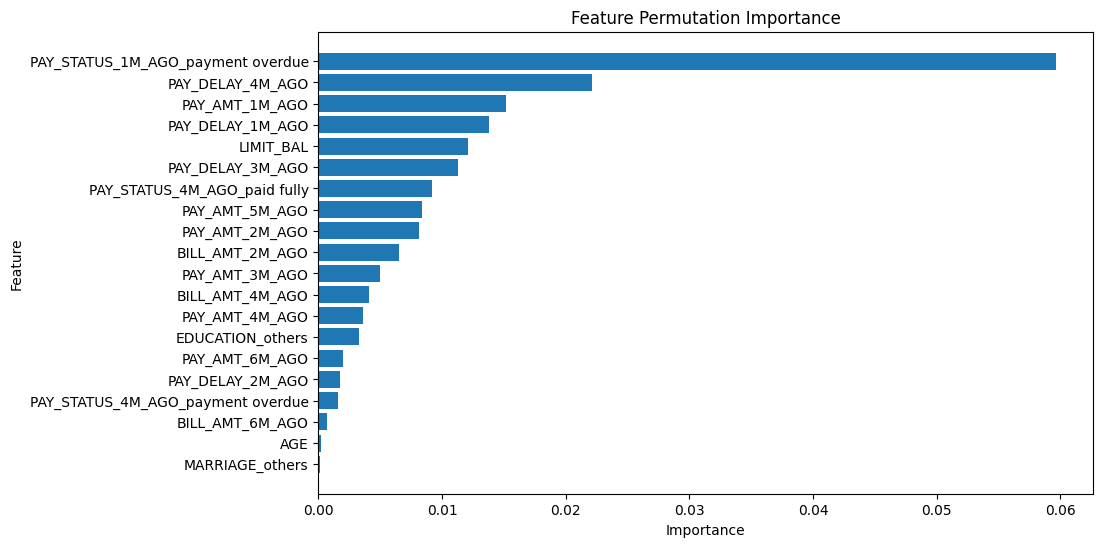

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_STATUS_1

In [ ]:
dt2_perf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1   744  3545  1128   583      39.74   56.07        75.86     71.48     46.51   
2   532  3742   931   795      36.36   40.09        80.08     71.23     38.14   
3   338  4298   375   989      47.41   25.47        91.98     77.27     33.14   
4   338  4298   375   989      47.41   25.47        91.98     77.27     33.14   
5   332  4328   345   995      49.04   25.02        92.62     77.67     33.13   
6    25  4607    66  1302      27.47    1.88        98.59     77.20      3.53   
7    25  4607    66  1302      27.47    1.88        98.59     77.20      3.53   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
9     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
10    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
11    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
12    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
13    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
14    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               70.54                 0   
1               65.96                 1   
2               60.08                 2   
3               58.72                 3   
4               58.72                 4   
5               58.82                 5   
6               50.24                 6   
7               50.24                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:31:20.410573

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
dt2_perf_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1   750  3530  1143   577      39.62   56.52        75.54     71.33     46.58   
2   721  3595  1078   606      40.08   54.33        76.93     71.93     46.13   
3   697  3719   954   630      42.22   52.52        79.58     73.60     46.81   
4   697  3725   948   630      42.37   52.52        79.71     73.70     46.90   
5   670  3815   858   657      43.85   50.49        81.64     74.75     46.94   
6   463  4016   657   864      41.34   34.89        85.94     74.65     37.84   
7   475  3915   758   852      38.52   35.80        83.78     73.17     37.11   
8   458  3952   721   869      38.85   34.51        84.57     73.50     36.55   
9   264  4074   599  1063      30.59   19.89        87.18     72.30     24.11   
10  201  4283   390  1126      34.01   15.15        91.65     74.73     20.96   
11  154  4340   333  1173      31.62   11.61        92.87     74.90     16.98   
12  148  4354   319  1179      31.69   11.15        93.17     75.03     16.50   
13  144  4352   321  1183      30.97   10.85        93.13     74.93     16.07   
14  115  4505   168  1212      40.64    8.67        96.40     77.00     14.29   
15  115  4500   173  1212      39.93    8.67        96.30     76.92     14.24   
16   95  4531   142  1232      40.08    7.16        96.96     77.10     12.15   
17  102  4532   141  1225      41.98    7.69        96.98     77.23     12.99   
18   94  4531   142  1233      39.83    7.08        96.96     77.08     12.03   
19  106  4534   139  1221      43.27    7.99        97.03     77.33     13.49   
20   98  4588    85  1229      53.55    7.39        98.18     78.10     12.98   

    balanced_accuracy  num_feat_missing  \
0               70.54                 0   
1               66.03                 1   
2               65.63                 2   
3               66.05                 3   
4               66.12                 4   
5               66.06                 5   
6               60.42                 6   
7               59.79                 7   
8               59.54                 8   
9               53.54                 9   
10              53.40                10   
11              52.24                11   
12              52.16                12   
13              51.99                13   
14              52.54                14   
15              52.48                15   
16              52.06                16   
17              52.33                17   
18              52.02                18   
19              52.51                19   
20              52.78                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
dt2_perf_temp, dt2_orig_missing_temp, dt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
dt2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1  550  4101   572   777      49.02   41.45        87.76     77.52     44.92   
2  337  4303   370   990      47.67   25.40        92.08     77.33     33.14   
3  332  4328   345   995      49.04   25.02        92.62     77.67     33.13   
4   25  4601    72  1302      25.77    1.88        98.46     77.10      3.51   
5    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              70.54                 0   
1              64.60                 4   
2              58.74                 8   
3              58.82                 9   
4              50.17                13   
5              50.00                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_temp_mf, dt2_orig_missing_temp_mf, dt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:37:53.503093

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
dt2_perf_temp_mf

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  901  3420  1253   426      41.83   67.90        73.19     72.02     51.77   
1  728  3650  1023   599      41.58   54.86        78.11     72.97     47.30   
2  707  3633  1040   620      40.47   53.28        77.74     72.33     46.00   
3  678  3708   965   649      41.27   51.09        79.35     73.10     45.66   
4  334  4369   304   993      52.35   25.17        93.49     78.38     33.99   
5  293  4399   274  1034      51.68   22.08        94.14     78.20     30.94   
6   14  4665     8  1313      63.64    1.06        99.83     77.98      2.08   

   balanced_accuracy  num_feat_missing  \
0              70.54                 0   
1              66.48                 4   
2              65.51                 8   
3              65.22                 9   
4              59.33                13   
5              58.11                17   
6              50.44                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.001],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:19:17.374851

Nested Cross-validation Results:
Individual scores: [0.72346214 0.70587507 0.70996454]
Average nested CV score: 0.713 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.713
2025-01-18 11:19:30.699502

Execution time: 0.22 minutes


CV 3x3
```
Starting hyperparameter tuning at: 2025-01-17 04:45:46.393062

Nested Cross-validation Results:
Individual scores: [0.7229746  0.70656202 0.70694017]
Average nested CV score: 0.712 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.713
2025-01-17 06:32:43.939160

Execution time: 106.96 minutes
```

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.020100  0.001759
2                           BILL_AMT_1M_AGO    0.012125  0.000810
10                           PAY_AMT_3M_AGO    0.009337  0.000342
11                           PAY_AMT_4M_AGO    0.006682  0.001020
6                           BILL_AMT_5M_AGO    0.006643  0.000485
8                            PAY_AMT_1M_AGO    0.006099  0.001132
0                                 LIMIT_BAL    0.005882  0.000828
9                            PAY_AMT_2M_AGO    0.005049  0.000640
5                           BILL_AMT_4M_AGO    0.005011  0.000603
13                           PAY_AMT_6M_AGO    0.003777  0.000954
12                           PAY_AMT_5M_AGO    0.003727  0.000625
7                           BILL_AMT_6M_AGO    0.003029  0.000186
3                           BILL_AMT_2M_AGO    0.002843  0.000517
1                                       AGE    0.002059  0.000652
16                         PAY_DELAY_3M_AGO    0.002050  0.000393
27             PAY_STATUS_1M_AGO_paid fully    0.001819  0.000438
4                           BILL_AMT_3M_AGO    0.001721  0.000175
29  PAY_STATUS_1M_AGO_revolving credit used    0.001711  0.000478
34        PAY_STATUS_3M_AGO_payment overdue    0.001580  0.000556
32  PAY_STATUS_2M_AGO_revolving credit used    0.001169  0.000441
33             PAY_STATUS_3M_AGO_paid fully    0.000648  0.000158
37        PAY_STATUS_4M_AGO_payment overdue    0.000616  0.000462
20                                 SEX_male    0.000573  0.000345
23                     EDUCATION_university    0.000490  0.000223
36             PAY_STATUS_4M_AGO_paid fully    0.000467  0.000170
41  PAY_STATUS_5M_AGO_revolving credit used    0.000414  0.000245
35  PAY_STATUS_3M_AGO_revolving credit used    0.000411  0.000181
44  PAY_STATUS_6M_AGO_revolving credit used    0.000368  0.000413
43        PAY_STATUS_6M_AGO_payment overdue    0.000361  0.000204
19                         PAY_DELAY_6M_AGO    0.000274  0.000167
22                         EDUCATION_others    0.000263  0.000101
39             PAY_STATUS_5M_AGO_paid fully    0.000206  0.000228
21                    EDUCATION_high school    0.000199  0.000162
30             PAY_STATUS_2M_AGO_paid fully    0.000174  0.000138
24                         MARRIAGE_married    0.000151  0.000171
42             PAY_STATUS_6M_AGO_paid fully    0.000132  0.000233
26                          MARRIAGE_single    0.000083  0.000137
40        PAY_STATUS_5M_AGO_payment overdue   -0.000060  0.000401
18                         PAY_DELAY_5M_AGO   -0.000160  0.000360
17                         PAY_DELAY_4M_AGO   -0.000176  0.000371
15                         PAY_DELAY_2M_AGO   -0.000318  0.000583
38  PAY_STATUS_4M_AGO_revolving credit used   -0.000517  0.000282
31        PAY_STATUS_2M_AGO_payment overdue   -0.000667  0.000496
28        PAY_STATUS_1M_AGO_payment overdue   -0.000888  0.000552

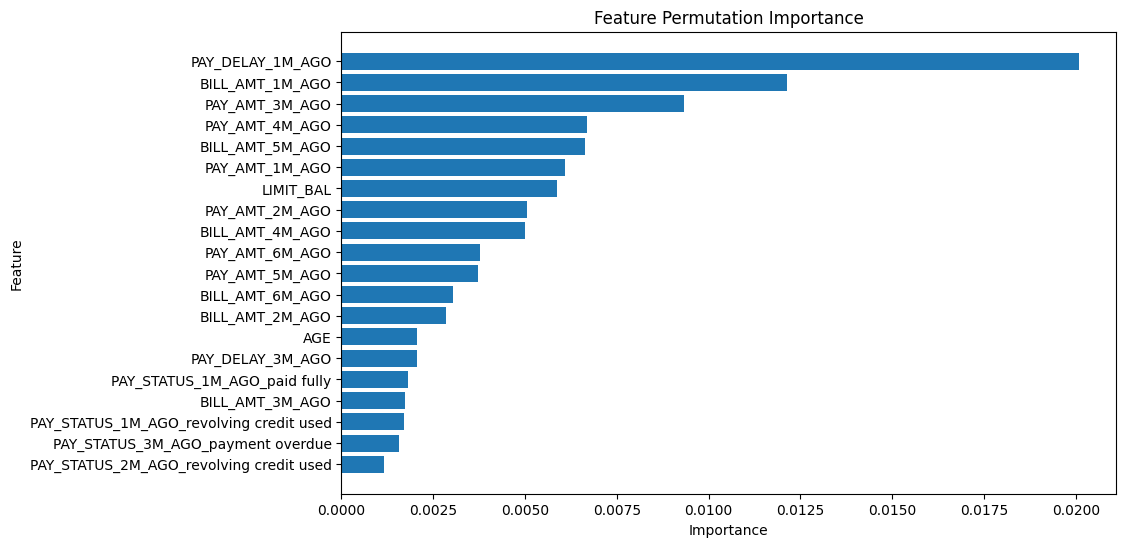

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_5M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_5M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat

In [ ]:
rf2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3850  823   490      50.42   63.07        82.39     78.12     56.04   
1   790  3908  765   537      50.80   59.53        83.63     78.30     54.82   
2   729  4050  623   598      53.92   54.94        86.67     79.65     54.42   
3   691  4112  561   636      55.19   52.07        87.99     80.05     53.59   
4   685  4143  530   642      56.38   51.62        88.66     80.47     53.89   
5   678  4151  522   649      56.50   51.09        88.83     80.48     53.66   
6   669  4171  502   658      57.13   50.41        89.26     80.67     53.56   
7   608  4243  430   719      58.57   45.82        90.80     80.85     51.42   
8   612  4245  428   715      58.85   46.12        90.84     80.95     51.71   
9   612  4251  422   715      59.19   46.12        90.97     81.05     51.84   
10  621  4252  421   706      59.60   46.80        90.99     81.22     52.43   
11  617  4250  423   710      59.33   46.50        90.95     81.12     52.13   
12  600  4257  416   727      59.06   45.21        91.10     80.95     51.22   
13  589  4265  408   738      59.08   44.39        91.27     80.90     50.69   
14  582  4273  400   745      59.27   43.86        91.44     80.92     50.41   
15  565  4315  358   762      61.21   42.58        92.34     81.33     50.22   
16  410  4417  256   917      61.56   30.90        94.52     80.45     41.14   
17  412  4417  256   915      61.68   31.05        94.52     80.48     41.30   
18  413  4425  248   914      62.48   31.12        94.69     80.63     41.55   
19  306  4498  175  1021      63.62   23.06        96.26     80.07     33.85   
20  260  4534  139  1067      65.16   19.59        97.03     79.90     30.13   

    balanced_accuracy  num_feat_missing  \
0               72.73                 0   
1               71.58                 1   
2               70.80                 2   
3               70.03                 3   
4               70.14                 4   
5               69.96                 5   
6               69.84                 6   
7               68.31                 7   
8               68.48                 8   
9               68.54                 9   
10              68.89                10   
11              68.72                11   
12              68.16                12   
13              67.83                13   
14              67.65                14   
15              67.46                15   
16              62.71                16   
17              62.78                17   
18              62.91                18   
19              59.66                19   
20              58.31                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:39:52.229228

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
rf2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   837  3850  823  490      50.42   63.07        82.39     78.12     56.04   
1   807  3843  830  520      49.30   60.81        82.24     77.50     54.45   
2   792  3906  767  535      50.80   59.68        83.59     78.30     54.89   
3   771  3960  713  556      51.95   58.10        84.74     78.85     54.86   
4   739  4030  643  588      53.47   55.69        86.24     79.48     54.56   
5   708  4086  587  619      54.67   53.35        87.44     79.90     54.00   
6   699  4085  588  628      54.31   52.68        87.42     79.73     53.48   
7   682  4115  558  645      55.00   51.39        88.06     79.95     53.14   
8   675  4124  549  652      55.15   50.87        88.25     79.98     52.92   
9   678  4123  550  649      55.21   51.09        88.23     80.02     53.07   
10  666  4140  533  661      55.55   50.19        88.59     80.10     52.73   
11  653  4150  523  674      55.53   49.21        88.81     80.05     52.18   
12  644  4167  506  683      56.00   48.53        89.17     80.18     52.00   
13  636  4177  496  691      56.18   47.93        89.39     80.22     51.73   
14  628  4190  483  699      56.53   47.32        89.66     80.30     51.52   
15  624  4200  473  703      56.88   47.02        89.88     80.40     51.49   
16  565  4262  411  762      57.89   42.58        91.20     80.45     49.07   
17  619  4174  499  708      55.37   46.65        89.32     79.88     50.63   
18  615  4197  476  712      56.37   46.35        89.81     80.20     50.87   
19  482  4315  358  845      57.38   36.32        92.34     79.95     44.49   
20  463  4351  322  864      58.98   34.89        93.11     80.23     43.84   

    balanced_accuracy  num_feat_missing  \
0               72.73                 0   
1               71.53                 1   
2               71.64                 2   
3               71.42                 3   
4               70.96                 4   
5               70.40                 5   
6               70.05                 6   
7               69.73                 7   
8               69.56                 8   
9               69.66                 9   
10              69.39                10   
11              69.01                11   
12              68.85                12   
13              68.66                13   
14              68.49                14   
15              68.45                15   
16              66.89                16   
17              67.98                17   
18              68.08                18   
19              64.33                19   
20              64.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2     ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
4   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
5   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
6   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
7   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
8   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
9   ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
10  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
11  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
12  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
13  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
14  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
15  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
16  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
17  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
18  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
19  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...  
20  ['PAY_DELAY_1M_AGO', 'BILL_AMT_1M_AGO', 'PAY_A...

In [ ]:
rf2_perf_temp, rf2_orig_missing_temp, rf2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
rf2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  837  3850  823   490      50.42   63.07        82.39     78.12     56.04   
1  573  4214  459   754      55.52   43.18        90.18     79.78     48.58   
2  486  4336  337   841      59.05   36.62        92.79     80.37     45.21   
3  396  4428  245   931      61.78   29.84        94.76     80.40     40.24   
4  330  4508  165   997      66.67   24.87        96.47     80.63     36.22   
5  251  4558  115  1076      68.58   18.91        97.54     80.15     29.65   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.73                 0   
1              66.68                 4   
2              64.71                 8   
3              62.30                12   
4              60.67                16   
5              58.23                17   
6              50.00                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_temp_mf, rf2_orig_missing_temp_mf, rf2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:46:21.212466

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
rf2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  837  3850  823   490      50.42   63.07        82.39     78.12     56.04   
1  676  4054  619   651      52.20   50.94        86.75     78.83     51.56   
2  655  4118  555   672      54.13   49.36        88.12     79.55     51.64   
3  577  4265  408   750      58.58   43.48        91.27     80.70     49.91   
4  525  4330  343   802      60.48   39.56        92.66     80.92     47.84   
5  508  4334  339   819      59.98   38.28        92.75     80.70     46.73   
6   61  4615   58  1266      51.26    4.60        98.76     77.93      8.44   

   balanced_accuracy  num_feat_missing  \
0              72.73                 0   
1              68.85                 4   
2              68.74                 8   
3              67.38                12   
4              66.11                16   
5              65.51                17   
6              51.68                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [100, 25, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'min_child_samples': [25],
      'min_split_gain': [1.0],
      'reg_lambda': [5.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:25:54.401317

Nested Cross-validation Results:
Individual scores: [0.72474105 0.70699776 0.70955283]
Average nested CV score: 0.714 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.714
2025-01-18 11:25:59.222617

Execution time: 0.08 minutes


```
Starting hyperparameter tuning at: 2025-01-17 07:29:08.694328

Nested Cross-validation Results:
Individual scores: [0.72287394 0.70828504 0.70349865]
Average nested CV score: 0.712 (+/- 0.016)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 3, 'min_child_samples': 25, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.714
2025-01-17 07:39:57.494597

Execution time: 10.81 minutes
```

In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.068113  0.002377
0                                 LIMIT_BAL    0.007974  0.000885
2                           BILL_AMT_1M_AGO    0.006899  0.000688
10                           PAY_AMT_3M_AGO    0.006262  0.000877
8                            PAY_AMT_1M_AGO    0.004656  0.000855
16                         PAY_DELAY_3M_AGO    0.003748  0.000218
4                           BILL_AMT_3M_AGO    0.003740  0.000930
9                            PAY_AMT_2M_AGO    0.003484  0.001300
11                           PAY_AMT_4M_AGO    0.003213  0.001287
17                         PAY_DELAY_4M_AGO    0.002541  0.000676
27             PAY_STATUS_1M_AGO_paid fully    0.002090  0.000317
22                         EDUCATION_others    0.001995  0.000391
15                         PAY_DELAY_2M_AGO    0.001734  0.000174
19                         PAY_DELAY_6M_AGO    0.001403  0.000564
5                           BILL_AMT_4M_AGO    0.001389  0.000318
3                           BILL_AMT_2M_AGO    0.001322  0.000619
1                                       AGE    0.001194  0.000070
20                                 SEX_male    0.000698  0.000291
36             PAY_STATUS_4M_AGO_paid fully    0.000460  0.000266
26                          MARRIAGE_single    0.000418  0.000426
18                         PAY_DELAY_5M_AGO    0.000249  0.000387
12                           PAY_AMT_5M_AGO    0.000222  0.000320
25                          MARRIAGE_others    0.000070  0.000033
24                         MARRIAGE_married    0.000011  0.000013
21                    EDUCATION_high school   -0.000005  0.000011
13                           PAY_AMT_6M_AGO   -0.000037  0.000412
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000063  0.000290
32  PAY_STATUS_2M_AGO_revolving credit used   -0.000070  0.000046
6                           BILL_AMT_5M_AGO   -0.000193  0.000663
23                     EDUCATION_university   -0.000236  0.000207
33             PAY_STATUS_3M_AGO_paid fully   -0.000338  0.000185
39             PAY_STATUS_5M_AGO_paid fully   -0.000392  0.000133
7                           BILL_AMT_6M_AGO   -0.000578  0.000262

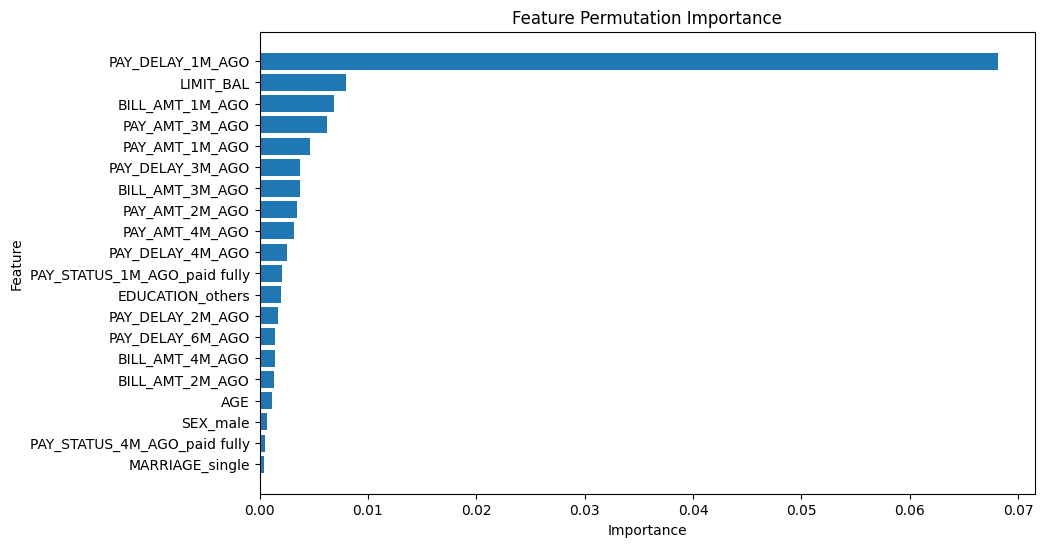

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat removed so far:  ['PAY_

In [ ]:
gbt2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   865  3740  933   462      48.11   65.18        80.03     76.75     55.36   
1   665  3947  726   662      47.81   50.11        84.46     76.87     48.93   
2   613  4035  638   714      49.00   46.19        86.35     77.47     47.56   
3   458  4379  294   869      60.90   34.51        93.71     80.62     44.06   
4   442  4412  261   885      62.87   33.31        94.41     80.90     43.55   
5   432  4419  254   895      62.97   32.55        94.56     80.85     42.92   
6   271  4535  138  1056      66.26   20.42        97.05     80.10     31.22   
7   249  4548  125  1078      66.58   18.76        97.33     79.95     29.28   
8   256  4533  140  1071      64.65   19.29        97.00     79.82     29.72   
9   252  4533  140  1075      64.29   18.99        97.00     79.75     29.32   
10   60  4652   21  1267      74.07    4.52        99.55     78.53      8.52   
11   58  4656   17  1269      77.33    4.37        99.64     78.57      8.27   
12   53  4658   15  1274      77.94    3.99        99.68     78.52      7.60   
13    1  4673    0  1326     100.00    0.08       100.00     77.90      0.15   
14    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.61                 0   
1               67.29                 1   
2               66.27                 2   
3               64.11                 3   
4               63.86                 4   
5               63.56                 5   
6               58.73                 6   
7               58.04                 7   
8               58.15                 8   
9               58.00                 9   
10              52.04                10   
11              52.00                11   
12              51.84                12   
13              50.04                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:48:19.900530

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
gbt2_perf_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0    865  3740   933  462      48.11   65.18        80.03     76.75     55.36   
1   1089  2276  2397  238      31.24   82.06        48.71     56.08     45.25   
2   1046  2451  2222  281      32.01   78.82        52.45     58.28     45.53   
3   1008  2653  2020  319      33.29   75.96        56.77     61.02     46.29   
4    994  2705  1968  333      33.56   74.91        57.89     61.65     46.35   
5    986  2691  1982  341      33.22   74.30        57.59     61.28     45.91   
6   1118  1873  2800  209      28.53   84.25        40.08     49.85     42.63   
7   1107  2022  2651  220      29.46   83.42        43.27     52.15     43.54   
8   1099  2025  2648  228      29.33   82.82        43.33     52.07     43.32   
9   1068  2041  2632  259      28.86   80.48        43.68     51.82     42.49   
10  1201  1117  3556  126      25.25   90.50        23.90     38.63     39.48   
11  1215   971  3702  112      24.71   91.56        20.78     36.43     38.92   
12  1220   924  3749  107      24.55   91.94        19.77     35.73     38.75   
13  1237   789  3884   90      24.16   93.22        16.88     33.77     38.37   
14  1284   432  4241   43      23.24   96.76         9.24     28.60     37.48   
15  1269   413  4260   58      22.95   95.63         8.84     28.03     37.02   
16  1244   592  4081   83      23.36   93.75        12.67     30.60     37.40   
17  1231   634  4039   96      23.36   92.77        13.57     31.08     37.32   
18  1234   619  4054   93      23.34   92.99        13.25     30.88     37.31   
19  1241   573  4100   86      23.24   93.52        12.26     30.23     37.22   
20  1234   617  4056   93      23.33   92.99        13.20     30.85     37.30   

    balanced_accuracy  num_feat_missing  \
0               72.61                 0   
1               65.39                 1   
2               65.64                 2   
3               66.37                 3   
4               66.40                 4   
5               65.94                 5   
6               62.17                 6   
7               63.35                 7   
8               63.08                 8   
9               62.08                 9   
10              57.20                10   
11              56.17                11   
12              55.85                12   
13              55.05                13   
14              53.00                14   
15              52.23                15   
16              53.21                16   
17              53.17                17   
18              53.12                18   
19              52.89                19   
20              53.10                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'BILL_AMT_1M...

In [ ]:
gbt2_perf_temp, gbt2_orig_missing_temp, gbt2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
gbt2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  865  3740  933   462      48.11   65.18        80.03     76.75     55.36   
1  496  4312  361   831      57.88   37.38        92.27     80.13     45.42   
2  443  4390  283   884      61.02   33.38        93.94     80.55     43.16   
3  253  4545  128  1074      66.40   19.07        97.26     79.97     29.63   
4  236  4544  129  1091      64.66   17.78        97.24     79.67     27.90   
5    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
6    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.61                 0   
1              64.83                 4   
2              63.66                 5   
3              58.16                 9   
4              57.51                13   
5              50.00                17   
6              50.00                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_temp_mf, gbt2_orig_missing_temp_mf, gbt2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:54:53.287685

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
gbt2_perf_temp_mf

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   865  3740   933  462      48.11   65.18        80.03     76.75     55.36   
1  1111  2080  2593  216      29.99   83.72        44.51     53.18     44.17   
2  1078  2152  2521  249      29.95   81.24        46.05     53.83     43.77   
3  1165  1538  3135  162      27.09   87.79        32.91     45.05     41.41   
4  1011  2089  2584  316      28.12   76.19        44.70     51.67     41.08   
5  1186   958  3715  141      24.20   89.37        20.50     35.73     38.09   
6  1191   895  3778  136      23.97   89.75        19.15     34.77     37.83   
7  1258   382  4291   69      22.67   94.80         8.17     27.33     36.59   

   balanced_accuracy  num_feat_missing  \
0              72.61                 0   
1              64.12                 4   
2              63.64                 5   
3              60.35                 9   
4              60.45                13   
5              54.94                17   
6              54.45                18   
7              51.49                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[5.0],
    'gamma': [1.0],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:32:39.887221

Nested Cross-validation Results:
Individual scores: [0.72114332 0.70894932 0.71140191]
Average nested CV score: 0.714 (+/- 0.011)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.714
2025-01-18 11:32:43.667734

Execution time: 0.06 minutes


```
Starting hyperparameter tuning at: 2025-01-17 07:39:57.505902

Nested Cross-validation Results:
Individual scores: [0.72215891 0.70826237 0.70419512]
Average nested CV score: 0.712 (+/- 0.015)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.714
2025-01-17 08:01:32.093639

Execution time: 21.58 minutes
```

In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.041570  0.001449
15                         PAY_DELAY_2M_AGO    0.018922  0.002122
2                           BILL_AMT_1M_AGO    0.011588  0.001259
10                           PAY_AMT_3M_AGO    0.009295  0.001281
0                                 LIMIT_BAL    0.007634  0.001165
9                            PAY_AMT_2M_AGO    0.004672  0.001553
4                           BILL_AMT_3M_AGO    0.003342  0.000203
17                         PAY_DELAY_4M_AGO    0.003207  0.000683
16                         PAY_DELAY_3M_AGO    0.002975  0.000494
8                            PAY_AMT_1M_AGO    0.002369  0.001345
3                           BILL_AMT_2M_AGO    0.001868  0.000623
22                         EDUCATION_others    0.001857  0.000656
5                           BILL_AMT_4M_AGO    0.001452  0.000317
6                           BILL_AMT_5M_AGO    0.001325  0.000547
13                           PAY_AMT_6M_AGO    0.001100  0.000672
32  PAY_STATUS_2M_AGO_revolving credit used    0.001030  0.000282
19                         PAY_DELAY_6M_AGO    0.000879  0.000339
7                           BILL_AMT_6M_AGO    0.000776  0.000447
24                         MARRIAGE_married    0.000614  0.000547
11                           PAY_AMT_4M_AGO    0.000612  0.000461
34        PAY_STATUS_3M_AGO_payment overdue    0.000589  0.000338
1                                       AGE    0.000565  0.000314
31        PAY_STATUS_2M_AGO_payment overdue    0.000551  0.000454
38  PAY_STATUS_4M_AGO_revolving credit used    0.000535  0.000166
35  PAY_STATUS_3M_AGO_revolving credit used    0.000324  0.000183
26                          MARRIAGE_single    0.000241  0.000286
43        PAY_STATUS_6M_AGO_payment overdue    0.000236  0.000118
39             PAY_STATUS_5M_AGO_paid fully    0.000169  0.000190
23                     EDUCATION_university    0.000161  0.000203
27             PAY_STATUS_1M_AGO_paid fully    0.000137  0.000215
18                         PAY_DELAY_5M_AGO    0.000135  0.000277
25                          MARRIAGE_others    0.000118  0.000055
42             PAY_STATUS_6M_AGO_paid fully    0.000064  0.000169
40        PAY_STATUS_5M_AGO_payment overdue    0.000010  0.000134
37        PAY_STATUS_4M_AGO_payment overdue   -0.000014  0.000073
20                                 SEX_male   -0.000233  0.000453
29  PAY_STATUS_1M_AGO_revolving credit used   -0.000343  0.000549
28        PAY_STATUS_1M_AGO_payment overdue   -0.000359  0.000562
12                           PAY_AMT_5M_AGO   -0.000724  0.000298

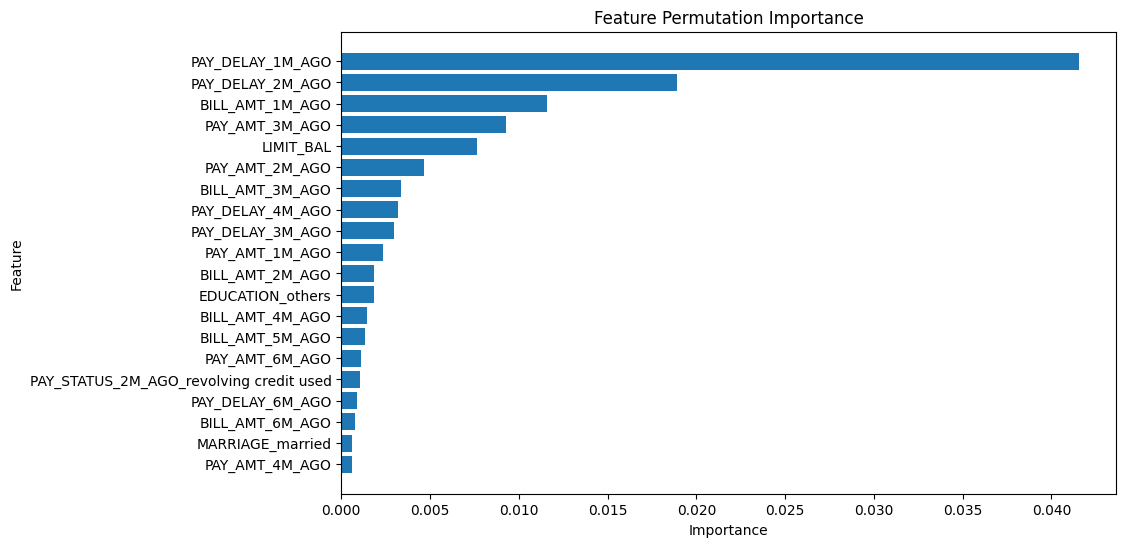

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_3M_AGO
Original feat 

In [ ]:
xgb2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   861  3764  909   466      48.64   64.88        80.55     77.08     55.60   
1   780  3808  865   547      47.42   58.78        81.49     76.47     52.49   
2   615  3958  715   712      46.24   46.35        84.70     76.22     46.29   
3   461  4329  344   866      57.27   34.74        92.64     79.83     43.25   
4   424  4389  284   903      59.89   31.95        93.92     80.22     41.67   
5   409  4424  249   918      62.16   30.82        94.67     80.55     41.21   
6   397  4416  257   930      60.70   29.92        94.50     80.22     40.08   
7   393  4429  244   934      61.70   29.62        94.78     80.37     40.02   
8   298  4511  162  1029      64.78   22.46        96.53     80.15     33.35   
9   134  4613   60  1193      69.07   10.10        98.72     79.12     17.62   
10  145  4608   65  1182      69.05   10.93        98.61     79.22     18.87   
11  120  4628   45  1207      72.73    9.04        99.04     79.13     16.09   
12  113  4630   43  1214      72.44    8.52        99.08     79.05     15.24   
13  104  4636   37  1223      73.76    7.84        99.21     79.00     14.17   
14   96  4639   34  1231      73.85    7.23        99.27     78.92     13.18   
15  112  4632   41  1215      73.20    8.44        99.12     79.07     15.14   
16  254  4569  104  1073      70.95   19.14        97.77     80.38     30.15   
17   53  4650   23  1274      69.74    3.99        99.51     78.38      7.56   
18   53  4647   26  1274      67.09    3.99        99.44     78.33      7.54   
19   10  4671    2  1317      83.33    0.75        99.96     78.02      1.49   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               72.72                 0   
1               70.13                 1   
2               65.52                 2   
3               63.69                 3   
4               62.94                 4   
5               62.75                 5   
6               62.21                 6   
7               62.20                 7   
8               59.49                 8   
9               54.41                 9   
10              54.77                10   
11              54.04                11   
12              53.80                12   
13              53.52                13   
14              53.25                14   
15              53.78                15   
16              58.46                16   
17              51.75                17   
18              51.72                18   
19              50.36                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())


xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 13:57:12.699234

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
xgb2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   861  3764  909   466      48.64   64.88        80.55     77.08     55.60   
1   781  3808  865   546      47.45   58.85        81.49     76.48     52.54   
2   604  3960  713   723      45.86   45.52        84.74     76.07     45.69   
3   563  4071  602   764      48.33   42.43        87.12     77.23     45.18   
4   516  4157  516   811      50.00   38.88        88.96     77.88     43.75   
5   486  4230  443   841      52.31   36.62        90.52     78.60     43.09   
6   446  4299  374   881      54.39   33.61        92.00     79.08     41.55   
7   436  4348  325   891      57.29   32.86        93.05     79.73     41.76   
8   381  4441  232   946      62.15   28.71        95.04     80.37     39.28   
9   180  4568  105  1147      63.16   13.56        97.75     79.13     22.33   
10  175  4571  102  1152      63.18   13.19        97.82     79.10     21.82   
11  135  4589   84  1192      61.64   10.17        98.20     78.73     17.46   
12  133  4591   82  1194      61.86   10.02        98.25     78.73     17.25   
13  121  4603   70  1206      63.35    9.12        98.50     78.73     15.94   
14  131  4603   70  1196      65.17    9.87        98.50     78.90     17.15   
15  127  4611   62  1200      67.20    9.57        98.67     78.97     16.75   
16  207  4573  100  1120      67.43   15.60        97.86     79.67     25.34   
17   87  4628   45  1240      65.91    6.56        99.04     78.58     11.93   
18  113  4603   70  1214      61.75    8.52        98.50     78.60     14.97   
19   89  4622   51  1238      63.57    6.71        98.91     78.52     12.13   
20   59  4648   25  1268      70.24    4.45        99.47     78.45      8.36   

    balanced_accuracy  num_feat_missing  \
0               72.72                 0   
1               70.17                 1   
2               65.13                 2   
3               64.77                 3   
4               63.92                 4   
5               63.57                 5   
6               62.80                 6   
7               62.95                 7   
8               61.87                 8   
9               55.66                 9   
10              55.50                10   
11              54.19                11   
12              54.13                12   
13              53.81                13   
14              54.19                14   
15              54.12                15   
16              56.73                16   
17              52.80                17   
18              53.51                18   
19              52.81                19   
20              51.96                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2    ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO'] imputed  
3   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
4   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
5   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
6   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
7   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
8   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
9   ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
10  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
11  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
12  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
13  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
14  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
15  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
16  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
17  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
18  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
19  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...  
20  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'BILL...

In [ ]:
xgb2_perf_temp, xgb2_orig_missing_temp, xgb2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
xgb2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  861  3764  909   466      48.64   64.88        80.55     77.08     55.60   
1  618  4169  504   709      55.08   46.57        89.21     79.78     50.47   
2  450  4334  339   877      57.03   33.91        92.75     79.73     42.53   
3  325  4469  204  1002      61.44   24.49        95.63     79.90     35.02   
4  286  4505  168  1041      63.00   21.55        96.40     79.85     32.12   
5   42  4651   22  1285      65.62    3.17        99.53     78.22      6.04   
6   40  4652   21  1287      65.57    3.01        99.55     78.20      5.76   
7    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              72.72                 0   
1              67.89                 4   
2              63.33                 8   
3              60.06                12   
4              58.98                13   
5              51.35                17   
6              51.28                18   
7              50.00                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_temp_mf, xgb2_orig_missing_temp_mf, xgb2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:03:43.370988

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
xgb2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  861  3764  909   466      48.64   64.88        80.55     77.08     55.60   
1  706  3938  735   621      48.99   53.20        84.27     77.40     51.01   
2  443  4312  361   884      55.10   33.38        92.27     79.25     41.58   
3  316  4415  258  1011      55.05   23.81        94.48     78.85     33.25   
4  327  4397  276  1000      54.23   24.64        94.09     78.73     33.89   
5  181  4571  102  1146      63.96   13.64        97.82     79.20     22.48   
6  181  4568  105  1146      63.29   13.64        97.75     79.15     22.44   
7   28  4663   10  1299      73.68    2.11        99.79     78.18      4.10   

   balanced_accuracy  num_feat_missing  \
0              72.72                 0   
1              68.74                 4   
2              62.83                 8   
3              59.15                12   
4              59.37                13   
5              55.73                17   
6              55.70                18   
7              50.95                22   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [100],
      'max_depth': [None],
      'max_features':['sqrt'],
      'min_samples_split': [0.005],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:39:20.101119

Nested Cross-validation Results:
Individual scores: [0.71661274 0.70297313 0.70406453]
Average nested CV score: 0.708 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.708
2025-01-18 11:39:29.087904

Execution time: 0.15 minutes


```
Starting hyperparameter tuning at: 2025-01-17 06:32:43.948076

Nested Cross-validation Results:
Individual scores: [0.71228065 0.70297313 0.70470976]
Average nested CV score: 0.707 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.005, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.708
2025-01-17 07:29:08.677753

Execution time: 56.41 minutes
```




In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
14                         PAY_DELAY_1M_AGO    0.020123  0.000665
28        PAY_STATUS_1M_AGO_payment overdue    0.016815  0.000562
44  PAY_STATUS_6M_AGO_revolving credit used    0.016275  0.000701
3                           BILL_AMT_2M_AGO    0.014513  0.000711
5                           BILL_AMT_4M_AGO    0.014259  0.000755
32  PAY_STATUS_2M_AGO_revolving credit used    0.014223  0.001168
2                           BILL_AMT_1M_AGO    0.013757  0.000708
0                                 LIMIT_BAL    0.013699  0.000321
6                           BILL_AMT_5M_AGO    0.013314  0.001213
4                           BILL_AMT_3M_AGO    0.013000  0.000517
29  PAY_STATUS_1M_AGO_revolving credit used    0.012579  0.000753
35  PAY_STATUS_3M_AGO_revolving credit used    0.012090  0.000859
7                           BILL_AMT_6M_AGO    0.012078  0.000952
10                           PAY_AMT_3M_AGO    0.009323  0.001112
33             PAY_STATUS_3M_AGO_paid fully    0.009198  0.000511
30             PAY_STATUS_2M_AGO_paid fully    0.009027  0.000711
41  PAY_STATUS_5M_AGO_revolving credit used    0.008984  0.000960
11                           PAY_AMT_4M_AGO    0.008926  0.001068
8                            PAY_AMT_1M_AGO    0.008789  0.001542
27             PAY_STATUS_1M_AGO_paid fully    0.008630  0.000880
23                     EDUCATION_university    0.007747  0.000358
9                            PAY_AMT_2M_AGO    0.007461  0.000885
36             PAY_STATUS_4M_AGO_paid fully    0.007223  0.000626
20                                 SEX_male    0.007008  0.000544
24                         MARRIAGE_married    0.006964  0.000146
1                                       AGE    0.006847  0.000558
38  PAY_STATUS_4M_AGO_revolving credit used    0.006525  0.000433
42             PAY_STATUS_6M_AGO_paid fully    0.005627  0.000443
12                           PAY_AMT_5M_AGO    0.005513  0.000899
39             PAY_STATUS_5M_AGO_paid fully    0.004936  0.000321
26                          MARRIAGE_single    0.004935  0.000346
13                           PAY_AMT_6M_AGO    0.004564  0.000429
34        PAY_STATUS_3M_AGO_payment overdue    0.004204  0.000380
16                         PAY_DELAY_3M_AGO    0.003209  0.000341
22                         EDUCATION_others    0.003203  0.000511
21                    EDUCATION_high school    0.003137  0.000486
43        PAY_STATUS_6M_AGO_payment overdue    0.002516  0.000396
40        PAY_STATUS_5M_AGO_payment overdue    0.002482  0.000617
37        PAY_STATUS_4M_AGO_payment overdue    0.002214  0.000864
31        PAY_STATUS_2M_AGO_payment overdue    0.002175  0.001539
19                         PAY_DELAY_6M_AGO    0.001580  0.000261
18                         PAY_DELAY_5M_AGO    0.001533  0.000511
17                         PAY_DELAY_4M_AGO    0.000316  0.000734
25                          MARRIAGE_others    0.000220  0.000098
15                         PAY_DELAY_2M_AGO   -0.002060  0.000928

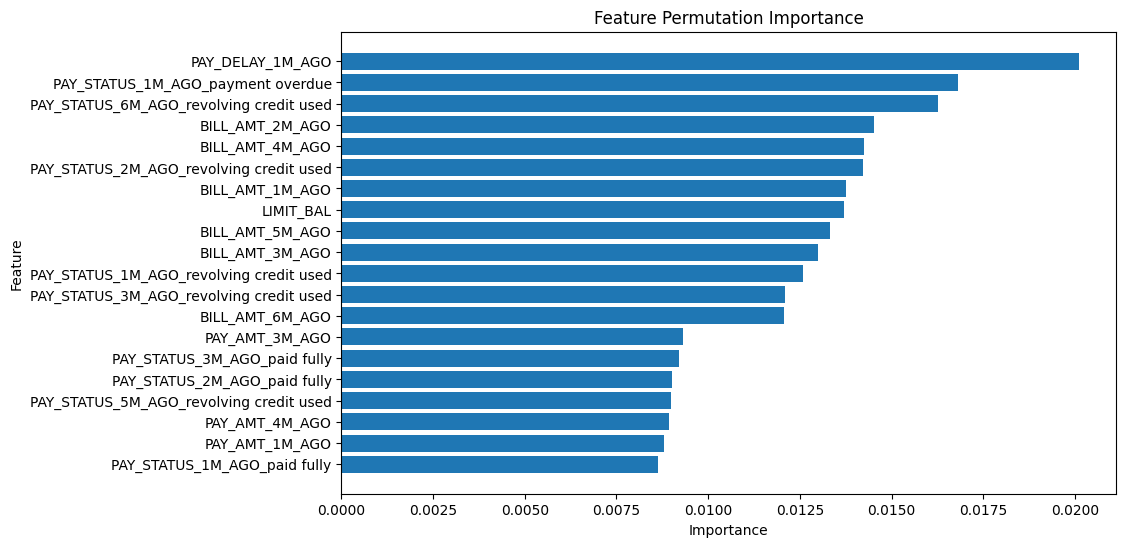

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_6M_AGO_revolving credit used
Removing related features:  ['PAY_STATUS_6M_AGO_paid fully', 'PAY_STATUS_6M_AGO_payment overdue', 'PAY_STATUS_6M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_2M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_STATUS_6M_AGO', 'BILL_AMT_2M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', '

In [ ]:
et2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   826  3851  822   501      50.12   62.25        82.41     77.95     55.53   
1   742  3909  764   585      49.27   55.92        83.65     77.52     52.38   
2   700  3991  682   627      50.65   52.75        85.41     78.18     51.68   
3   657  4090  583   670      52.98   49.51        87.52     79.12     51.19   
4   654  4095  578   673      53.08   49.28        87.63     79.15     51.11   
5   651  4089  584   676      52.71   49.06        87.50     79.00     50.82   
6   526  4228  445   801      54.17   39.64        90.48     79.23     45.78   
7   529  4235  438   798      54.71   39.86        90.63     79.40     46.12   
8   502  4253  420   825      54.45   37.83        91.01     79.25     44.64   
9   495  4256  417   832      54.28   37.30        91.08     79.18     44.22   
10  497  4254  419   830      54.26   37.45        91.03     79.18     44.32   
11  427  4318  355   900      54.60   32.18        92.40     79.08     40.49   
12  428  4316  357   899      54.52   32.25        92.36     79.07     40.53   
13  430  4315  358   897      54.57   32.40        92.34     79.08     40.66   
14  394  4336  337   933      53.90   29.69        92.79     78.83     38.29   
15  394  4337  336   933      53.97   29.69        92.81     78.85     38.31   
16  394  4334  339   933      53.75   29.69        92.75     78.80     38.25   
17  393  4336  337   934      53.84   29.62        92.79     78.82     38.21   
18  393  4336  337   934      53.84   29.62        92.79     78.82     38.21   
19  255  4552  121  1072      67.82   19.22        97.41     80.12     29.95   
20  235  4569  104  1092      69.32   17.71        97.77     80.07     28.21   

    balanced_accuracy  num_feat_missing  \
0               72.33                 0   
1               69.78                 1   
2               69.08                 2   
3               68.52                 3   
4               68.46                 4   
5               68.28                 5   
6               65.06                 6   
7               65.25                 7   
8               64.42                 8   
9               64.19                 9   
10              64.24                10   
11              62.29                11   
12              62.31                12   
13              62.37                13   
14              61.24                14   
15              61.25                15   
16              61.22                16   
17              61.20                17   
18              61.20                18   
19              58.31                19   
20              57.74                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:06:02.102622

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STA

In [ ]:
et2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   826  3851  822  501      50.12   62.25        82.41     77.95     55.53   
1   749  3874  799  578      48.39   56.44        82.90     77.05     52.10   
2   731  3905  768  596      48.77   55.09        83.57     77.27     51.73   
3   707  3977  696  620      50.39   53.28        85.11     78.07     51.79   
4   705  3979  694  622      50.39   53.13        85.15     78.07     51.72   
5   697  4008  665  630      51.17   52.52        85.77     78.42     51.84   
6   598  4140  533  729      52.87   45.06        88.59     78.97     48.66   
7   596  4153  520  731      53.41   44.91        88.87     79.15     48.79   
8   593  4153  520  734      53.28   44.69        88.87     79.10     48.61   
9   591  4149  524  736      53.00   44.54        88.79     79.00     48.40   
10  588  4143  530  739      52.59   44.31        88.66     78.85     48.10   
11  573  4213  460  754      55.47   43.18        90.16     79.77     48.56   
12  575  4215  458  752      55.66   43.33        90.20     79.83     48.73   
13  572  4215  458  755      55.53   43.10        90.20     79.78     48.54   
14  540  4240  433  787      55.50   40.69        90.73     79.67     46.96   
15  537  4244  429  790      55.59   40.47        90.82     79.68     46.84   
16  531  4241  432  796      55.14   40.02        90.76     79.53     46.38   
17  538  4230  443  789      54.84   40.54        90.52     79.47     46.62   
18  537  4236  437  790      55.13   40.47        90.65     79.55     46.68   
19  479  4375  298  848      61.65   36.10        93.62     80.90     45.53   
20  492  4349  324  835      60.29   37.08        93.07     80.68     45.92   

    balanced_accuracy  num_feat_missing  \
0               72.33                 0   
1               69.67                 1   
2               69.33                 2   
3               69.19                 3   
4               69.14                 4   
5               69.15                 5   
6               66.83                 6   
7               66.89                 7   
8               66.78                 8   
9               66.66                 9   
10              66.48                10   
11              66.67                11   
12              66.76                12   
13              66.65                13   
14              65.71                14   
15              65.64                15   
16              65.39                16   
17              65.53                17   
18              65.56                18   
19              64.86                19   
20              65.07                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
3   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
4   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
5   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
6   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
7   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
8   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
9   ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
10  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
11  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
12  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
13  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
14  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
15  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
16  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
17  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
18  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
19  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...  
20  ['PAY_DELAY_1M_AGO', 'PAY_STATUS_1M_AGO_paid f...

In [ ]:
et2_perf_temp, et2_orig_missing_temp, et2_missing_temp = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                         PAY_DELAY_1M_

In [ ]:
et2_perf_temp

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  826  3851  822   501      50.12   62.25        82.41     77.95     55.53   
1  673  4034  639   654      51.30   50.72        86.33     78.45     51.00   
2  651  4094  579   676      52.93   49.06        87.61     79.08     50.92   
3  453  4280  393   874      53.55   34.14        91.59     78.88     41.69   
4  356  4454  219   971      61.91   26.83        95.31     80.17     37.43   
5  317  4470  203  1010      60.96   23.89        95.66     79.78     34.33   
6  148  4556  117  1179      55.85   11.15        97.50     78.40     18.59   

   balanced_accuracy  num_feat_missing  \
0              72.33                 0   
1              68.52                 4   
2              68.33                 8   
3              62.86                12   
4              61.07                16   
5              59.77                17   
6              54.32                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_temp_mf, et2_orig_missing_temp_mf, et2_missing_temp_mf = measure_temporal_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:12:45.225354

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', '

In [ ]:
et2_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  826  3851  822  501      50.12   62.25        82.41     77.95     55.53   
1  707  3954  719  620      49.58   53.28        84.61     77.68     51.36   
2  678  4031  642  649      51.36   51.09        86.26     78.48     51.23   
3  520  4203  470  807      52.53   39.19        89.94     78.72     44.89   
4  470  4305  368  857      56.09   35.42        92.12     79.58     43.42   
5  468  4300  373  859      55.65   35.27        92.02     79.47     43.17   
6  457  4297  376  870      54.86   34.44        91.95     79.23     42.31   

   balanced_accuracy  num_feat_missing  \
0              72.33                 0   
1              68.95                 4   
2              68.68                 8   
3              64.56                12   
4              63.77                16   
5              63.64                17   
6              63.20                21   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

## **Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.01, 0.1, 0.5, 1, 5],
      'kernel': ['linear', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1],
  }
else:
  # best model
  svm2_param_grid = {
    'C': [1.0],
    'kernel': ['rbf'],
    'gamma': [0.1]
}

svm2_classifier = SVC(
    class_weight='balanced', cache_size=1000, random_state=RANDOM_STATE
)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy',
    X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-18 11:46:00.778382

Nested Cross-validation Results:
Individual scores: [0.7052865  0.6950667  0.69898613]
Average nested CV score: 0.700 (+/- 0.008)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.700
2025-01-18 11:47:31.686430

Execution time: 1.52 minutes


```
Starting hyperparameter tuning at: 2025-01-17 10:20:14.878970

Nested Cross-validation Results:
Individual scores: [0.7052865  0.69369326 0.70106964]
Average nested CV score: 0.700 (+/- 0.010)

Fitting final model on entire dataset...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.700
2025-01-17 10:43:44.116346

Execution time: 23.49 minutes
```

In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(
    svm2_classifier, X_train_scaled, y_train,
    scoring_metric="balanced_accuracy", n_repeats=3
)
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
28        PAY_STATUS_1M_AGO_payment overdue    0.073966  0.001333
34        PAY_STATUS_3M_AGO_payment overdue    0.025767  0.001623
31        PAY_STATUS_2M_AGO_payment overdue    0.008565  0.001355
37        PAY_STATUS_4M_AGO_payment overdue    0.004094  0.000352
32  PAY_STATUS_2M_AGO_revolving credit used    0.001367  0.000061
36             PAY_STATUS_4M_AGO_paid fully    0.001334  0.000324
40        PAY_STATUS_5M_AGO_payment overdue    0.001199  0.000105
44  PAY_STATUS_6M_AGO_revolving credit used    0.001124  0.000280
41  PAY_STATUS_5M_AGO_revolving credit used    0.000941  0.000330
43        PAY_STATUS_6M_AGO_payment overdue    0.000877  0.000162
23                     EDUCATION_university    0.000759  0.000122
38  PAY_STATUS_4M_AGO_revolving credit used    0.000745  0.000022
24                         MARRIAGE_married    0.000700  0.000229
30             PAY_STATUS_2M_AGO_paid fully    0.000637  0.000042
26                          MARRIAGE_single    0.000631  0.000408
22                         EDUCATION_others    0.000617  0.000121
35  PAY_STATUS_3M_AGO_revolving credit used    0.000445  0.000087
20                                 SEX_male    0.000356  0.000113
18                         PAY_DELAY_5M_AGO    0.000292  0.000017
19                         PAY_DELAY_6M_AGO    0.000265  0.000028
29  PAY_STATUS_1M_AGO_revolving credit used    0.000249  0.000174
21                    EDUCATION_high school    0.000225  0.000204
0                                 LIMIT_BAL    0.000175  0.000096
1                                       AGE    0.000163  0.000072
27             PAY_STATUS_1M_AGO_paid fully    0.000162  0.000117
33             PAY_STATUS_3M_AGO_paid fully    0.000108  0.000257
4                           BILL_AMT_3M_AGO    0.000077  0.000017
11                           PAY_AMT_4M_AGO    0.000072  0.000104
13                           PAY_AMT_6M_AGO    0.000036  0.000028
39             PAY_STATUS_5M_AGO_paid fully    0.000018  0.000248
25                          MARRIAGE_others    0.000018  0.000013
9                            PAY_AMT_2M_AGO    0.000014  0.000040
17                         PAY_DELAY_4M_AGO   -0.000009  0.000044
10                           PAY_AMT_3M_AGO   -0.000018  0.000088
12                           PAY_AMT_5M_AGO   -0.000022  0.000044
7                           BILL_AMT_6M_AGO   -0.000027  0.000022
5                           BILL_AMT_4M_AGO   -0.000040  0.000061
8                            PAY_AMT_1M_AGO   -0.000049  0.000085
3                           BILL_AMT_2M_AGO   -0.000067  0.000000
14                         PAY_DELAY_1M_AGO   -0.000076  0.000101
42             PAY_STATUS_6M_AGO_paid fully   -0.000081  0.000070
2                           BILL_AMT_1M_AGO   -0.000085  0.000089
16                         PAY_DELAY_3M_AGO   -0.000103  0.000025
15                         PAY_DELAY_2M_AGO   -0.000252  0.000110

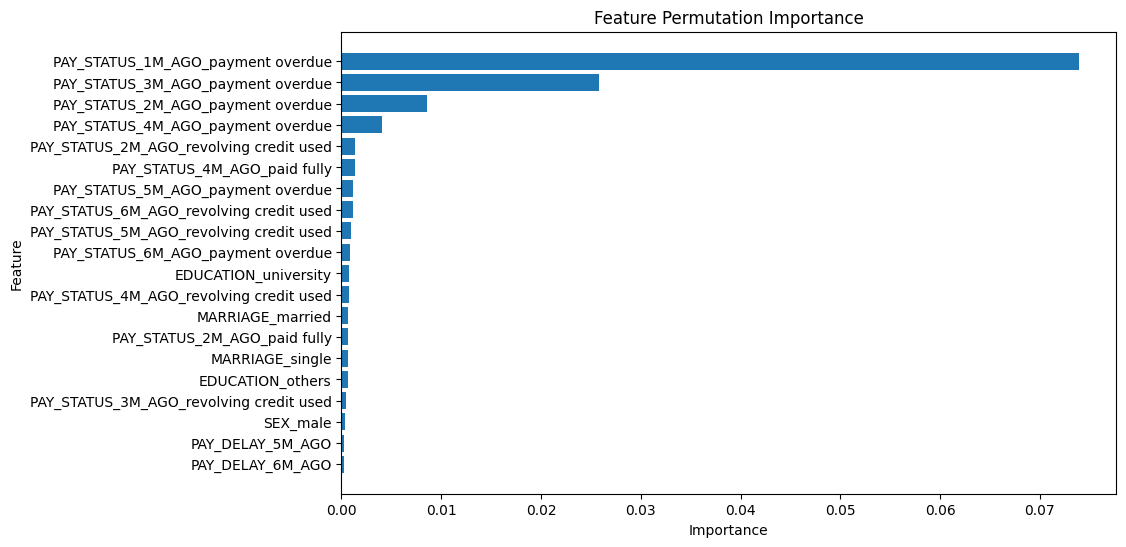

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_3M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_3M_AGO_payment overdue', 'PAY_STATUS_3M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_2M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_STATUS_2M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_STATUS_1M_AGO', 'PAY_STATUS_3M_AGO', 'PAY_STATUS_2M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_4M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_4M_AGO_pai

In [ ]:
svm2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3846  827   515      49.54   61.19        82.30     77.63     54.75   
1   650  4085  588   677      52.50   48.98        87.42     78.92     50.68   
2   613  4208  465   714      56.86   46.19        90.05     80.35     50.98   
3   351  4441  232   976      60.21   26.45        95.04     79.87     36.75   
4   175  4598   75  1152      70.00   13.19        98.40     79.55     22.19   
5    26  4663   10  1301      72.22    1.96        99.79     78.15      3.82   
6    18  4666    7  1309      72.00    1.36        99.85     78.07      2.66   
7    18  4666    7  1309      72.00    1.36        99.85     78.07      2.66   
8    14  4668    5  1313      73.68    1.06        99.89     78.03      2.08   
9    10  4668    5  1317      66.67    0.75        99.89     77.97      1.49   
10    4  4669    4  1323      50.00    0.30        99.91     77.88      0.60   
11    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
12    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
13    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
14    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
15    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
16    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
17    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
18    3  4669    4  1324      42.86    0.23        99.91     77.87      0.45   
19    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
20    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   

    balanced_accuracy  num_feat_missing  \
0               71.75                 0   
1               68.20                 1   
2               68.12                 2   
3               60.74                 3   
4               55.79                 4   
5               50.87                 5   
6               50.60                 6   
7               50.60                 7   
8               50.47                 8   
9               50.32                 9   
10              50.11                10   
11              50.07                11   
12              50.07                12   
13              50.07                13   
14              50.07                14   
15              50.07                15   
16              50.07                16   
17              50.07                17   
18              50.07                18   
19              50.03                19   
20              50.03                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:16:29.077439

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Nr. columns with nan:  3
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_2M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO']
Categorical columns:  ['SEX_male', 'EDUCATION_high school', 'EDUCATION_others', 'EDUCATION_university', 'MARRIAGE_married', 'MARRIAGE_others', 'MARRIAGE_single', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_2M_AGO_payment overdue', 'PAY_

In [ ]:
svm2_perf_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3846  827   515      49.54   61.19        82.30     77.63     54.75   
1   672  4010  663   655      50.34   50.64        85.81     78.03     50.49   
2   666  3953  720   661      48.05   50.19        84.59     76.98     49.10   
3   350  4442  231   977      60.24   26.38        95.06     79.87     36.69   
4   172  4592   81  1155      67.98   12.96        98.27     79.40     21.77   
5    28  4660   13  1299      68.29    2.11        99.72     78.13      4.09   
6     8  4669    4  1319      66.67    0.60        99.91     77.95      1.19   
7     7  4669    4  1320      63.64    0.53        99.91     77.93      1.05   
8     2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
9     2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
10    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
11    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
12    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
13    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
14    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
15    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
16    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
17    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
18    2  4669    4  1325      33.33    0.15        99.91     77.85      0.30   
19    1  4670    3  1326      25.00    0.08        99.94     77.85      0.15   
20    1  4670    3  1326      25.00    0.08        99.94     77.85      0.15   

    balanced_accuracy  num_feat_missing  \
0               71.75                 0   
1               68.23                 1   
2               67.39                 2   
3               60.72                 3   
4               55.61                 4   
5               50.92                 5   
6               50.26                 6   
7               50.22                 7   
8               50.03                 8   
9               50.03                 9   
10              50.03                10   
11              50.03                11   
12              50.03                12   
13              50.03                13   
14              50.03                14   
15              50.03                15   
16              50.03                16   
17              50.03                17   
18              50.03                18   
19              50.01                19   
20              50.01                20   

                                              imputed  
0                                                      
1   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
2   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
3   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
4   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
5   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
6   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
7   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
8   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
9   ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
10  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
11  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
12  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
13  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
14  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
15  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
16  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
17  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
18  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
19  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...  
20  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1...

In [ ]:
svm2_perf_temp, svm2_orig_missing_temp, svm2_missing_temp = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
2                           BILL_AMT_1M_AGO       0.0
8                            PAY_AMT_1M_AGO       0.0
14                     

In [ ]:
svm2_perf_temp

tp    tn    fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   812  3846   827  515      49.54   61.19         82.3     77.63     54.75   
1  1327     0  4673    0      22.12  100.00          0.0     22.12     36.22   
2  1327     0  4673    0      22.12  100.00          0.0     22.12     36.22   
3  1327     0  4673    0      22.12  100.00          0.0     22.12     36.22   
4  1327     0  4673    0      22.12  100.00          0.0     22.12     36.22   
5  1327     0  4673    0      22.12  100.00          0.0     22.12     36.22   

   balanced_accuracy  num_feat_missing  \
0              71.75                 0   
1              50.00                 4   
2              50.00                 8   
3              50.00                12   
4              50.00                16   
5              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_temp_mf, svm2_orig_missing_temp_mf, svm2_missing_temp_mf = measure_temporal_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:25:40.775288

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  45
length removed:  0

Removing feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_payment overdue', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_payment overdue
Removing related features:  []
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  6
Numerical columns:  ['LIMIT_BAL', 'AGE', 'BILL_AMT_1M_AGO', 'BILL_AMT_2M_AGO', 'BILL_AMT_3M_AGO', 'BILL_AMT_4M_AGO', 'BILL_AMT_5M_AGO', 'BILL_AMT_6M_AGO', 'PAY_AMT_1M_AGO', 'P

In [ ]:
svm2_perf_temp_mf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0  812  3846  827   515      49.54   61.19        82.30     77.63     54.75   
1  668  4014  659   659      50.34   50.34        85.90     78.03     50.34   
2  663  3954  719   664      47.97   49.96        84.61     76.95     48.95   
3  324  4449  224  1003      59.12   24.42        95.21     79.55     34.56   
4  111  4619   54  1216      67.27    8.36        98.84     78.83     14.88   
5    2  4673    0  1325     100.00    0.15       100.00     77.92      0.30   

   balanced_accuracy  num_feat_missing  \
0              71.75                 0   
1              68.12                 4   
2              67.29                 8   
3              59.81                12   
4              53.60                16   
5              50.08                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

##**Logistic Regression**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-18 12:08:36.417240

Nested Cross-validation Results:
Individual scores: [0.71100423 0.69807792 0.69871045]
Average nested CV score: 0.703 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.703
2025-01-18 12:08:39.986045

Execution time: 0.06 minutes


CV 3x3
```
Starting hyperparameter tuning at: 2025-01-17 08:19:19.106973

Nested Cross-validation Results:
Individual scores: [0.71052277 0.69706677 0.69850822]
Average nested CV score: 0.702 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.703
2025-01-17 08:19:41.889254

Execution time: 0.38 minutes
```

In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
0                          PAY_DELAY_1M_AGO    0.092294  0.003146
7                                 LIMIT_BAL    0.012037  0.000544
2                          PAY_DELAY_3M_AGO    0.007195  0.000881
22             PAY_STATUS_1M_AGO_paid fully    0.004830  0.000476
3                          PAY_DELAY_4M_AGO    0.003485  0.000694
28                          BILL_AMT_1M_AGO    0.003387  0.001494
19             PAY_STATUS_2M_AGO_paid fully    0.001493  0.000387
17  PAY_STATUS_6M_AGO_revolving credit used    0.001378  0.001024
26                                 SEX_male    0.001260  0.000964
10  PAY_STATUS_3M_AGO_revolving credit used    0.001249  0.000171
24                         EDUCATION_others    0.001179  0.000677
6   PAY_STATUS_1M_AGO_revolving credit used    0.000999  0.001032
14                           PAY_AMT_5M_AGO    0.000929  0.000305
29                          MARRIAGE_single    0.000911  0.000762
23             PAY_STATUS_6M_AGO_paid fully    0.000809  0.000262
21             PAY_STATUS_5M_AGO_paid fully    0.000759  0.000121
5                          PAY_DELAY_6M_AGO    0.000694  0.000198
27                    EDUCATION_high school    0.000693  0.000108
9                            PAY_AMT_1M_AGO    0.000507  0.000566
11                           PAY_AMT_3M_AGO    0.000437  0.000253
15                           PAY_AMT_6M_AGO    0.000349  0.000587
20             PAY_STATUS_4M_AGO_paid fully    0.000316  0.000475
31                          BILL_AMT_6M_AGO    0.000302  0.000262
32                          MARRIAGE_others    0.000290  0.000209
8                            PAY_AMT_2M_AGO    0.000282  0.000457
18             PAY_STATUS_3M_AGO_paid fully    0.000252  0.000139
4                          PAY_DELAY_5M_AGO    0.000235  0.000150
30                                      AGE    0.000153  0.000269
13                           PAY_AMT_4M_AGO    0.000018  0.000165
25                     EDUCATION_university   -0.000007  0.000178
1                          PAY_DELAY_2M_AGO   -0.000093  0.000260
12  PAY_STATUS_4M_AGO_revolving credit used   -0.000328  0.000419
16  PAY_STATUS_5M_AGO_revolving credit used   -0.000466  0.000620

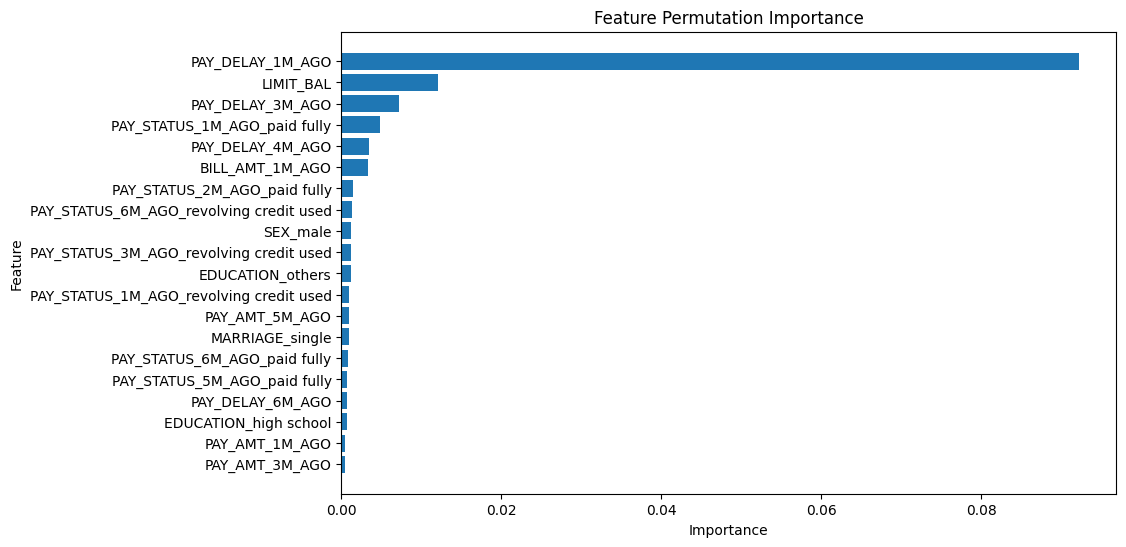

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_imputation_scaled_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family
)


--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO']

--- NEW ITERATION ---
Removing feature:  LIMIT_BAL
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_3M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO']

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_4M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO', 'PAY_DELAY_4M_AGO']

--- NEW ITERATION ---
Removing feature:  BILL_AMT_1M_AGO
Original feat removed so far:  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3M_AGO', 'PAY_STATUS_1M_AGO'

In [ ]:
lr2_perf

tp    tn   fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794   520      50.41   60.81        83.01     78.10     55.12   
1   482  4257  416   845      53.67   36.32        91.10     78.98     43.33   
2   444  4288  385   883      53.56   33.46        91.76     78.87     41.19   
3   332  4383  290   995      53.38   25.02        93.79     78.58     34.07   
4   331  4379  294   996      52.96   24.94        93.71     78.50     33.91   
5   242  4435  238  1085      50.42   18.24        94.91     77.95     26.78   
6   176  4515  158  1151      52.69   13.26        96.62     78.18     21.19   
7   179  4503  170  1148      51.29   13.49        96.36     78.03     21.36   
8    24  4662   11  1303      68.57    1.81        99.76     78.10      3.52   
9    14  4673    0  1313     100.00    1.06       100.00     78.12      2.09   
10   17  4673    0  1310     100.00    1.28       100.00     78.17      2.53   
11   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
12   13  4673    0  1314     100.00    0.98       100.00     78.10      1.94   
13   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
14   12  4673    0  1315     100.00    0.90       100.00     78.08      1.79   
15    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
16    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
17    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
18    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
19    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   
20    0  4673    0  1327       0.00    0.00       100.00     77.88      0.00   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               63.71                 1   
2               62.61                 2   
3               59.41                 3   
4               59.33                 4   
5               56.57                 5   
6               54.94                 6   
7               54.93                 7   
8               50.79                 8   
9               50.53                 9   
10              50.64                10   
11              50.49                11   
12              50.49                12   
13              50.45                13   
14              50.45                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars
)


print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:27:52.864389

--- NEW ITERATION ---
Removing feature:  PAY_DELAY_1M_AGO
Nr. columns with nan:  1
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  ['PAY_STATUS_1M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_revolving credit used', 'PAY_STATUS_4M_AGO_revolving credit used', 'PAY_STATUS_5M_AGO_revolving credit used', 'PAY_STATUS_6M_AGO_revolving credit used', 'PAY_STATUS_3M_AGO_paid fully', 'PAY_STATUS_2M_AGO_paid fully', 'PAY_STATUS_4M_AGO_paid fully', 'PAY_STATUS_5M_AGO_paid fully', 'PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_6M_AGO_paid fully', 'EDUCATION_others', 'EDUCATION_university', 'SEX_male', 'EDUCATION_high school', 'MARRIAGE_single', 'MARRIAGE_others']
Column imputed:  PAY_DELAY_1M_AGO

In [ ]:
lr2_perf_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1   758  3811  862  569      46.79   57.12        81.55     76.15     51.44   
2   748  3862  811  579      47.98   56.37        82.64     76.83     51.84   
3   742  3846  827  585      47.29   55.92        82.30     76.47     51.24   
4   708  3899  774  619      47.77   53.35        83.44     76.78     50.41   
5   691  3944  729  636      48.66   52.07        84.40     77.25     50.31   
6   667  4045  628  660      51.51   50.26        86.56     78.53     50.88   
7   645  4093  580  682      52.65   48.61        87.59     78.97     50.55   
8   632  4128  545  695      53.70   47.63        88.34     79.33     50.48   
9   627  4170  503  700      55.49   47.25        89.24     79.95     51.04   
10  584  4240  433  743      57.42   44.01        90.73     80.40     49.83   
11  579  4259  414  748      58.31   43.63        91.14     80.63     49.91   
12  581  4258  415  746      58.33   43.78        91.12     80.65     50.02   
13  585  4257  416  742      58.44   44.08        91.10     80.70     50.26   
14  576  4290  383  751      60.06   43.41        91.80     81.10     50.39   
15  541  4340  333  786      61.90   40.77        92.87     81.35     49.16   
16  554  4312  361  773      60.55   41.75        92.27     81.10     49.42   
17  552  4309  364  775      60.26   41.60        92.21     81.02     49.22   
18  550  4310  363  777      60.24   41.45        92.23     81.00     49.11   
19  551  4308  365  776      60.15   41.52        92.19     80.98     49.13   
20  554  4306  367  773      60.15   41.75        92.15     81.00     49.29   

    balanced_accuracy  num_feat_missing  \
0               71.91                 0   
1               69.34                 1   
2               69.51                 2   
3               69.11                 3   
4               68.40                 4   
5               68.24                 5   
6               68.41                 6   
7               68.10                 7   
8               67.98                 8   
9               68.24                 9   
10              67.37                10   
11              67.39                11   
12              67.45                12   
13              67.59                13   
14              67.61                14   
15              66.82                15   
16              67.01                16   
17              66.90                17   
18              66.84                18   
19              66.86                19   
20              66.95                20   

                                              imputed  
0                                                      
1                        ['PAY_DELAY_1M_AGO'] imputed  
2           ['PAY_DELAY_1M_AGO', 'LIMIT_BAL'] imputed  
3   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
4   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
5   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
6   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
7   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
8   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
9   ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
10  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
11  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
12  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
13  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
14  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
15  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
16  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
17  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
18  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
19  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...  
20  ['PAY_DELAY_1M_AGO', 'LIMIT_BAL', 'PAY_DELAY_3...

In [ ]:
lr2_perf_temp, lr2_orig_missing_temp, lr2_missing_temp = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family,
    default_cc_imputation_values_dict, NUM_FEAT, method='simple',
    encoded_vars_family=default_cc_encoded_vars_family, log_info=True
)


--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Columns with zero variance, i.e. imputed:
                                    feature  variance
0                          PAY_DELAY_1M_AGO       0.0
6   PAY_STATUS_1M_AGO_revolving credit used       0.0
9                            PAY_AMT_1M_AGO       0.0
22             PAY_STATUS_1M_AGO_paid fully       0.0
28                          BILL_AMT_1M_AGO       0.0
Original feat re

In [ ]:
lr2_perf_temp

tp    tn    fp    fn  precision  recall  specificity  accuracy  f1_score  \
0   807  3879   794   520      50.41   60.81        83.01     78.10     55.12   
1  1327     0  4673     0      22.12  100.00         0.00     22.12     36.22   
2     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
3     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
4     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
5     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
6     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
7     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   
8     0  4673     0  1327       0.00    0.00       100.00     77.88      0.00   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              50.00                 4   
2              50.00                 5   
3              50.00                 8   
4              50.00                11   
5              50.00                14   
6              50.00                18   
7              50.00                19   
8              50.00                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_temp_mf, lr2_orig_missing_temp_mf, lr2_missing_temp_mf = measure_temporal_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    default_cc_timeline_vars_family, num_feat=NUM_FEAT, method='missforest',
    encoded_vars_family=default_cc_encoded_vars_family,
    categorical_vars=lr_default_cc_cat_vars, log_info=True
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-18 14:32:24.633370

--- NEW ITERATION ---
original removed:  []
length original removed:  0
num feat:  20
i:  0
length features importance list:  33
length removed:  0

Removing feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  BILL_AMT_1M_AGO
Removing related temporal feature:  PAY_AMT_1M_AGO
Removing related temporal feature:  PAY_DELAY_1M_AGO
Removing related temporal feature:  PAY_STATUS_1M_AGO_paid fully
Removing related features:  ['PAY_STATUS_1M_AGO_paid fully', 'PAY_STATUS_1M_AGO_revolving credit used']
Removing related temporal feature:  PAY_STATUS_1M_AGO_revolving credit used
Removing related features:  []
Nr. columns with nan:  5
Numerical columns:  ['PAY_DELAY_1M_AGO', 'PAY_DELAY_2M_AGO', 'PAY_DELAY_3M_AGO', 'PAY_DELAY_4M_AGO', 'PAY_DELAY_5M_AGO', 'PAY_DELAY_6M_AGO', 'LIMIT_BAL', 'PAY_AMT_2M_AGO', 'PAY_AMT_1M_AGO', 'PAY_AMT_3M_AGO', 'PAY_AMT_4M_AGO', 'PAY_AMT_5M_AGO', 'PAY_AMT_6M_AGO', 'BILL_AMT_1M_AGO', 'AGE', 'BILL_AMT_6M_AGO']
Categorical columns:  [

In [ ]:
lr2_perf_temp_mf

tp    tn   fp   fn  precision  recall  specificity  accuracy  f1_score  \
0  807  3879  794  520      50.41   60.81        83.01     78.10     55.12   
1  692  3928  745  635      48.16   52.15        84.06     77.00     50.07   
2  706  3906  767  621      47.93   53.20        83.59     76.87     50.43   
3  642  4119  554  685      53.68   48.38        88.14     79.35     50.89   
4  643  4109  564  684      53.27   48.46        87.93     79.20     50.75   
5  345  4393  280  982      55.20   26.00        94.01     78.97     35.35   
6  364  4382  291  963      55.57   27.43        93.77     79.10     36.73   
7  365  4388  285  962      56.15   27.51        93.90     79.22     36.92   
8  351  4431  242  976      59.19   26.45        94.82     79.70     36.56   

   balanced_accuracy  num_feat_missing  \
0              71.91                 0   
1              68.10                 4   
2              68.39                 5   
3              68.26                 8   
4              68.19                11   
5              60.00                14   
6              60.60                18   
7              60.70                19   
8              60.64                20   

                                             imputed  
0                                                     
1  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
2  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
3  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
4  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
5  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
6  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
7  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...  
8  ['BILL_AMT_1M_AGO', 'PAY_AMT_1M_AGO', 'PAY_DEL...

# **Results comparison - Standard Scenario**



## **F1-score**

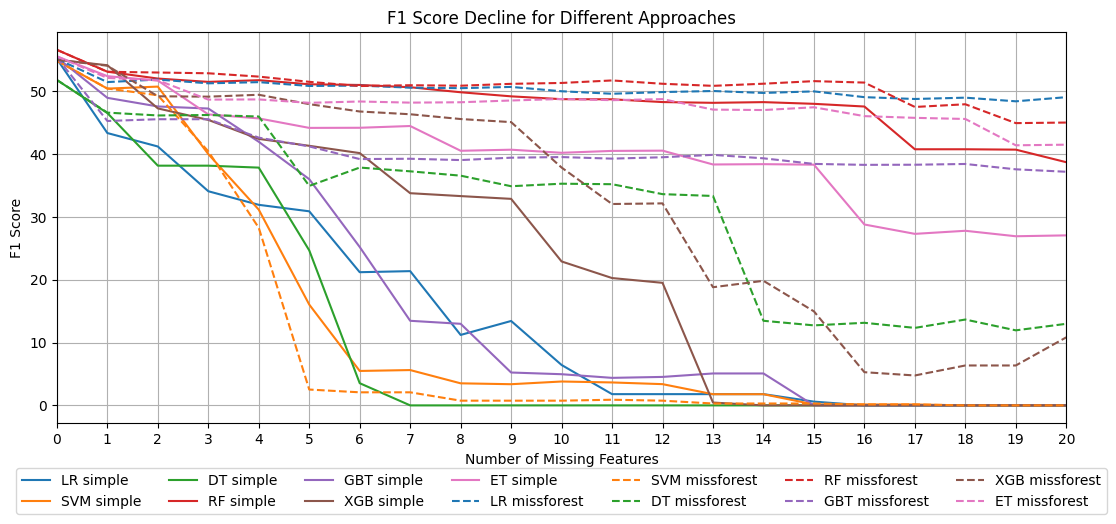

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

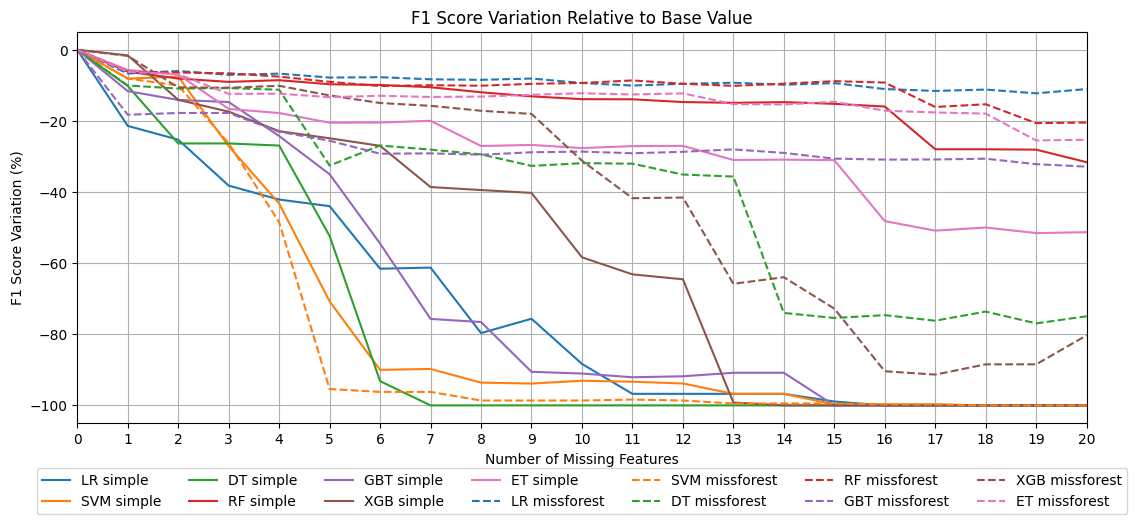

In [ ]:
# Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced accuracy**

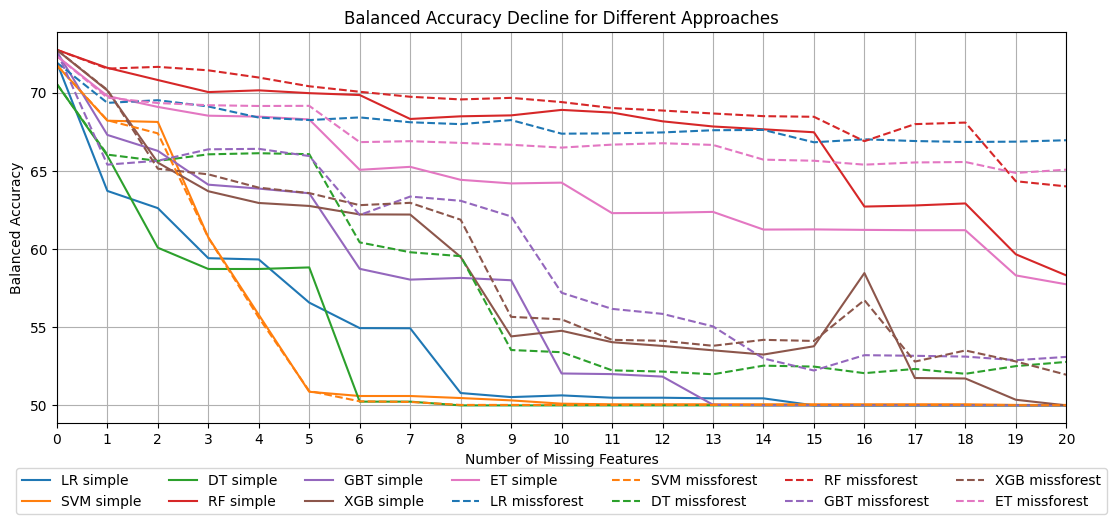

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

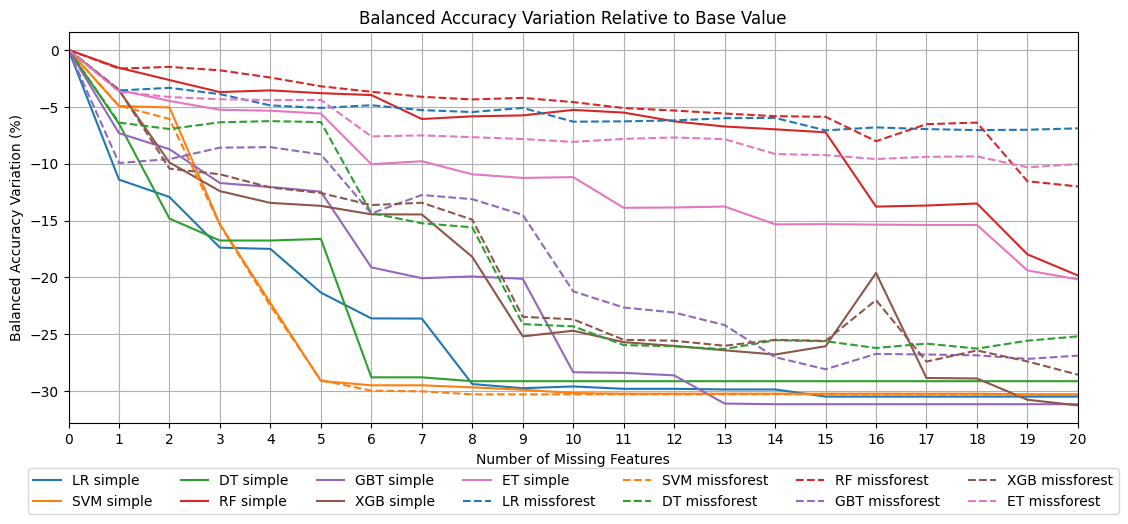

In [ ]:
# Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In this dataset there are few highly correlated variables (even considerind the ohe). So the ensemble models like Random Forests and Extra Trees do not benefit from the power of backup variables because they actually do not exist.

From the analysis of F1 and Balanced Accuracy, Decision Trees and XGBoost seem to be the less resilient to features missing.

# **Results comparison - Temporal Scenario**

## **F1-score**

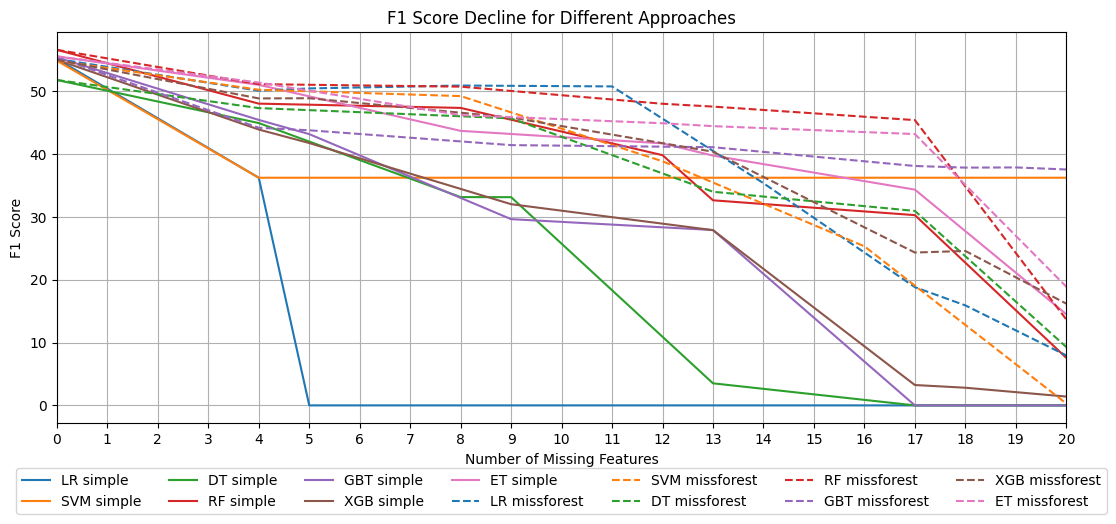

In [ ]:
# Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf_temp['num_feat_missing'], lr_perf_temp['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf_temp['num_feat_missing'], svm_perf_temp['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf_temp['num_feat_missing'], dt_perf_temp['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf_temp['num_feat_missing'], rf_perf_temp['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf_temp['num_feat_missing'], gbt_perf_temp['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf_temp['num_feat_missing'], xgb_perf_temp['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf_temp['num_feat_missing'], et_perf_temp['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_temp_mf['num_feat_missing'], lr_perf_temp_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_temp_mf['num_feat_missing'], svm_perf_temp_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_temp_mf['num_feat_missing'], dt_perf_temp_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_temp_mf['num_feat_missing'], rf_perf_temp_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_temp_mf['num_feat_missing'], gbt_perf_temp_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_temp_mf['num_feat_missing'], xgb_perf_temp_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_temp_mf['num_feat_missing'], et_perf_temp_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

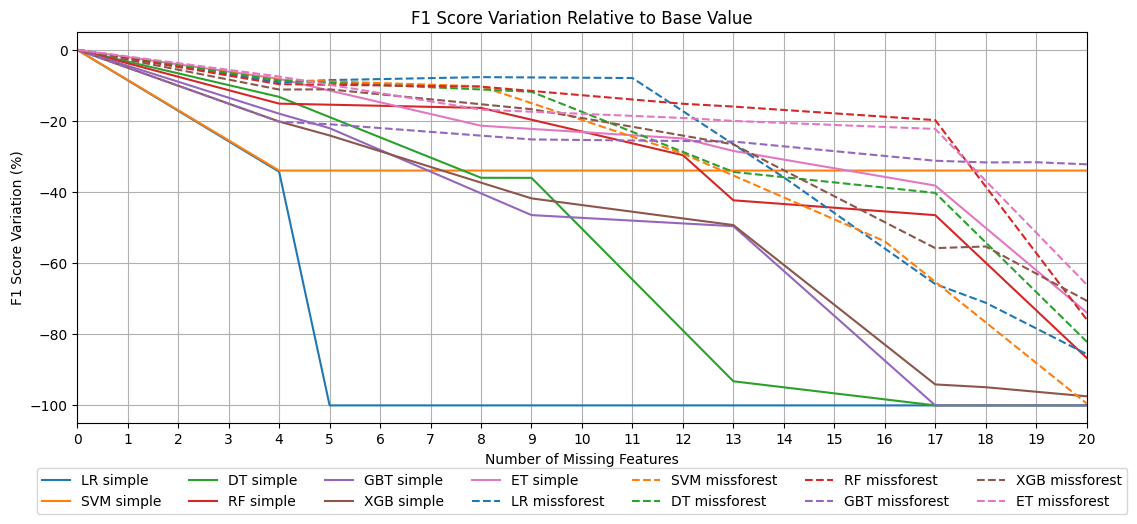

In [ ]:
# Line plot for the f1 score variation relative to the base value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf_temp, svm_perf_temp, dt_perf_temp, rf_perf_temp, gbt_perf_temp, xgb_perf_temp, et_perf_temp,
     lr_perf_temp_mf, svm_perf_temp_mf, dt_perf_temp_mf, rf_perf_temp_mf, gbt_perf_temp_mf, xgb_perf_temp_mf, et_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **Balanced accuracy**

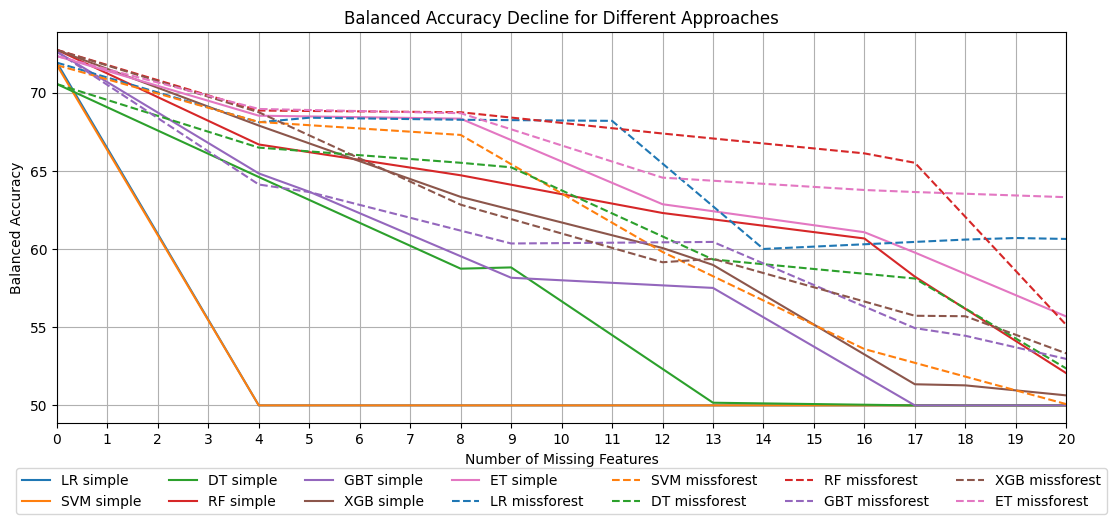

In [ ]:
# Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf_temp['num_feat_missing'], lr2_perf_temp['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf_temp['num_feat_missing'], svm2_perf_temp['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf_temp['num_feat_missing'], dt2_perf_temp['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf_temp['num_feat_missing'], rf2_perf_temp['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf_temp['num_feat_missing'], gbt2_perf_temp['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf_temp['num_feat_missing'], xgb2_perf_temp['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf_temp['num_feat_missing'], et2_perf_temp['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_temp_mf['num_feat_missing'], lr2_perf_temp_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_temp_mf['num_feat_missing'], svm2_perf_temp_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_temp_mf['num_feat_missing'], dt2_perf_temp_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_temp_mf['num_feat_missing'], rf2_perf_temp_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_temp_mf['num_feat_missing'], gbt2_perf_temp_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_temp_mf['num_feat_missing'], xgb2_perf_temp_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_temp_mf['num_feat_missing'], et2_perf_temp_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

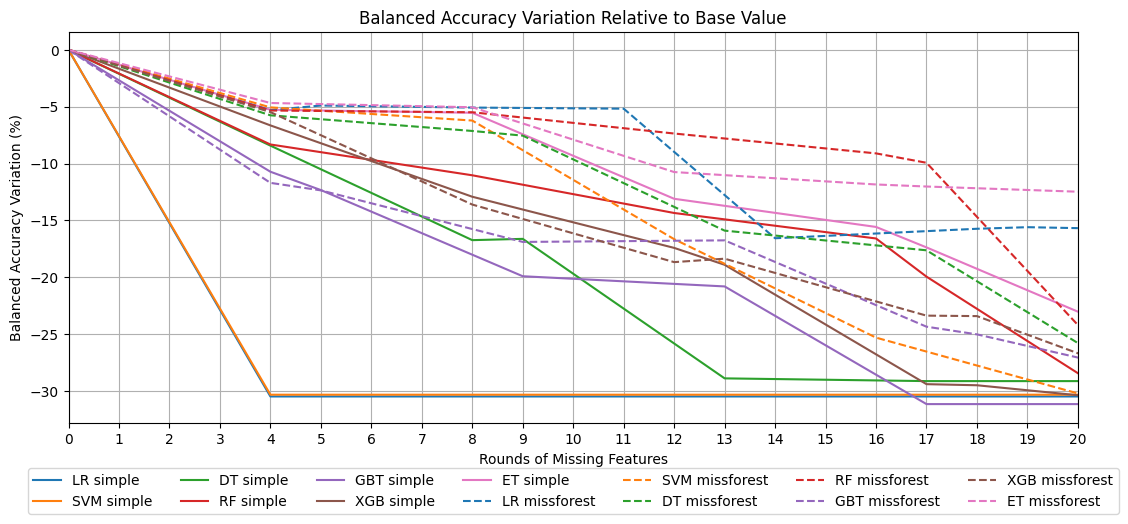

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the balanced accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf_temp, svm2_perf_temp, dt2_perf_temp, rf2_perf_temp, gbt2_perf_temp, xgb2_perf_temp, et2_perf_temp,
     lr2_perf_temp_mf, svm2_perf_temp_mf, dt2_perf_temp_mf, rf2_perf_temp_mf, gbt2_perf_temp_mf, xgb2_perf_temp_mf, et2_perf_temp_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base balanced accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Rounds of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, NUM_FEAT+1))
plt.xlim(0, NUM_FEAT)
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf
}

all_data = combine_datasets(
    dataset_dict,
    'Default Credit Card',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'default_cc_scenario1_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset_temp_dict = {
    'lr_perf_temp': lr_perf_temp,
    'svm_perf_temp': svm_perf_temp,
    'dt_perf_temp': dt_perf_temp,
    'rf_perf_temp': rf_perf_temp,
    'gbt_perf_temp': gbt_perf_temp,
    'xgb_perf_temp': xgb_perf_temp,
    'et_perf_temp': et_perf_temp,
    'lr_perf_temp_mf': lr_perf_temp_mf,
    'svm_perf_temp_mf': svm_perf_temp_mf,
    'dt_perf_temp_mf': dt_perf_temp_mf,
    'rf_perf_temp_mf': rf_perf_temp_mf,
    'gbt_perf_temp_mf': gbt_perf_temp_mf,
    'xgb_perf_temp_mf': xgb_perf_temp_mf,
    'et_perf_temp_mf': et_perf_temp_mf,
    'lr2_perf_temp': lr2_perf_temp,
    'svm2_perf_temp': svm2_perf_temp,
    'dt2_perf_temp': dt2_perf_temp,
    'rf2_perf_temp': rf2_perf_temp,
    'gbt2_perf_temp': gbt2_perf_temp,
    'xgb2_perf_temp': xgb2_perf_temp,
    'et2_perf_temp': et2_perf_temp,
    'lr2_perf_temp_mf': lr2_perf_temp_mf,
    'svm2_perf_temp_mf': svm2_perf_temp_mf,
    'dt2_perf_temp_mf': dt2_perf_temp_mf,
    'rf2_perf_temp_mf': rf2_perf_temp_mf,
    'gbt2_perf_temp_mf': gbt2_perf_temp_mf,
    'xgb2_perf_temp_mf': xgb2_perf_temp_mf,
    'et2_perf_temp_mf': et2_perf_temp_mf
}

all_data_temp = combine_datasets(
    dataset_temp_dict,
    'Default Credit Card Temporal',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data_temp, 'default_cc_temp_scenario1_seed_1981.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>